In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas

from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *
from annotation_utilities import *
from registration_utilities import *
from cell_utilities import *

Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk
File does not exist: /shared/CSHL_data_processed/MD590/MD590_alignedTo_MD590-N47-2015.09.12-05.32.06_MD590_2_0140_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD590/MD590_alignedTo_MD590-N47-2015.09.12-05.32.06_MD590_2_0140_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD591/MD591_alignedTo_MD591-N57-2015.09.21-17.13.29_MD591_1_0169_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD591/MD591_alignedTo_MD591-N57-2015.09.21-17.13.29_MD591_1_0169_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD592/MD592_alignedTo_MD592-IHC59-2015.08.26-00.06.25_MD592_2_0176_cropbox.txt
File does not exist: /shared/CSHL_d

In [2]:
min_blob_area = 10
max_blob_area = 10000

In [3]:
alg = 'cellprofiler'
# alg = 'farsight'
# alg = 'myown'

# One stack

In [4]:
stack = 'MD589'

In [5]:
sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
first_bs_section, last_bs_section = metadata_cache['section_limits'][stack]

In [6]:
output_dir = create_if_not_exists(os.path.join(DETECTED_CELLS_ROOTDIR, stack))

In [24]:
for sec in [104]:
# for sec in range(first_bs_section, last_bs_section+1):
# for sec in range(117, last_bs_section+1):

    fn = sections_to_filenames[sec]
    if is_invalid(fn):
        continue
        
    fn_output_dir = create_if_not_exists(os.path.join(output_dir, fn))

    sys.stderr.write('Processing section: %03d\n' % sec)

#     jpeg_filename = DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='compressed')
#     copyto_filename ='/home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD589/%(fn)s/%(fn)s_image.jpg' % {'fn':fn}
#     execute_command("cp %s %s" % (jpeg_filename, copyto_filename))
    
    # Load mask
    t = time.time()
    mask_tb = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec)
    mask = resize(mask_tb, metadata_cache['image_shape'][stack][::-1]) > .5
    sys.stderr.write('Load mask: %.2f\n' % (time.time() - t) )

    if alg == 'myown':
        
        img_filename = DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='cropped')

        img = imread(img_filename)
        sys.stderr.write('Load image: %.2f\n' % (time.time() - t) )

        t = time.time()
        im = rgb2gray(img)
        sys.stderr.write('Convert to gray: %.2f\n' % (time.time() - t) )

        t = time.time()

        thresh = threshold_otsu(im)
        binary = im < thresh
        binary[~mask] = 0

        sys.stderr.write('threshold: %.2f\n' % (time.time() - t) )
    #     imsave(fn_output_dir + '/%(fn)s_otsu.png' % {'fn':fn}, binary.astype(np.uint8)*255)

        # plt.imshow(binary, cmap=plt.cm.gray);
        # plt.axis('off');
        # plt.title('binary');

        t = time.time()
        dt = distance_transform_edt(binary)
        sys.stderr.write('distance transform: %.2f\n' % (time.time() - t) )

    #     imsave(fn_output_dir + '/%(fn)s_dt.png' % {'fn':fn}, img_as_ubyte(plt.cm.jet(dt/dt.max())))

        # plt.imshow(dt, cmap=plt.cm.gray);
        # plt.axis('off');
        # plt.title('distance tranform');

        t = time.time()
        local_maxi = peak_local_max(dt, labels=binary, footprint=np.ones((10, 10)), indices=False)
        sys.stderr.write('local max: %.2f\n' % (time.time() - t) )

        # plt.imshow(local_maxi, cmap=plt.cm.gray);
        # plt.axis('off');
        # plt.title('local maxima');

        t = time.time()
        markers = label(local_maxi)
        sys.stderr.write('label: %.2f\n' % (time.time() - t) )

        t = time.time()
        labelmap = watershed(-dt, markers, mask=binary)
        sys.stderr.write('watershed: %.2f\n' % (time.time() - t) )
        
    elif alg == 'cellprofiler':
        labelmap = load_cell_data(stack=stack, sec=sec, what='image_inverted_labelmap_cellprofiler', ext='bp')
#         labels = bp.unpack_ndarray_file(output_dir + '/%(fn)s/%(fn)s_image_inverted_labelmap_cellprofiler.bp' % \
#                                         dict(fn=fn))
        labelmap[~mask] = 0
    
    elif alg == 'farsight':
#         labelmap = bp.unpack_ndarray_file(output_dir + '/%(fn)s/%(fn)s_image_inverted_labelmap_farsight.bp' % \
#                                        dict(fn=fn))
        labelmap = load_cell_data(stack=stack, sec=sec, what='image_inverted_labelmap_farsight', ext='bp')
        labelmap[~mask] = 0
    
    else:
        raise 'Algorithm not recognized.'
    
    # plt.imshow(labelmap);
    # plt.axis('off');
    # plt.title('labelmap');

    t = time.time()
    props = regionprops(labelmap.astype(np.int32))
    sys.stderr.write('regionprops: %.2f\n' % (time.time() - t) )

#     plt.hist([p.area for p in props], bins=100);
#     plt.title('Area histograms');
#     plt.show();

#     valid_blob_indices = [i for i, p in enumerate(props) if p.area > min_blob_area and p.area < max_blob_area]
    valid_blob_indices = [i for i, p in enumerate(props)]
    sys.stderr.write('%d blobs identified.\n' % len(valid_blob_indices))
    
    # Get blobs
    t = time.time()
    valid_blob_coords = [props[i].coords for i in valid_blob_indices] # r,c
    #     pickle.dump(valid_blob_coords, open(fn_output_dir + '/%(fn)s_blobCoords.pkl' % {'fn':fn}, 'w'))
#     pandas.Series(data=valid_blob_coords).to_hdf(fn_output_dir + '/%(fn)s_blobCoords.hdf' % {'fn': fn}, 'data', mode='w')
    save_hdf_v2(valid_blob_coords, get_cell_data_filepath(stack=stack, sec=sec, what='blobCoords', ext='hdf'))
    sys.stderr.write('Save blob coords: %.2f\n' % (time.time() - t) )
    
    # Generate masks
    t = time.time()
#     bar = show_progress_bar(first_bs_section, last_bs_section)

    cell_masks = []
    cell_mask_centers = []
    for i, coords in enumerate(valid_blob_coords):
#         bar.value = i
        ymin, xmin = coords.min(axis=0)
        ymax, xmax = coords.max(axis=0)
        cell_mask = np.zeros((ymax+1-ymin, xmax+1-xmin), np.bool)
        cell_mask[coords[:,0]-ymin, coords[:,1]-xmin] = 1
        yc, xc = np.mean(np.where(cell_mask), axis=1)
        cell_masks.append(cell_mask)
        cell_mask_centers.append([xc, yc])
    
#     pandas.Series(data=cell_masks).to_hdf(fn_output_dir + '/%(fn)s_blobMasks.hdf' % {'fn': fn}, 'data', mode='w')
    save_hdf_v2(cell_masks, get_cell_data_filepath(stack=stack, sec=sec, what='blobMasks', ext='hdf'))
    bp.pack_ndarray_file(np.array(cell_mask_centers), get_cell_data_filepath(stack=stack, sec=sec, what='blobMaskCenters', ext='hdf'))
    
    sys.stderr.write('Save blob masks: %.2f\n' % (time.time() - t) )
    
    # Other blob attributes
    t = time.time()

#     valid_blob_contours = [find_contour_points(msk, sample_every=1)[1][0] for msk in cell_masks]

    def find_contour_worker(msk):
        if msk.shape[0] == 1:
            # if mask is a straight line, append another line to it.
            msk = np.vstack([msk, np.ones((msk.shape[1],))])
        elif msk.shape[1] == 1:
            msk = np.c_[msk, np.ones((msk.shape[0],))]
        return find_contour_points(msk, sample_every=1)[1][0]
        
    pool = Pool(NUM_CORES)
    valid_blob_contours = pool.map(lambda msk: find_contour_worker(msk), cell_masks)
    pool.terminate()
    pool.join()

#     pickle.dump(valid_blob_contours, open(fn_output_dir + '/%(fn)s_blobContours.pkl' % {'fn':fn}, 'w'))
#     pandas.Series(data=valid_blob_contours).to_hdf(fn_output_dir + '/%(fn)s_blobContours.hdf' % {'fn': fn}, 'data', mode='w')
    
    save_hdf_v2(valid_blob_contours, 
               get_cell_data_filepath(stack=stack, sec=sec, what='blobContours', ext='hdf'))

    sys.stderr.write('Save blob contours, save: %.2f\n' % (time.time() - t) )
    
    t = time.time()

    valid_blob_orientations = np.array([props[i].orientation for i in valid_blob_indices])
    valid_blob_centroids = np.array([props[i].centroid for i in valid_blob_indices])[:,::-1] # r,c -> x,y
    valid_blob_majorAxisLen = np.array([props[i].major_axis_length for i in valid_blob_indices])
    valid_blob_minorAxisLen = np.array([props[i].minor_axis_length for i in valid_blob_indices])

    bp.pack_ndarray_file(valid_blob_orientations, 
                         get_cell_data_filepath(stack=stack, sec=sec, what='blobOrientations', ext='bp'))
    bp.pack_ndarray_file(valid_blob_centroids, 
                        get_cell_data_filepath(stack=stack, sec=sec, what='blobCentroids', ext='bp'))
    bp.pack_ndarray_file(valid_blob_majorAxisLen, 
                        get_cell_data_filepath(stack=stack, sec=sec, what='blobMajorAxisLen', ext='bp'))
    bp.pack_ndarray_file(valid_blob_minorAxisLen, 
                         get_cell_data_filepath(stack=stack, sec=sec, what='blobMinorAxisLen', ext='bp'))
    
#     bp.pack_ndarray_file(valid_blob_orientations, fn_output_dir + '/%(fn)s_blobOrientations.bp' % {'fn':fn})
#     bp.pack_ndarray_file(valid_blob_centroids, fn_output_dir + '/%(fn)s_blobCentroids.bp' % {'fn':fn})
#     bp.pack_ndarray_file(valid_blob_majorAxisLen, fn_output_dir + '/%(fn)s_blobMajorAxisLen.bp' % {'fn':fn})
#     bp.pack_ndarray_file(valid_blob_minorAxisLen, fn_output_dir + '/%(fn)s_blobMinorAxisLen.bp' % {'fn':fn})

    blob_contours_global = [(valid_blob_contours[i] - cell_mask_centers[i] + valid_blob_centroids[i]).astype(np.int)
                            for i in range(len(valid_blob_coords))]
#     pandas.Series(data=blob_contours_global).to_hdf(fn_output_dir + '/%(fn)s_blobContoursGlobal_%(alg)s.hdf' % {'fn': fn, 'alg':alg}, 
#                                                     'data', mode='w')    
    blob_contours_global_fp = get_cell_data_filepath(stack=stack, sec=sec, what='blobContoursGlobal_%(alg)s' % {'alg':alg}, ext='hdf')
    save_hdf_v2(blob_contours_global, blob_contours_global_fp)

    sys.stderr.write('Compute blob properties, save: %.2f\n' % (time.time() - t) )

Processing section: 104
Load mask: 8.47
regionprops: 1.62
44902 blobs identified.
Save blob coords: 2.44
Save blob masks: 2.36
Save blob contours, save: 7.11
Compute blob properties, save: 5.35


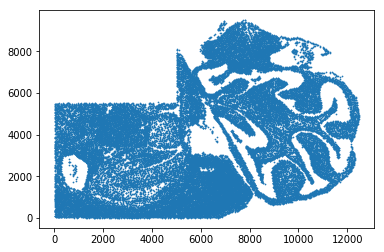

In [30]:
plt.scatter([blob_contours_global[i][0,0] for i in range(len(blob_contours_global))], 
            [blob_contours_global[i][0,1] for i in range(len(blob_contours_global))],
            s=.5);

In [32]:
display_image(label2rgb(labelmap[::5, ::5], bg_label=0))

/shared/MouseBrainAtlas/cells/tmp.jpg

# All stacks

In [ ]:
# for stack in all_nissl_stacks:
for stack in ['MD602', 'MD603']:
        
    sections_to_filenames = metadata_cache['sections_to_filenames'][stack]
    first_bs_section, last_bs_section = metadata_cache['section_limits'][stack]
    
    output_dir = create_if_not_exists(os.path.join(DETECTED_CELLS_ROOTDIR, stack))
    
    for sec in range(first_bs_section, last_bs_section+1):
    
        fn = sections_to_filenames[sec]
        
        if is_invalid(fn=fn):
            continue

        fn_output_dir = create_if_not_exists(os.path.join(output_dir, fn))

        sys.stderr.write('Processing section: %03d\n' % sec)

        jpeg_filename = DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='compressed')
        copyto_filename ='/home/yuncong/csd395/CSHL_cells_v2/detected_cells/%(stack)s/%(fn)s/%(fn)s_image.jpg' % {'fn':fn, 'stack':stack}
        execute_command("cp %s %s" % (jpeg_filename, copyto_filename))

        # Load mask
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec)
        mask = resize(mask_tb, metadata_cache['image_shape'][stack][::-1]) > .5
        sys.stderr.write('Load mask: %.2f\n' % (time.time() - t) )


        if alg == 'myown':

            img_filename = DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='cropped')

            img = imread(img_filename)
            sys.stderr.write('Load image: %.2f\n' % (time.time() - t) )

            t = time.time()
            im = rgb2gray(img)
            sys.stderr.write('Convert to gray: %.2f\n' % (time.time() - t) )

            t = time.time()

            thresh = threshold_otsu(im)
            binary = im < thresh
            binary[~mask] = 0

            sys.stderr.write('threshold: %.2f\n' % (time.time() - t) )
        #     imsave(fn_output_dir + '/%(fn)s_otsu.png' % {'fn':fn}, binary.astype(np.uint8)*255)

            # plt.imshow(binary, cmap=plt.cm.gray);
            # plt.axis('off');
            # plt.title('binary');

            t = time.time()
            dt = distance_transform_edt(binary)
            sys.stderr.write('distance transform: %.2f\n' % (time.time() - t) )

        #     imsave(fn_output_dir + '/%(fn)s_dt.png' % {'fn':fn}, img_as_ubyte(plt.cm.jet(dt/dt.max())))

            # plt.imshow(dt, cmap=plt.cm.gray);
            # plt.axis('off');
            # plt.title('distance tranform');

            t = time.time()
            local_maxi = peak_local_max(dt, labels=binary, footprint=np.ones((10, 10)), indices=False)
            sys.stderr.write('local max: %.2f\n' % (time.time() - t) )

            # plt.imshow(local_maxi, cmap=plt.cm.gray);
            # plt.axis('off');
            # plt.title('local maxima');

            t = time.time()
            markers = label(local_maxi)
            sys.stderr.write('label: %.2f\n' % (time.time() - t) )

            t = time.time()
            labels = watershed(-dt, markers, mask=binary)
            sys.stderr.write('watershed: %.2f\n' % (time.time() - t) )

        elif alg == 'cellprofiler':
            labels = bp.unpack_ndarray_file(output_dir + '/%(fn)s/%(fn)s_image_inverted_labelmap_cellprofiler.bp' % \
                                            dict(fn=fn))
            labels[~mask] = 0

        elif alg == 'farsight':
            labels = bp.unpack_ndarray_file(output_dir + '/%(fn)s/%(fn)s_image_inverted_labelmap_farsight.bp' % \
                                           dict(fn=fn))
            labels[~mask] = 0

        else:
            raise 'Algorithm not recognized.'

        # plt.imshow(labels);
        # plt.axis('off');
        # plt.title('labels');

        t = time.time()
        props = regionprops(labels)
        sys.stderr.write('regionprops: %.2f\n' % (time.time() - t) )

    #     plt.hist([p.area for p in props], bins=100);
    #     plt.title('Area histograms');
    #     plt.show();

        valid_blob_indices = [i for i, p in enumerate(props) if p.area > min_blob_area and p.area < max_blob_area]
        sys.stderr.write('%d blobs identified.\n' % len(valid_blob_indices))

        # Get blobs
        t = time.time()
        valid_blob_coords = [props[i].coords for i in valid_blob_indices] # r,c
        #     pickle.dump(valid_blob_coords, open(fn_output_dir + '/%(fn)s_blobCoords.pkl' % {'fn':fn}, 'w'))
        pandas.Series(data=valid_blob_coords).to_hdf(fn_output_dir + '/%(fn)s_blobCoords.hdf' % {'fn': fn}, 'data', mode='w')
        sys.stderr.write('Save blob coords: %.2f\n' % (time.time() - t) )

        # Generate masks
        t = time.time()
    #     bar = show_progress_bar(first_bs_section, last_bs_section)

        cell_masks = []
        cell_mask_centers = []
        for i, coords in enumerate(valid_blob_coords):
    #         bar.value = i
            ymin, xmin = coords.min(axis=0)
            ymax, xmax = coords.max(axis=0)
            cell_mask = np.zeros((ymax+1-ymin, xmax+1-xmin), np.bool)
            cell_mask[coords[:,0]-ymin, coords[:,1]-xmin] = 1
            yc, xc = np.mean(np.where(cell_mask), axis=1)
            cell_masks.append(cell_mask)
            cell_mask_centers.append([xc, yc])

        pandas.Series(data=cell_masks).to_hdf(fn_output_dir + '/%(fn)s_blobMasks.hdf' % {'fn': fn}, 'data', mode='w')    
        bp.pack_ndarray_file(np.array(cell_mask_centers), fn_output_dir + '/%(fn)s_blobMaskCenters.bp' % {'fn':fn})

        sys.stderr.write('Save blob masks: %.2f\n' % (time.time() - t) )

        # Other blob attributes
        t = time.time()

    #     valid_blob_contours = [find_contour_points(msk, sample_every=1)[1][0] for msk in cell_masks]

        def find_contour_worker(msk):
            if msk.shape[0] == 1:
                # if mask is a straight line, append another line to it.
                msk = np.vstack([msk, np.ones((msk.shape[1],))])
            elif msk.shape[1] == 1:
                msk = np.c_[msk, np.ones((msk.shape[0],))]
            return find_contour_points(msk, sample_every=1)[1][0]

        pool = Pool(15)
        valid_blob_contours = pool.map(lambda msk: find_contour_worker(msk), cell_masks)
        pool.terminate()
        pool.join()

    #     pickle.dump(valid_blob_contours, open(fn_output_dir + '/%(fn)s_blobContours.pkl' % {'fn':fn}, 'w'))
        pandas.Series(data=valid_blob_contours).to_hdf(fn_output_dir + '/%(fn)s_blobContours.hdf' % {'fn': fn}, 'data', mode='w')

        sys.stderr.write('Save blob contours, save: %.2f\n' % (time.time() - t) )

        t = time.time()

        valid_blob_orientations = np.array([props[i].orientation for i in valid_blob_indices])
        valid_blob_centroids = np.array([props[i].centroid for i in valid_blob_indices])[:,::-1] # r,c -> x,y
        valid_blob_majorAxisLen = np.array([props[i].major_axis_length for i in valid_blob_indices])
        valid_blob_minorAxisLen = np.array([props[i].minor_axis_length for i in valid_blob_indices])

        bp.pack_ndarray_file(valid_blob_orientations, fn_output_dir + '/%(fn)s_blobOrientations.bp' % {'fn':fn})
        bp.pack_ndarray_file(valid_blob_centroids, fn_output_dir + '/%(fn)s_blobCentroids.bp' % {'fn':fn})
        bp.pack_ndarray_file(valid_blob_majorAxisLen, fn_output_dir + '/%(fn)s_blobMajorAxisLen.bp' % {'fn':fn})
        bp.pack_ndarray_file(valid_blob_minorAxisLen, fn_output_dir + '/%(fn)s_blobMinorAxisLen.bp' % {'fn':fn})

        blob_contours_global = [(valid_blob_contours[i] - cell_mask_centers[i] + valid_blob_centroids[i]).astype(np.int)
                                for i in range(len(valid_blob_coords))]
        pandas.Series(data=blob_contours_global).to_hdf(fn_output_dir + '/%(fn)s_blobContoursGlobal_%(alg)s.hdf' % {'fn': fn, 'alg':alg}, 
                                                        'data', mode='w')

        sys.stderr.write('Compute blob properties, save: %.2f\n' % (time.time() - t) )


Processing section: 110


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N19-2015.12.01-16.24.09_MD602_2_0056_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N19-2015.12.01-16.24.09_MD602_2_0056/MD602-N19-2015.12.01-16.24.09_MD602_2_0056_image.jpg


Child returned 0
Load mask: 15.54
regionprops: 1.94
44270 blobs identified.
/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/pandas/core/generic.py:1101: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
Save blob coords: 2.56
Save blob masks: 4.47
Save blob contours, save: 7.47
Compute blob properties, save: 9.39
Processing section: 111


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC19-2015.12.01-22.47.08_MD602_2_0056_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC19-2015.12.01-22.47.08_MD602_2_0056/MD602-IHC19-2015.12.01-22.47.08_MD602_2_0056_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 2.55
46609 blobs identified.
Save blob coords: 2.62
Save blob masks: 5.00
Save blob contours, save: 7.71
Compute blob properties, save: 10.21
Processing section: 112


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N19-2015.12.01-16.24.09_MD602_3_0057_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N19-2015.12.01-16.24.09_MD602_3_0057/MD602-N19-2015.12.01-16.24.09_MD602_3_0057_image.jpg


Child returned 0
Load mask: 14.51
regionprops: 2.58
46995 blobs identified.
Save blob coords: 2.56
Save blob masks: 5.08
Save blob contours, save: 7.66
Compute blob properties, save: 10.44
Processing section: 113


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC19-2015.12.01-22.47.08_MD602_3_0057_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC19-2015.12.01-22.47.08_MD602_3_0057/MD602-IHC19-2015.12.01-22.47.08_MD602_3_0057_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.25
48033 blobs identified.
Save blob coords: 2.62
Save blob masks: 5.31
Save blob contours, save: 7.91
Compute blob properties, save: 10.47
Processing section: 114


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N20-2015.12.01-16.29.14_MD602_1_0058_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N20-2015.12.01-16.29.14_MD602_1_0058/MD602-N20-2015.12.01-16.29.14_MD602_1_0058_image.jpg


Child returned 0
Load mask: 14.38
regionprops: 2.24
40756 blobs identified.
Save blob coords: 2.35
Save blob masks: 4.61
Save blob contours, save: 6.93
Compute blob properties, save: 8.99
Processing section: 115


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC20-2015.12.01-22.52.05_MD602_1_0058_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC20-2015.12.01-22.52.05_MD602_1_0058/MD602-IHC20-2015.12.01-22.52.05_MD602_1_0058_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.44
45959 blobs identified.
Save blob coords: 2.60
Save blob masks: 5.00
Save blob contours, save: 7.49
Compute blob properties, save: 10.08
Processing section: 116


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N20-2015.12.01-16.29.14_MD602_2_0059_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N20-2015.12.01-16.29.14_MD602_2_0059/MD602-N20-2015.12.01-16.29.14_MD602_2_0059_image.jpg


Child returned 0
Load mask: 14.38
regionprops: 2.49
46068 blobs identified.
Save blob coords: 2.61
Save blob masks: 5.00
Save blob contours, save: 7.77
Compute blob properties, save: 10.20
Processing section: 117


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC20-2015.12.01-22.52.05_MD602_2_0059_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC20-2015.12.01-22.52.05_MD602_2_0059/MD602-IHC20-2015.12.01-22.52.05_MD602_2_0059_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.29
46259 blobs identified.
Save blob coords: 2.57
Save blob masks: 5.22
Save blob contours, save: 7.88
Compute blob properties, save: 9.92
Processing section: 118


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N20-2015.12.01-16.29.14_MD602_3_0060_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N20-2015.12.01-16.29.14_MD602_3_0060/MD602-N20-2015.12.01-16.29.14_MD602_3_0060_image.jpg


Child returned 0
Load mask: 14.52
regionprops: 2.54
47914 blobs identified.
Save blob coords: 2.62
Save blob masks: 5.14
Save blob contours, save: 7.91
Compute blob properties, save: 10.44
Processing section: 119


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC20-2015.12.01-22.52.05_MD602_3_0060_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC20-2015.12.01-22.52.05_MD602_3_0060/MD602-IHC20-2015.12.01-22.52.05_MD602_3_0060_image.jpg


Child returned 0
Load mask: 14.44
regionprops: 2.24
47936 blobs identified.
Save blob coords: 2.65
Save blob masks: 5.31
Save blob contours, save: 7.95
Compute blob properties, save: 10.48
Processing section: 120


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N21-2015.12.01-16.34.19_MD602_1_0061_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N21-2015.12.01-16.34.19_MD602_1_0061/MD602-N21-2015.12.01-16.34.19_MD602_1_0061_image.jpg


Child returned 0
Load mask: 14.57
regionprops: 2.30
46330 blobs identified.
Save blob coords: 2.65
Save blob masks: 5.23
Save blob contours, save: 7.71
Compute blob properties, save: 10.20
Processing section: 121


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC21-2015.12.01-22.57.14_MD602_1_0061_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC21-2015.12.01-22.57.14_MD602_1_0061/MD602-IHC21-2015.12.01-22.57.14_MD602_1_0061_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.28
48364 blobs identified.
Save blob coords: 2.69
Save blob masks: 5.34
Save blob contours, save: 7.87
Compute blob properties, save: 10.47
Processing section: 122


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N21-2015.12.01-16.34.19_MD602_2_0062_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N21-2015.12.01-16.34.19_MD602_2_0062/MD602-N21-2015.12.01-16.34.19_MD602_2_0062_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 2.30
45812 blobs identified.
Save blob coords: 2.63
Save blob masks: 5.13
Save blob contours, save: 7.66
Compute blob properties, save: 10.07
Processing section: 123


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC21-2015.12.01-22.57.14_MD602_2_0062_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC21-2015.12.01-22.57.14_MD602_2_0062/MD602-IHC21-2015.12.01-22.57.14_MD602_2_0062_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.23
50302 blobs identified.
Save blob coords: 2.72
Save blob masks: 5.48
Save blob contours, save: 8.10
Compute blob properties, save: 10.76
Processing section: 124


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N21-2015.12.01-16.34.19_MD602_3_0063_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N21-2015.12.01-16.34.19_MD602_3_0063/MD602-N21-2015.12.01-16.34.19_MD602_3_0063_image.jpg


Child returned 0
Load mask: 14.54
regionprops: 2.64
49336 blobs identified.
Save blob coords: 2.68
Save blob masks: 5.26
Save blob contours, save: 8.09
Compute blob properties, save: 10.55
Processing section: 125


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC21-2015.12.01-22.57.14_MD602_3_0063_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC21-2015.12.01-22.57.14_MD602_3_0063/MD602-IHC21-2015.12.01-22.57.14_MD602_3_0063_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.29
50259 blobs identified.
Save blob coords: 2.73
Save blob masks: 5.54
Save blob contours, save: 8.28
Compute blob properties, save: 10.83
Processing section: 126


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N22-2015.12.01-16.40.03_MD602_1_0064_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N22-2015.12.01-16.40.03_MD602_1_0064/MD602-N22-2015.12.01-16.40.03_MD602_1_0064_image.jpg


Child returned 0
Load mask: 14.53
regionprops: 2.32
47070 blobs identified.
Save blob coords: 2.67
Save blob masks: 5.11
Save blob contours, save: 7.95
Compute blob properties, save: 10.46
Processing section: 127


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N22-2015.12.01-16.40.03_MD602_2_0065_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N22-2015.12.01-16.40.03_MD602_2_0065/MD602-N22-2015.12.01-16.40.03_MD602_2_0065_image.jpg


Child returned 0
Load mask: 14.48
regionprops: 2.60
48882 blobs identified.
Save blob coords: 2.72
Save blob masks: 5.31
Save blob contours, save: 8.15
Compute blob properties, save: 10.50
Processing section: 128


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N22-2015.12.01-16.40.03_MD602_1_0066_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N22-2015.12.01-16.40.03_MD602_1_0066/MD602-N22-2015.12.01-16.40.03_MD602_1_0066_image.jpg


Child returned 0
Load mask: 14.53
regionprops: 2.66
49039 blobs identified.
Save blob coords: 2.65
Save blob masks: 5.25
Save blob contours, save: 8.07
Compute blob properties, save: 10.70
Processing section: 129


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N23-2015.12.01-16.45.35_MD602_3_0067_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N23-2015.12.01-16.45.35_MD602_3_0067/MD602-N23-2015.12.01-16.45.35_MD602_3_0067_image.jpg


Child returned 0
Load mask: 14.36
regionprops: 2.18
30705 blobs identified.
Save blob coords: 2.45
Save blob masks: 3.84
Save blob contours, save: 5.47
Compute blob properties, save: 7.51
Processing section: 130


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC23-2015.12.01-23.02.41_MD602_1_0067_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC23-2015.12.01-23.02.41_MD602_1_0067/MD602-IHC23-2015.12.01-23.02.41_MD602_1_0067_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 2.16
50666 blobs identified.
Save blob coords: 2.73
Save blob masks: 5.53
Save blob contours, save: 8.61
Compute blob properties, save: 11.34
Processing section: 131


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N23-2015.12.01-16.45.35_MD602_2_0068_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N23-2015.12.01-16.45.35_MD602_2_0068/MD602-N23-2015.12.01-16.45.35_MD602_2_0068_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 2.88
47002 blobs identified.
Save blob coords: 2.75
Save blob masks: 5.18
Save blob contours, save: 7.87
Compute blob properties, save: 10.83
Processing section: 132


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC23-2015.12.01-23.02.41_MD602_2_0068_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC23-2015.12.01-23.02.41_MD602_2_0068/MD602-IHC23-2015.12.01-23.02.41_MD602_2_0068_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.22
51705 blobs identified.
Save blob coords: 2.72
Save blob masks: 5.68
Save blob contours, save: 8.47
Compute blob properties, save: 11.06
Processing section: 133


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N23-2015.12.01-16.45.35_MD602_1_0069_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N23-2015.12.01-16.45.35_MD602_1_0069/MD602-N23-2015.12.01-16.45.35_MD602_1_0069_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.62
51327 blobs identified.
Save blob coords: 2.73
Save blob masks: 5.48
Save blob contours, save: 8.66
Compute blob properties, save: 10.94
Processing section: 134


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC23-2015.12.01-23.02.41_MD602_3_0069_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC23-2015.12.01-23.02.41_MD602_3_0069/MD602-IHC23-2015.12.01-23.02.41_MD602_3_0069_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.62
52356 blobs identified.
Save blob coords: 2.73
Save blob masks: 5.57
Save blob contours, save: 8.62
Compute blob properties, save: 11.25
Processing section: 135


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N24-2015.12.01-16.50.57_MD602_1_0070_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N24-2015.12.01-16.50.57_MD602_1_0070/MD602-N24-2015.12.01-16.50.57_MD602_1_0070_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.62
50818 blobs identified.
Save blob coords: 2.78
Save blob masks: 5.53
Save blob contours, save: 8.21
Compute blob properties, save: 11.07
Processing section: 136


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC24-2015.12.01-23.08.05_MD602_1_0070_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC24-2015.12.01-23.08.05_MD602_1_0070/MD602-IHC24-2015.12.01-23.08.05_MD602_1_0070_image.jpg


Child returned 0
Load mask: 14.45
regionprops: 2.56
53108 blobs identified.
Save blob coords: 2.86
Save blob masks: 5.74
Save blob contours, save: 8.60
Compute blob properties, save: 11.34
Processing section: 137


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N24-2015.12.01-16.50.57_MD602_2_0071_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N24-2015.12.01-16.50.57_MD602_2_0071/MD602-N24-2015.12.01-16.50.57_MD602_2_0071_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.67
53845 blobs identified.
Save blob coords: 2.94
Save blob masks: 5.87
Save blob contours, save: 8.87
Compute blob properties, save: 11.84
Processing section: 138


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC24-2015.12.01-23.08.05_MD602_2_0071_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC24-2015.12.01-23.08.05_MD602_2_0071/MD602-IHC24-2015.12.01-23.08.05_MD602_2_0071_image.jpg


Child returned 0
Load mask: 14.34
regionprops: 2.29
54618 blobs identified.
Save blob coords: 3.03
Save blob masks: 6.12
Save blob contours, save: 9.02
Compute blob properties, save: 11.95
Processing section: 139


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N24-2015.12.01-16.50.57_MD602_3_0072_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N24-2015.12.01-16.50.57_MD602_3_0072/MD602-N24-2015.12.01-16.50.57_MD602_3_0072_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 2.33
53751 blobs identified.
Save blob coords: 2.82
Save blob masks: 5.86
Save blob contours, save: 9.29
Compute blob properties, save: 11.77
Processing section: 140


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC24-2015.12.01-23.08.05_MD602_3_0072_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC24-2015.12.01-23.08.05_MD602_3_0072/MD602-IHC24-2015.12.01-23.08.05_MD602_3_0072_image.jpg


Child returned 0
Load mask: 14.36
regionprops: 2.29
54632 blobs identified.
Save blob coords: 2.88
Save blob masks: 5.82
Save blob contours, save: 9.32
Compute blob properties, save: 11.76
Processing section: 141


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N25-2015.12.01-16.56.17_MD602_1_0073_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N25-2015.12.01-16.56.17_MD602_1_0073/MD602-N25-2015.12.01-16.56.17_MD602_1_0073_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 2.28
52633 blobs identified.
Save blob coords: 2.94
Save blob masks: 5.92
Save blob contours, save: 8.44
Compute blob properties, save: 11.75
Processing section: 142


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC25-2015.12.01-23.13.42_MD602_1_0073_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC25-2015.12.01-23.13.42_MD602_1_0073/MD602-IHC25-2015.12.01-23.13.42_MD602_1_0073_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.66
55265 blobs identified.
Save blob coords: 2.92
Save blob masks: 5.89
Save blob contours, save: 8.97
Compute blob properties, save: 11.68
Processing section: 143


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N25-2015.12.01-16.56.17_MD602_2_0074_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N25-2015.12.01-16.56.17_MD602_2_0074/MD602-N25-2015.12.01-16.56.17_MD602_2_0074_image.jpg


Child returned 0
Load mask: 14.42
regionprops: 2.68
52494 blobs identified.
Save blob coords: 2.91
Save blob masks: 5.69
Save blob contours, save: 8.67
Compute blob properties, save: 11.54
Processing section: 144


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC25-2015.12.01-23.13.42_MD602_2_0074_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC25-2015.12.01-23.13.42_MD602_2_0074/MD602-IHC25-2015.12.01-23.13.42_MD602_2_0074_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 2.42
57093 blobs identified.
Save blob coords: 3.03
Save blob masks: 6.33
Save blob contours, save: 9.17
Compute blob properties, save: 12.28
Processing section: 145


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N25-2015.12.01-16.56.17_MD602_1_0075_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N25-2015.12.01-16.56.17_MD602_1_0075/MD602-N25-2015.12.01-16.56.17_MD602_1_0075_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.66
54346 blobs identified.
Save blob coords: 2.87
Save blob masks: 5.74
Save blob contours, save: 8.85
Compute blob properties, save: 11.70
Processing section: 146


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC25-2015.12.01-23.13.42_MD602_3_0075_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC25-2015.12.01-23.13.42_MD602_3_0075/MD602-IHC25-2015.12.01-23.13.42_MD602_3_0075_image.jpg


Child returned 0
Load mask: 14.42
regionprops: 2.77
56687 blobs identified.
Save blob coords: 3.00
Save blob masks: 6.10
Save blob contours, save: 9.29
Compute blob properties, save: 12.33
Processing section: 147


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N26-2015.12.01-17.01.43_MD602_1_0076_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N26-2015.12.01-17.01.43_MD602_1_0076/MD602-N26-2015.12.01-17.01.43_MD602_1_0076_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 2.30
54476 blobs identified.
Save blob coords: 3.03
Save blob masks: 5.89
Save blob contours, save: 9.07
Compute blob properties, save: 11.97
Processing section: 148


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC26-2015.12.01-23.19.04_MD602_3_0076_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC26-2015.12.01-23.19.04_MD602_3_0076/MD602-IHC26-2015.12.01-23.19.04_MD602_3_0076_image.jpg


Child returned 0
Load mask: 14.59
regionprops: 2.39
57495 blobs identified.
Save blob coords: 3.05
Save blob masks: 6.31
Save blob contours, save: 9.26
Compute blob properties, save: 12.35
Processing section: 149


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N26-2015.12.01-17.01.43_MD602_2_0077_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N26-2015.12.01-17.01.43_MD602_2_0077/MD602-N26-2015.12.01-17.01.43_MD602_2_0077_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 2.64
57822 blobs identified.
Save blob coords: 3.12
Save blob masks: 6.11
Save blob contours, save: 9.40
Compute blob properties, save: 12.40
Processing section: 150


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC26-2015.12.01-23.19.04_MD602_2_0077_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC26-2015.12.01-23.19.04_MD602_2_0077/MD602-IHC26-2015.12.01-23.19.04_MD602_2_0077_image.jpg


Child returned 0
Load mask: 14.58
regionprops: 2.77
57605 blobs identified.
Save blob coords: 3.09
Save blob masks: 6.18
Save blob contours, save: 9.14
Compute blob properties, save: 12.36
Processing section: 151


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N27-2015.12.01-17.05.22_MD602_3_0079_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N27-2015.12.01-17.05.22_MD602_3_0079/MD602-N27-2015.12.01-17.05.22_MD602_3_0079_image.jpg


Child returned 0
Load mask: 14.32
regionprops: 2.78
58818 blobs identified.
Save blob coords: 3.21
Save blob masks: 6.43
Save blob contours, save: 9.51
Compute blob properties, save: 12.68
Processing section: 152


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC27-2015.12.01-23.23.07_MD602_1_0079_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC27-2015.12.01-23.23.07_MD602_1_0079/MD602-IHC27-2015.12.01-23.23.07_MD602_1_0079_image.jpg


Child returned 0
Load mask: 14.57
regionprops: 2.73
58987 blobs identified.
Save blob coords: 3.12
Save blob masks: 6.36
Save blob contours, save: 9.66
Compute blob properties, save: 12.50
Processing section: 153


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N27-2015.12.01-17.05.22_MD602_1_0081_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N27-2015.12.01-17.05.22_MD602_1_0081/MD602-N27-2015.12.01-17.05.22_MD602_1_0081_image.jpg


Child returned 0
Load mask: 14.41
regionprops: 2.72
60086 blobs identified.
Save blob coords: 3.27
Save blob masks: 6.48
Save blob contours, save: 9.59
Compute blob properties, save: 13.11
Processing section: 154


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC27-2015.12.01-23.23.07_MD602_2_0080_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC27-2015.12.01-23.23.07_MD602_2_0080/MD602-IHC27-2015.12.01-23.23.07_MD602_2_0080_image.jpg


Child returned 0
Load mask: 14.45
regionprops: 2.87
60299 blobs identified.
Save blob coords: 3.16
Save blob masks: 6.47
Save blob contours, save: 9.70
Compute blob properties, save: 12.78
Processing section: 156


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC28-2015.12.01-23.27.06_MD602_3_0082_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC28-2015.12.01-23.27.06_MD602_3_0082/MD602-IHC28-2015.12.01-23.27.06_MD602_3_0082_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.78
61089 blobs identified.
Save blob coords: 3.31
Save blob masks: 6.61
Save blob contours, save: 10.15
Compute blob properties, save: 13.37
Processing section: 157


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N28-2015.12.01-17.09.25_MD602_1_0084_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N28-2015.12.01-17.09.25_MD602_1_0084/MD602-N28-2015.12.01-17.09.25_MD602_1_0084_image.jpg


Child returned 0
Load mask: 14.40
regionprops: 2.81
61771 blobs identified.
Save blob coords: 3.47
Save blob masks: 6.76
Save blob contours, save: 9.82
Compute blob properties, save: 13.35
Processing section: 158


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC28-2015.12.01-23.27.06_MD602_2_0083_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC28-2015.12.01-23.27.06_MD602_2_0083/MD602-IHC28-2015.12.01-23.27.06_MD602_2_0083_image.jpg


Child returned 0
Load mask: 14.55
regionprops: 2.81
61865 blobs identified.
Save blob coords: 3.26
Save blob masks: 6.63
Save blob contours, save: 10.15
Compute blob properties, save: 13.02
Processing section: 160


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC29-2015.12.01-23.31.11_MD602_1_0085_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC29-2015.12.01-23.31.11_MD602_1_0085/MD602-IHC29-2015.12.01-23.31.11_MD602_1_0085_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.78
62890 blobs identified.
Save blob coords: 3.40
Save blob masks: 6.84
Save blob contours, save: 10.23
Compute blob properties, save: 13.56
Processing section: 161


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N29-2015.12.01-17.13.28_MD602_2_0086_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N29-2015.12.01-17.13.28_MD602_2_0086/MD602-N29-2015.12.01-17.13.28_MD602_2_0086_image.jpg


Child returned 0
Load mask: 14.42
regionprops: 2.83
61972 blobs identified.
Save blob coords: 3.27
Save blob masks: 6.66
Save blob contours, save: 10.05
Compute blob properties, save: 13.34
Processing section: 162


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC29-2015.12.01-23.31.11_MD602_2_0086_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC29-2015.12.01-23.31.11_MD602_2_0086/MD602-IHC29-2015.12.01-23.31.11_MD602_2_0086_image.jpg


Child returned 0
Load mask: 14.48
regionprops: 2.85
63859 blobs identified.
Save blob coords: 3.44
Save blob masks: 6.93
Save blob contours, save: 10.23
Compute blob properties, save: 13.76
Processing section: 163


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N30-2015.12.01-17.17.39_MD602_1_0088_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N30-2015.12.01-17.17.39_MD602_1_0088/MD602-N30-2015.12.01-17.17.39_MD602_1_0088_image.jpg


Child returned 0
Load mask: 14.28
Compute blob properties, save: 14.74
Processing section: 169


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N31-2015.12.01-17.22.08_MD602_2_0092_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N31-2015.12.01-17.22.08_MD602_2_0092/MD602-N31-2015.12.01-17.22.08_MD602_2_0092_image.jpg


Child returned 0
Load mask: 14.41
regionprops: 2.62
81170 blobs identified.
Save blob coords: 4.39
Save blob masks: 8.98
Save blob contours, save: 13.42
Compute blob properties, save: 17.32
Processing section: 170


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC31-2015.12.01-23.39.27_MD602_2_0092_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC31-2015.12.01-23.39.27_MD602_2_0092/MD602-IHC31-2015.12.01-23.39.27_MD602_2_0092_image.jpg


Child returned 0
Load mask: 14.34
regionprops: 3.16
82934 blobs identified.
Save blob coords: 4.49
Save blob masks: 8.93
Save blob contours, save: 13.53
Compute blob properties, save: 17.96
Processing section: 171


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N32-2015.12.01-17.26.54_MD602_3_0094_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N32-2015.12.01-17.26.54_MD602_3_0094/MD602-N32-2015.12.01-17.26.54_MD602_3_0094_image.jpg


Child returned 0
Load mask: 14.43
regionprops: 3.17
81685 blobs identified.
Save blob coords: 4.40
Save blob masks: 8.87
Save blob contours, save: 13.13
Compute blob properties, save: 17.67
Processing section: 172


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC32-2015.12.01-23.43.41_MD602_1_0094_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC32-2015.12.01-23.43.41_MD602_1_0094/MD602-IHC32-2015.12.01-23.43.41_MD602_1_0094_image.jpg


Child returned 0
Load mask: 14.36
regionprops: 3.28
85718 blobs identified.
Save blob coords: 4.64
Save blob masks: 9.31
Save blob contours, save: 14.08
Compute blob properties, save: 18.31
Processing section: 173


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N32-2015.12.01-17.26.54_MD602_2_0095_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N32-2015.12.01-17.26.54_MD602_2_0095/MD602-N32-2015.12.01-17.26.54_MD602_2_0095_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 3.35
81598 blobs identified.
Save blob coords: 4.43
Save blob masks: 8.87
Save blob contours, save: 13.29
Compute blob properties, save: 17.47
Processing section: 174


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC32-2015.12.01-23.43.41_MD602_1_0096_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC32-2015.12.01-23.43.41_MD602_1_0096/MD602-IHC32-2015.12.01-23.43.41_MD602_1_0096_image.jpg


Child returned 0
Load mask: 14.43
regionprops: 3.21
86233 blobs identified.
Save blob coords: 4.65
Save blob masks: 9.46
Save blob contours, save: 13.96
Compute blob properties, save: 18.86
Processing section: 175


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N33-2015.12.01-17.31.52_MD602_3_0097_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N33-2015.12.01-17.31.52_MD602_3_0097/MD602-N33-2015.12.01-17.31.52_MD602_3_0097_image.jpg


Child returned 0
Load mask: 14.45
regionprops: 2.80
83882 blobs identified.
Save blob coords: 4.58
Save blob masks: 9.39
Save blob contours, save: 13.60
Compute blob properties, save: 18.55
Processing section: 176


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC33-2015.12.01-23.48.16_MD602_1_0097_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC33-2015.12.01-23.48.16_MD602_1_0097/MD602-IHC33-2015.12.01-23.48.16_MD602_1_0097_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 2.71
85227 blobs identified.
Save blob coords: 4.58
Save blob masks: 9.35
Save blob contours, save: 13.57
Compute blob properties, save: 18.02
Processing section: 177


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N33-2015.12.01-17.31.52_MD602_2_0098_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N33-2015.12.01-17.31.52_MD602_2_0098/MD602-N33-2015.12.01-17.31.52_MD602_2_0098_image.jpg


Child returned 0
Load mask: 14.46
regionprops: 3.38
83062 blobs identified.
Save blob coords: 4.44
Save blob masks: 8.96
Save blob contours, save: 13.46
Compute blob properties, save: 18.10
Processing section: 178


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC33-2015.12.01-23.48.16_MD602_2_0098_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC33-2015.12.01-23.48.16_MD602_2_0098/MD602-IHC33-2015.12.01-23.48.16_MD602_2_0098_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 3.19
87662 blobs identified.
Save blob coords: 4.64
Save blob masks: 9.44
Save blob contours, save: 13.95
Compute blob properties, save: 18.55
Processing section: 179


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N34-2015.12.01-17.36.30_MD602_1_0100_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N34-2015.12.01-17.36.30_MD602_1_0100/MD602-N34-2015.12.01-17.36.30_MD602_1_0100_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 3.26
85002 blobs identified.
Save blob coords: 4.55
Save blob masks: 9.19
Save blob contours, save: 13.99
Compute blob properties, save: 18.32
Processing section: 180


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC34-2015.12.01-23.52.57_MD602_3_0100_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC34-2015.12.01-23.52.57_MD602_3_0100/MD602-IHC34-2015.12.01-23.52.57_MD602_3_0100_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 3.26
87311 blobs identified.
Save blob coords: 4.68
Save blob masks: 9.46
Save blob contours, save: 14.19
Compute blob properties, save: 18.77
Processing section: 181


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N34-2015.12.01-17.36.30_MD602_2_0101_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N34-2015.12.01-17.36.30_MD602_2_0101/MD602-N34-2015.12.01-17.36.30_MD602_2_0101_image.jpg


Child returned 0
Load mask: 14.41
regionprops: 3.50
69892 blobs identified.
Save blob coords: 3.84
Save blob masks: 7.67
Save blob contours, save: 11.39
Compute blob properties, save: 14.97
Processing section: 182


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC34-2015.12.01-23.52.57_MD602_2_0101_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC34-2015.12.01-23.52.57_MD602_2_0101/MD602-IHC34-2015.12.01-23.52.57_MD602_2_0101_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 3.05
88491 blobs identified.
Save blob coords: 4.78
Save blob masks: 9.66
Save blob contours, save: 14.18
Compute blob properties, save: 19.48
Processing section: 183


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N35-2015.12.01-17.41.19_MD602_1_0103_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N35-2015.12.01-17.41.19_MD602_1_0103/MD602-N35-2015.12.01-17.41.19_MD602_1_0103_image.jpg


Child returned 0
Load mask: 14.43
regionprops: 2.82
85158 blobs identified.
Save blob coords: 4.71
Save blob masks: 9.53
Save blob contours, save: 14.51
Compute blob properties, save: 18.65
Processing section: 184


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC35-2015.12.01-23.57.42_MD602_1_0103_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC35-2015.12.01-23.57.42_MD602_1_0103/MD602-IHC35-2015.12.01-23.57.42_MD602_1_0103_image.jpg


Child returned 0
Load mask: 14.39
regionprops: 3.26
90710 blobs identified.
Save blob coords: 4.98
Save blob masks: 9.74
Save blob contours, save: 14.69
Compute blob properties, save: 19.53
Processing section: 185


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N35-2015.12.01-17.41.19_MD602_2_0104_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N35-2015.12.01-17.41.19_MD602_2_0104/MD602-N35-2015.12.01-17.41.19_MD602_2_0104_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 3.38
89410 blobs identified.
Save blob coords: 5.17
Save blob masks: 10.14
Save blob contours, save: 14.82
Compute blob properties, save: 20.15
Processing section: 186


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC35-2015.12.01-23.57.42_MD602_2_0104_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC35-2015.12.01-23.57.42_MD602_2_0104/MD602-IHC35-2015.12.01-23.57.42_MD602_2_0104_image.jpg


Child returned 0
Load mask: 14.42
regionprops: 3.31
93081 blobs identified.
Save blob coords: 5.15
Save blob masks: 10.25
Save blob contours, save: 14.98
Compute blob properties, save: 20.32
Processing section: 187


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N36-2015.12.01-17.46.03_MD602_1_0106_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N36-2015.12.01-17.46.03_MD602_1_0106/MD602-N36-2015.12.01-17.46.03_MD602_1_0106_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 3.41
76961 blobs identified.
Save blob coords: 3.97
Save blob masks: 8.17
Save blob contours, save: 12.51
Compute blob properties, save: 16.25
Processing section: 188


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC36-2015.12.02-00.02.25_MD602_3_0106_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC36-2015.12.02-00.02.25_MD602_3_0106/MD602-IHC36-2015.12.02-00.02.25_MD602_3_0106_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 3.24
87806 blobs identified.
Save blob coords: 4.73
Save blob masks: 9.66
Save blob contours, save: 14.23
Compute blob properties, save: 19.19
Processing section: 189


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N36-2015.12.01-17.46.03_MD602_2_0107_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N36-2015.12.01-17.46.03_MD602_2_0107/MD602-N36-2015.12.01-17.46.03_MD602_2_0107_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 2.65
73288 blobs identified.
Save blob coords: 4.12
Save blob masks: 8.13
Save blob contours, save: 11.73
Compute blob properties, save: 15.99
Processing section: 190


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC36-2015.12.02-00.02.25_MD602_2_0107_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC36-2015.12.02-00.02.25_MD602_2_0107/MD602-IHC36-2015.12.02-00.02.25_MD602_2_0107_image.jpg


Child returned 0
Load mask: 14.36
regionprops: 3.09
90190 blobs identified.
Save blob coords: 4.88
Save blob masks: 9.76
Save blob contours, save: 14.97
Compute blob properties, save: 19.08
Processing section: 191


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N37-2015.12.01-17.50.34_MD602_3_0109_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N37-2015.12.01-17.50.34_MD602_3_0109/MD602-N37-2015.12.01-17.50.34_MD602_3_0109_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 3.32
84445 blobs identified.
Save blob coords: 4.82
Save blob masks: 9.42
Save blob contours, save: 13.89
Compute blob properties, save: 18.94
Processing section: 192


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC37-2015.12.02-00.07.10_MD602_3_0109_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC37-2015.12.02-00.07.10_MD602_3_0109/MD602-IHC37-2015.12.02-00.07.10_MD602_3_0109_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.81
87267 blobs identified.
Save blob coords: 4.81
Save blob masks: 9.86
Save blob contours, save: 13.98
Compute blob properties, save: 18.86
Processing section: 193


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N37-2015.12.01-17.50.34_MD602_2_0110_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N37-2015.12.01-17.50.34_MD602_2_0110/MD602-N37-2015.12.01-17.50.34_MD602_2_0110_image.jpg


Child returned 0
Load mask: 14.32
regionprops: 2.72
73512 blobs identified.
Save blob coords: 4.16
Save blob masks: 8.29
Save blob contours, save: 12.11
Compute blob properties, save: 15.95
Processing section: 194


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC37-2015.12.02-00.07.10_MD602_2_0110_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC37-2015.12.02-00.07.10_MD602_2_0110/MD602-IHC37-2015.12.02-00.07.10_MD602_2_0110_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 3.03
90494 blobs identified.
Save blob coords: 4.77
Save blob masks: 9.84
Save blob contours, save: 15.05
Compute blob properties, save: 19.30
Processing section: 195


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N38-2015.12.01-17.55.05_MD602_3_0112_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N38-2015.12.01-17.55.05_MD602_3_0112/MD602-N38-2015.12.01-17.55.05_MD602_3_0112_image.jpg


Child returned 0
Load mask: 14.46
regionprops: 3.27
84956 blobs identified.
Save blob coords: 4.86
Save blob masks: 9.53
Save blob contours, save: 13.97
Compute blob properties, save: 18.91
Processing section: 196


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC38-2015.12.02-00.12.04_MD602_3_0112_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC38-2015.12.02-00.12.04_MD602_3_0112/MD602-IHC38-2015.12.02-00.12.04_MD602_3_0112_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.70
90561 blobs identified.
Save blob coords: 5.36
Save blob masks: 10.24
Save blob contours, save: 14.41
Compute blob properties, save: 19.90
Processing section: 197


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N38-2015.12.01-17.55.05_MD602_2_0113_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N38-2015.12.01-17.55.05_MD602_2_0113/MD602-N38-2015.12.01-17.55.05_MD602_2_0113_image.jpg


Child returned 0
Load mask: 14.61
regionprops: 3.40
88416 blobs identified.
Save blob coords: 4.88
Save blob masks: 9.63
Save blob contours, save: 14.42
Compute blob properties, save: 19.09
Processing section: 198


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC38-2015.12.02-00.12.04_MD602_2_0113_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC38-2015.12.02-00.12.04_MD602_2_0113/MD602-IHC38-2015.12.02-00.12.04_MD602_2_0113_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 3.31
90193 blobs identified.
Save blob coords: 4.91
Save blob masks: 9.78
Save blob contours, save: 14.76
Compute blob properties, save: 19.25
Processing section: 199


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N39-2015.12.01-18.00.05_MD602_1_0115_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N39-2015.12.01-18.00.05_MD602_1_0115/MD602-N39-2015.12.01-18.00.05_MD602_1_0115_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 3.20
87572 blobs identified.
Save blob coords: 5.67
Save blob masks: 9.77
Save blob contours, save: 14.74
Compute blob properties, save: 19.01
Processing section: 200


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC39-2015.12.02-00.16.53_MD602_3_0115_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC39-2015.12.02-00.16.53_MD602_3_0115/MD602-IHC39-2015.12.02-00.16.53_MD602_3_0115_image.jpg


Child returned 0
Load mask: 14.58
regionprops: 3.37
89515 blobs identified.
Save blob coords: 4.91
Save blob masks: 9.79
Save blob contours, save: 14.81
Compute blob properties, save: 19.47
Processing section: 201


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N39-2015.12.01-18.00.05_MD602_2_0116_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N39-2015.12.01-18.00.05_MD602_2_0116/MD602-N39-2015.12.01-18.00.05_MD602_2_0116_image.jpg


Child returned 0
Load mask: 14.34
regionprops: 2.83
83284 blobs identified.
Save blob coords: 4.67
Save blob masks: 9.25
Save blob contours, save: 13.81
Compute blob properties, save: 18.38
Processing section: 202


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC39-2015.12.02-00.16.53_MD602_2_0116_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC39-2015.12.02-00.16.53_MD602_2_0116/MD602-IHC39-2015.12.02-00.16.53_MD602_2_0116_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 3.35
92228 blobs identified.
Save blob coords: 5.11
Save blob masks: 10.16
Save blob contours, save: 15.12
Compute blob properties, save: 20.18
Processing section: 203


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N40-2015.12.01-18.04.50_MD602_3_0118_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N40-2015.12.01-18.04.50_MD602_3_0118/MD602-N40-2015.12.01-18.04.50_MD602_3_0118_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 3.36
87794 blobs identified.
Save blob coords: 4.98
Save blob masks: 9.74
Save blob contours, save: 14.27
Compute blob properties, save: 19.00
Processing section: 204


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC40-2015.12.02-00.21.41_MD602_3_0118_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC40-2015.12.02-00.21.41_MD602_3_0118/MD602-IHC40-2015.12.02-00.21.41_MD602_3_0118_image.jpg


Child returned 0
Load mask: 14.36
regionprops: 3.27
87705 blobs identified.
Save blob coords: 5.33
Save blob masks: 9.72
Save blob contours, save: 14.35
Compute blob properties, save: 19.34
Processing section: 205


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N40-2015.12.01-18.04.50_MD602_1_0120_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N40-2015.12.01-18.04.50_MD602_1_0120/MD602-N40-2015.12.01-18.04.50_MD602_1_0120_image.jpg


Child returned 0
Load mask: 14.63
regionprops: 3.35
90079 blobs identified.
Save blob coords: 5.07
Save blob masks: 9.97
Save blob contours, save: 15.31
Compute blob properties, save: 19.41
Processing section: 206


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC40-2015.12.02-00.21.41_MD602_2_0119_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC40-2015.12.02-00.21.41_MD602_2_0119/MD602-IHC40-2015.12.02-00.21.41_MD602_2_0119_image.jpg


Child returned 0
Load mask: 14.34
regionprops: 3.44
91022 blobs identified.
Save blob coords: 4.90
Save blob masks: 9.81
Save blob contours, save: 14.88
Compute blob properties, save: 19.66
Processing section: 207


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N41-2015.12.01-18.09.41_MD602_3_0121_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N41-2015.12.01-18.09.41_MD602_3_0121/MD602-N41-2015.12.01-18.09.41_MD602_3_0121_image.jpg


Child returned 0
Load mask: 14.55
regionprops: 2.87
89530 blobs identified.
Save blob coords: 5.54
Save blob masks: 10.31
Save blob contours, save: 14.92
Compute blob properties, save: 20.09
Processing section: 208


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC41-2015.12.02-00.26.19_MD602_3_0121_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC41-2015.12.02-00.26.19_MD602_3_0121/MD602-IHC41-2015.12.02-00.26.19_MD602_3_0121_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 3.34
85163 blobs identified.
Save blob coords: 4.86
Save blob masks: 9.31
Save blob contours, save: 13.89
Compute blob properties, save: 18.76
Processing section: 209


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N41-2015.12.01-18.09.41_MD602_2_0122_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N41-2015.12.01-18.09.41_MD602_2_0122/MD602-N41-2015.12.01-18.09.41_MD602_2_0122_image.jpg


Child returned 0
Load mask: 14.60
regionprops: 2.81
87543 blobs identified.
Save blob coords: 4.96
Save blob masks: 9.97
Save blob contours, save: 14.15
Compute blob properties, save: 19.46
Processing section: 210


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC41-2015.12.02-00.26.19_MD602_2_0122_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC41-2015.12.02-00.26.19_MD602_2_0122/MD602-IHC41-2015.12.02-00.26.19_MD602_2_0122_image.jpg


Child returned 0
Load mask: 14.34
regionprops: 2.86
87711 blobs identified.
Save blob coords: 4.89
Save blob masks: 9.79
Save blob contours, save: 14.48
Compute blob properties, save: 18.95
Processing section: 211


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N42-2015.12.01-18.14.25_MD602_3_0124_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N42-2015.12.01-18.14.25_MD602_3_0124/MD602-N42-2015.12.01-18.14.25_MD602_3_0124_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 3.23
75265 blobs identified.
Save blob coords: 4.69
Save blob masks: 8.67
Save blob contours, save: 12.71
Compute blob properties, save: 17.25
Processing section: 212


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC42-2015.12.02-00.31.11_MD602_3_0124_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC42-2015.12.02-00.31.11_MD602_3_0124/MD602-IHC42-2015.12.02-00.31.11_MD602_3_0124_image.jpg


Child returned 0
Load mask: 14.39
regionprops: 3.08
82779 blobs identified.
Save blob coords: 4.72
Save blob masks: 9.19
Save blob contours, save: 13.52
Compute blob properties, save: 18.26
Processing section: 213


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N42-2015.12.01-18.14.25_MD602_2_0125_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N42-2015.12.01-18.14.25_MD602_2_0125/MD602-N42-2015.12.01-18.14.25_MD602_2_0125_image.jpg


Child returned 0
Load mask: 14.51
regionprops: 2.75
77474 blobs identified.
Save blob coords: 4.51
Save blob masks: 9.01
Save blob contours, save: 12.73
Compute blob properties, save: 17.53
Processing section: 214


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC42-2015.12.02-00.31.11_MD602_2_0125_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC42-2015.12.02-00.31.11_MD602_2_0125/MD602-IHC42-2015.12.02-00.31.11_MD602_2_0125_image.jpg


Child returned 0
Load mask: 14.40
regionprops: 2.69
81708 blobs identified.
Save blob coords: 4.72
Save blob masks: 9.36
Save blob contours, save: 13.04
Compute blob properties, save: 17.99
Processing section: 215


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC43-2015.12.02-00.36.34_MD602_3_0127_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC43-2015.12.02-00.36.34_MD602_3_0127/MD602-IHC43-2015.12.02-00.36.34_MD602_3_0127_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 3.19
82385 blobs identified.
Save blob coords: 4.77
Save blob masks: 9.15
Save blob contours, save: 13.87
Compute blob properties, save: 18.07
Processing section: 216


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N43-2015.12.01-18.19.01_MD602_2_0128_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N43-2015.12.01-18.19.01_MD602_2_0128/MD602-N43-2015.12.01-18.19.01_MD602_2_0128_image.jpg


Child returned 0
Load mask: 14.40
regionprops: 3.07
62890 blobs identified.
Save blob coords: 3.75
Save blob masks: 7.18
Save blob contours, save: 10.56
Compute blob properties, save: 14.09
Processing section: 217


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC43-2015.12.02-00.36.34_MD602_2_0128_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC43-2015.12.02-00.36.34_MD602_2_0128/MD602-IHC43-2015.12.02-00.36.34_MD602_2_0128_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.96
78715 blobs identified.
Save blob coords: 4.45
Save blob masks: 8.76
Save blob contours, save: 13.13
Compute blob properties, save: 17.26
Processing section: 218


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N44-2015.12.01-18.21.46_MD602_1_0130_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N44-2015.12.01-18.21.46_MD602_1_0130/MD602-N44-2015.12.01-18.21.46_MD602_1_0130_image.jpg


Child returned 0
Load mask: 14.43
regionprops: 3.05
60579 blobs identified.
Save blob coords: 3.75
Save blob masks: 7.05
Save blob contours, save: 10.43
Compute blob properties, save: 13.74
Processing section: 219


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC44-2015.12.02-00.41.07_MD602_3_0130_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC44-2015.12.02-00.41.07_MD602_3_0130/MD602-IHC44-2015.12.02-00.41.07_MD602_3_0130_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 3.16
73110 blobs identified.
Save blob coords: 4.29
Save blob masks: 8.30
Save blob contours, save: 12.03
Compute blob properties, save: 16.38
Processing section: 220


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N44-2015.12.01-18.21.46_MD602_2_0131_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N44-2015.12.01-18.21.46_MD602_2_0131/MD602-N44-2015.12.01-18.21.46_MD602_2_0131_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 2.52
68390 blobs identified.
Save blob coords: 4.22
Save blob masks: 7.68
Save blob contours, save: 14.71
Compute blob properties, save: 15.31
Processing section: 221


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC44-2015.12.02-00.41.07_MD602_2_0131_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC44-2015.12.02-00.41.07_MD602_2_0131/MD602-IHC44-2015.12.02-00.41.07_MD602_2_0131_image.jpg


Child returned 0
Load mask: 14.59
regionprops: 3.11
76576 blobs identified.
Save blob coords: 4.46
Save blob masks: 8.56
Save blob contours, save: 12.56
Compute blob properties, save: 16.98
Processing section: 222


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N45-2015.12.01-18.26.41_MD602_3_0133_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N45-2015.12.01-18.26.41_MD602_3_0133/MD602-N45-2015.12.01-18.26.41_MD602_3_0133_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 2.96
61581 blobs identified.
Save blob coords: 3.89
Save blob masks: 6.91
Save blob contours, save: 10.47
Compute blob properties, save: 13.76
Processing section: 223


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC45-2015.12.02-00.46.10_MD602_3_0133_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC45-2015.12.02-00.46.10_MD602_3_0133/MD602-IHC45-2015.12.02-00.46.10_MD602_3_0133_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.74
69223 blobs identified.
Save blob coords: 4.02
Save blob masks: 7.78
Save blob contours, save: 11.50
Compute blob properties, save: 15.35
Processing section: 224


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N45-2015.12.01-18.26.41_MD602_2_0134_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N45-2015.12.01-18.26.41_MD602_2_0134/MD602-N45-2015.12.01-18.26.41_MD602_2_0134_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.99
78592 blobs identified.
Save blob coords: 4.49
Save blob masks: 8.66
Save blob contours, save: 12.96
Compute blob properties, save: 17.38
Processing section: 225


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC45-2015.12.02-00.46.10_MD602_2_0134_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC45-2015.12.02-00.46.10_MD602_2_0134/MD602-IHC45-2015.12.02-00.46.10_MD602_2_0134_image.jpg


Child returned 0
Load mask: 14.38
regionprops: 3.12
79705 blobs identified.
Save blob coords: 4.53
Save blob masks: 8.84
Save blob contours, save: 13.15
Compute blob properties, save: 17.52
Processing section: 226


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC46-2015.12.02-00.51.03_MD602_3_0136_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC46-2015.12.02-00.51.03_MD602_3_0136/MD602-IHC46-2015.12.02-00.51.03_MD602_3_0136_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 3.24
68400 blobs identified.
Save blob coords: 4.97
Save blob masks: 8.34
Save blob contours, save: 11.68
Compute blob properties, save: 16.24
Processing section: 227


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N46-2015.12.01-18.31.37_MD602_2_0137_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N46-2015.12.01-18.31.37_MD602_2_0137/MD602-N46-2015.12.01-18.31.37_MD602_2_0137_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 2.93
64128 blobs identified.
Save blob coords: 3.70
Save blob masks: 7.17
Save blob contours, save: 10.82
Compute blob properties, save: 14.10
Processing section: 228


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC46-2015.12.02-00.51.03_MD602_2_0137_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC46-2015.12.02-00.51.03_MD602_2_0137/MD602-IHC46-2015.12.02-00.51.03_MD602_2_0137_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.99
81877 blobs identified.
Save blob coords: 4.74
Save blob masks: 9.35
Save blob contours, save: 13.43
Compute blob properties, save: 18.38
Processing section: 230


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N47-2015.12.01-18.34.17_MD602_2_0140_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N47-2015.12.01-18.34.17_MD602_2_0140/MD602-N47-2015.12.01-18.34.17_MD602_2_0140_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 3.17
82781 blobs identified.
Save blob coords: 4.90
Save blob masks: 9.33
Save blob contours, save: 13.51
Compute blob properties, save: 18.48
Processing section: 231


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC47-2015.12.02-00.55.42_MD602_2_0140_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC47-2015.12.02-00.55.42_MD602_2_0140/MD602-IHC47-2015.12.02-00.55.42_MD602_2_0140_image.jpg


Child returned 0
Load mask: 14.46
regionprops: 3.32
82097 blobs identified.
Save blob coords: 4.74
Save blob masks: 9.15
Save blob contours, save: 13.81
Compute blob properties, save: 18.07
Processing section: 232


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N48-2015.12.01-18.36.57_MD602_1_0142_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N48-2015.12.01-18.36.57_MD602_1_0142/MD602-N48-2015.12.01-18.36.57_MD602_1_0142_image.jpg


Child returned 0
Load mask: 14.41
regionprops: 3.26
79265 blobs identified.
Save blob coords: 4.79
Save blob masks: 9.15
Save blob contours, save: 13.48
Compute blob properties, save: 17.64
Processing section: 233


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC48-2015.12.02-01.00.33_MD602_1_0142_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC48-2015.12.02-01.00.33_MD602_1_0142/MD602-IHC48-2015.12.02-01.00.33_MD602_1_0142_image.jpg


Child returned 0
Load mask: 14.48
regionprops: 3.18
82289 blobs identified.
Save blob coords: 4.67
Save blob masks: 9.21
Save blob contours, save: 13.67
Compute blob properties, save: 18.28
Processing section: 234


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N48-2015.12.01-18.36.57_MD602_2_0143_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N48-2015.12.01-18.36.57_MD602_2_0143/MD602-N48-2015.12.01-18.36.57_MD602_2_0143_image.jpg


Child returned 0
Load mask: 14.43
regionprops: 2.66
84543 blobs identified.
Save blob coords: 4.82
Save blob masks: 9.66
Save blob contours, save: 14.15
Compute blob properties, save: 18.74
Processing section: 235


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC48-2015.12.02-01.00.33_MD602_2_0143_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC48-2015.12.02-01.00.33_MD602_2_0143/MD602-IHC48-2015.12.02-01.00.33_MD602_2_0143_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 3.30
83867 blobs identified.
Save blob coords: 4.69
Save blob masks: 9.24
Save blob contours, save: 13.72
Compute blob properties, save: 18.30
Processing section: 236


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N49-2015.12.01-18.41.46_MD602_3_0145_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N49-2015.12.01-18.41.46_MD602_3_0145/MD602-N49-2015.12.01-18.41.46_MD602_3_0145_image.jpg


Child returned 0
Load mask: 14.48
regionprops: 3.25
83498 blobs identified.
Save blob coords: 4.88
Save blob masks: 9.41
Save blob contours, save: 13.56
Compute blob properties, save: 18.92
Processing section: 237


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC49-2015.12.02-01.05.12_MD602_1_0145_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC49-2015.12.02-01.05.12_MD602_1_0145/MD602-IHC49-2015.12.02-01.05.12_MD602_1_0145_image.jpg


Child returned 0
Load mask: 14.50
regionprops: 2.86
81962 blobs identified.
Save blob coords: 4.74
Save blob masks: 9.16
Save blob contours, save: 17.24
Compute blob properties, save: 18.36
Processing section: 238


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N49-2015.12.01-18.41.46_MD602_2_0146_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N49-2015.12.01-18.41.46_MD602_2_0146/MD602-N49-2015.12.01-18.41.46_MD602_2_0146_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 3.28
83799 blobs identified.
Save blob coords: 4.71
Save blob masks: 9.34
Save blob contours, save: 13.64
Compute blob properties, save: 18.56
Processing section: 239


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC49-2015.12.02-01.05.12_MD602_2_0146_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC49-2015.12.02-01.05.12_MD602_2_0146/MD602-IHC49-2015.12.02-01.05.12_MD602_2_0146_image.jpg


Child returned 0
Load mask: 14.52
regionprops: 2.67
68843 blobs identified.
Save blob coords: 4.06
Save blob masks: 7.79
Save blob contours, save: 11.73
Compute blob properties, save: 15.61
Processing section: 240


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N50-2015.12.01-18.46.34_MD602_3_0148_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N50-2015.12.01-18.46.34_MD602_3_0148/MD602-N50-2015.12.01-18.46.34_MD602_3_0148_image.jpg


Child returned 0
Load mask: 14.35
regionprops: 2.56
82233 blobs identified.
Save blob coords: 4.66
Save blob masks: 9.45
Save blob contours, save: 13.39
Compute blob properties, save: 18.27
Processing section: 241


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC50-2015.12.02-01.10.03_MD602_1_0148_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC50-2015.12.02-01.10.03_MD602_1_0148/MD602-IHC50-2015.12.02-01.10.03_MD602_1_0148_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.78
82798 blobs identified.
Save blob coords: 4.73
Save blob masks: 9.54
Save blob contours, save: 13.73
Compute blob properties, save: 17.94
Processing section: 242


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N50-2015.12.01-18.46.34_MD602_2_0149_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N50-2015.12.01-18.46.34_MD602_2_0149/MD602-N50-2015.12.01-18.46.34_MD602_2_0149_image.jpg


Child returned 0
Load mask: 14.48
regionprops: 3.18
86148 blobs identified.
Save blob coords: 4.72
Save blob masks: 9.35
Save blob contours, save: 14.43
Compute blob properties, save: 18.66
Processing section: 243


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC50-2015.12.02-01.10.03_MD602_2_0149_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC50-2015.12.02-01.10.03_MD602_2_0149/MD602-IHC50-2015.12.02-01.10.03_MD602_2_0149_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 3.37
85203 blobs identified.
Save blob coords: 4.79
Save blob masks: 9.37
Save blob contours, save: 13.85
Compute blob properties, save: 18.47
Processing section: 244


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N51-2015.12.01-18.51.10_MD602_1_0151_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N51-2015.12.01-18.51.10_MD602_1_0151/MD602-N51-2015.12.01-18.51.10_MD602_1_0151_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 3.26
83209 blobs identified.
Save blob coords: 4.69
Save blob masks: 9.41
Save blob contours, save: 13.59
Compute blob properties, save: 18.33
Processing section: 245


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC51-2015.12.02-01.14.44_MD602_1_0151_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC51-2015.12.02-01.14.44_MD602_1_0151/MD602-IHC51-2015.12.02-01.14.44_MD602_1_0151_image.jpg


Child returned 0
Load mask: 14.43
regionprops: 3.32
86731 blobs identified.
Save blob coords: 4.96
Save blob masks: 9.67
Save blob contours, save: 14.24
Compute blob properties, save: 18.78
Processing section: 246


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N51-2015.12.01-18.51.10_MD602_2_0152_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N51-2015.12.01-18.51.10_MD602_2_0152/MD602-N51-2015.12.01-18.51.10_MD602_2_0152_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 3.32
88048 blobs identified.
Save blob coords: 5.02
Save blob masks: 9.77
Save blob contours, save: 14.70
Compute blob properties, save: 19.68
Processing section: 247


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC51-2015.12.02-01.14.44_MD602_2_0152_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC51-2015.12.02-01.14.44_MD602_2_0152/MD602-IHC51-2015.12.02-01.14.44_MD602_2_0152_image.jpg


Child returned 0
Load mask: 14.35
regionprops: 3.34
84881 blobs identified.
Save blob coords: 4.65
Save blob masks: 9.27
Save blob contours, save: 13.54
Compute blob properties, save: 18.11
Processing section: 248


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N52-2015.12.01-18.55.49_MD602_1_0154_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N52-2015.12.01-18.55.49_MD602_1_0154/MD602-N52-2015.12.01-18.55.49_MD602_1_0154_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 3.28
84445 blobs identified.
Save blob coords: 4.58
Save blob masks: 9.23
Save blob contours, save: 13.47
Compute blob properties, save: 18.45
Processing section: 249


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC52-2015.12.02-01.19.27_MD602_1_0154_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC52-2015.12.02-01.19.27_MD602_1_0154/MD602-IHC52-2015.12.02-01.19.27_MD602_1_0154_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 2.75
78714 blobs identified.
Save blob coords: 4.22
Save blob masks: 8.74
Save blob contours, save: 13.15
Compute blob properties, save: 16.90
Processing section: 250


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N52-2015.12.01-18.55.49_MD602_2_0155_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N52-2015.12.01-18.55.49_MD602_2_0155/MD602-N52-2015.12.01-18.55.49_MD602_2_0155_image.jpg


Child returned 0
Load mask: 14.43
regionprops: 3.15
82856 blobs identified.
Save blob coords: 4.30
Save blob masks: 8.87
Save blob contours, save: 13.48
Compute blob properties, save: 17.40
Processing section: 251


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC52-2015.12.02-01.19.27_MD602_2_0155_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC52-2015.12.02-01.19.27_MD602_2_0155/MD602-IHC52-2015.12.02-01.19.27_MD602_2_0155_image.jpg


Child returned 0
Load mask: 14.44
regionprops: 3.15
82935 blobs identified.
Save blob coords: 4.36
Save blob masks: 8.89
Save blob contours, save: 13.58
Compute blob properties, save: 17.43
Processing section: 252


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N53-2015.12.01-19.00.23_MD602_1_0157_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N53-2015.12.01-19.00.23_MD602_1_0157/MD602-N53-2015.12.01-19.00.23_MD602_1_0157_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 3.21
84111 blobs identified.
Save blob coords: 4.52
Save blob masks: 9.10
Save blob contours, save: 13.69
Compute blob properties, save: 18.35
Processing section: 253


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC53-2015.12.02-01.24.02_MD602_1_0157_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC53-2015.12.02-01.24.02_MD602_1_0157/MD602-IHC53-2015.12.02-01.24.02_MD602_1_0157_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 2.76
83533 blobs identified.
Save blob coords: 4.53
Save blob masks: 9.31
Save blob contours, save: 13.66
Compute blob properties, save: 17.89
Processing section: 254


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N53-2015.12.01-19.00.23_MD602_2_0158_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N53-2015.12.01-19.00.23_MD602_2_0158/MD602-N53-2015.12.01-19.00.23_MD602_2_0158_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 3.29
86381 blobs identified.
Save blob coords: 4.71
Save blob masks: 9.34
Save blob contours, save: 14.37
Compute blob properties, save: 18.48
Processing section: 255


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC53-2015.12.02-01.24.02_MD602_2_0158_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC53-2015.12.02-01.24.02_MD602_2_0158/MD602-IHC53-2015.12.02-01.24.02_MD602_2_0158_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 3.25
84309 blobs identified.
Save blob coords: 4.57
Save blob masks: 9.18
Save blob contours, save: 13.84
Compute blob properties, save: 18.45
Processing section: 256


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N54-2015.12.01-19.05.04_MD602_1_0160_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N54-2015.12.01-19.05.04_MD602_1_0160/MD602-N54-2015.12.01-19.05.04_MD602_1_0160_image.jpg


Child returned 0
Load mask: 14.44
regionprops: 2.79
83645 blobs identified.
Save blob coords: 4.61
Save blob masks: 9.31
Save blob contours, save: 13.68
Compute blob properties, save: 18.14
Processing section: 257


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC54-2015.12.02-01.28.38_MD602_1_0160_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC54-2015.12.02-01.28.38_MD602_1_0160/MD602-IHC54-2015.12.02-01.28.38_MD602_1_0160_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 3.14
86112 blobs identified.
Save blob coords: 4.63
Save blob masks: 9.27
Save blob contours, save: 14.33
Compute blob properties, save: 18.71
Processing section: 258


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N54-2015.12.01-19.05.04_MD602_2_0161_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N54-2015.12.01-19.05.04_MD602_2_0161/MD602-N54-2015.12.01-19.05.04_MD602_2_0161_image.jpg


Child returned 0
Load mask: 14.46
regionprops: 3.34
85957 blobs identified.
Save blob coords: 4.99
Save blob masks: 9.27
Save blob contours, save: 13.86
Compute blob properties, save: 18.47
Processing section: 259


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC54-2015.12.02-01.28.38_MD602_2_0161_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC54-2015.12.02-01.28.38_MD602_2_0161/MD602-IHC54-2015.12.02-01.28.38_MD602_2_0161_image.jpg


Child returned 0
Load mask: 14.44
regionprops: 2.84
87302 blobs identified.
Save blob coords: 4.71
Save blob masks: 9.75
Save blob contours, save: 14.13
Compute blob properties, save: 18.86
Processing section: 260


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N55-2015.12.01-19.09.28_MD602_1_0163_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N55-2015.12.01-19.09.28_MD602_1_0163/MD602-N55-2015.12.01-19.09.28_MD602_1_0163_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 3.27
86571 blobs identified.
Save blob coords: 4.58
Save blob masks: 9.16
Save blob contours, save: 13.94
Compute blob properties, save: 18.54
Processing section: 261


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC55-2015.12.02-01.33.05_MD602_1_0163_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC55-2015.12.02-01.33.05_MD602_1_0163/MD602-IHC55-2015.12.02-01.33.05_MD602_1_0163_image.jpg


Child returned 0
Load mask: 14.51
regionprops: 2.79
87453 blobs identified.
Save blob coords: 4.80
Save blob masks: 9.81
Save blob contours, save: 14.19
Compute blob properties, save: 19.26
Processing section: 262


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N55-2015.12.01-19.09.28_MD602_2_0164_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N55-2015.12.01-19.09.28_MD602_2_0164/MD602-N55-2015.12.01-19.09.28_MD602_2_0164_image.jpg


Child returned 0
Load mask: 14.44
regionprops: 2.83
85587 blobs identified.
Save blob coords: 4.55
Save blob masks: 9.29
Save blob contours, save: 13.68
Compute blob properties, save: 18.36
Processing section: 263


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC55-2015.12.02-01.33.05_MD602_2_0164_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC55-2015.12.02-01.33.05_MD602_2_0164/MD602-IHC55-2015.12.02-01.33.05_MD602_2_0164_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 3.17
86350 blobs identified.
Save blob coords: 4.63
Save blob masks: 9.28
Save blob contours, save: 13.61
Compute blob properties, save: 18.47
Processing section: 264


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N56-2015.12.01-19.13.50_MD602_1_0166_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N56-2015.12.01-19.13.50_MD602_1_0166/MD602-N56-2015.12.01-19.13.50_MD602_1_0166_image.jpg


Child returned 0
Load mask: 14.48
regionprops: 3.28
86660 blobs identified.
Save blob coords: 4.56
Save blob masks: 9.31
Save blob contours, save: 13.88
Compute blob properties, save: 18.38
Processing section: 265


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC56-2015.12.02-01.37.40_MD602_1_0166_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC56-2015.12.02-01.37.40_MD602_1_0166/MD602-IHC56-2015.12.02-01.37.40_MD602_1_0166_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 3.29
86381 blobs identified.
Save blob coords: 4.65
Save blob masks: 9.39
Save blob contours, save: 13.95
Compute blob properties, save: 18.79
Processing section: 266


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N56-2015.12.01-19.13.50_MD602_2_0167_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N56-2015.12.01-19.13.50_MD602_2_0167/MD602-N56-2015.12.01-19.13.50_MD602_2_0167_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 3.27
85213 blobs identified.
Save blob coords: 4.55
Save blob masks: 9.14
Save blob contours, save: 13.86
Compute blob properties, save: 17.78
Processing section: 267


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC56-2015.12.02-01.37.40_MD602_2_0167_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC56-2015.12.02-01.37.40_MD602_2_0167/MD602-IHC56-2015.12.02-01.37.40_MD602_2_0167_image.jpg


Child returned 0
Load mask: 14.52
regionprops: 3.19
86491 blobs identified.
Save blob coords: 4.61
Save blob masks: 9.41
Save blob contours, save: 14.21
Compute blob properties, save: 18.67
Processing section: 268


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N57-2015.12.01-19.18.17_MD602_1_0169_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N57-2015.12.01-19.18.17_MD602_1_0169/MD602-N57-2015.12.01-19.18.17_MD602_1_0169_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 2.76
84657 blobs identified.
Save blob coords: 4.57
Save blob masks: 9.37
Save blob contours, save: 13.63
Compute blob properties, save: 18.28
Processing section: 269


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC57-2015.12.02-01.42.03_MD602_1_0169_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC57-2015.12.02-01.42.03_MD602_1_0169/MD602-IHC57-2015.12.02-01.42.03_MD602_1_0169_image.jpg


Child returned 0
Load mask: 14.52
regionprops: 2.75
85659 blobs identified.
Save blob coords: 4.94
Save blob masks: 9.24
Save blob contours, save: 14.27
Compute blob properties, save: 18.15
Processing section: 270


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N57-2015.12.01-19.18.17_MD602_2_0170_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N57-2015.12.01-19.18.17_MD602_2_0170/MD602-N57-2015.12.01-19.18.17_MD602_2_0170_image.jpg


Child returned 0
Load mask: 14.49
regionprops: 3.43
87586 blobs identified.
Save blob coords: 4.88
Save blob masks: 9.45
Save blob contours, save: 14.15
Compute blob properties, save: 19.20
Processing section: 271


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC57-2015.12.02-01.42.03_MD602_2_0170_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC57-2015.12.02-01.42.03_MD602_2_0170/MD602-IHC57-2015.12.02-01.42.03_MD602_2_0170_image.jpg


Child returned 0
Load mask: 14.50
regionprops: 2.76
87806 blobs identified.
Save blob coords: 5.05
Save blob masks: 9.98
Save blob contours, save: 14.22
Compute blob properties, save: 19.33
Processing section: 272


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N58-2015.12.01-19.22.46_MD602_1_0172_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N58-2015.12.01-19.22.46_MD602_1_0172/MD602-N58-2015.12.01-19.22.46_MD602_1_0172_image.jpg


Child returned 0
Load mask: 14.32
regionprops: 3.28
88034 blobs identified.
Save blob coords: 5.45
Save blob masks: 9.57
Save blob contours, save: 14.65
Compute blob properties, save: 19.41
Processing section: 273


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC58-2015.12.02-01.46.31_MD602_1_0172_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC58-2015.12.02-01.46.31_MD602_1_0172/MD602-IHC58-2015.12.02-01.46.31_MD602_1_0172_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.81
80144 blobs identified.
Save blob coords: 4.21
Save blob masks: 8.80
Save blob contours, save: 12.70
Compute blob properties, save: 17.14
Processing section: 275


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC58-2015.12.02-01.46.31_MD602_2_0173_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC58-2015.12.02-01.46.31_MD602_2_0173/MD602-IHC58-2015.12.02-01.46.31_MD602_2_0173_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 2.80
86808 blobs identified.
Save blob coords: 4.79
Save blob masks: 9.61
Save blob contours, save: 14.49
Compute blob properties, save: 18.83
Processing section: 276


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N59-2015.12.01-19.26.58_MD602_1_0175_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N59-2015.12.01-19.26.58_MD602_1_0175/MD602-N59-2015.12.01-19.26.58_MD602_1_0175_image.jpg


Child returned 0
Load mask: 14.59
regionprops: 3.28
85789 blobs identified.
Save blob coords: 4.58
Save blob masks: 9.21
Save blob contours, save: 14.14
Compute blob properties, save: 18.53
Processing section: 277


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC59-2015.12.02-01.50.49_MD602_1_0175_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC59-2015.12.02-01.50.49_MD602_1_0175/MD602-IHC59-2015.12.02-01.50.49_MD602_1_0175_image.jpg


Child returned 0
Load mask: 14.36
regionprops: 3.25
81805 blobs identified.
Save blob coords: 4.76
Save blob masks: 9.08
Save blob contours, save: 13.55
Compute blob properties, save: 17.55
Processing section: 278


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N59-2015.12.01-19.26.58_MD602_2_0176_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N59-2015.12.01-19.26.58_MD602_2_0176/MD602-N59-2015.12.01-19.26.58_MD602_2_0176_image.jpg


Child returned 0
Load mask: 14.59
regionprops: 3.24
83447 blobs identified.
Save blob coords: 4.43
Save blob masks: 8.96
Save blob contours, save: 13.53
Compute blob properties, save: 17.85
Processing section: 279


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC59-2015.12.02-01.50.49_MD602_2_0176_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC59-2015.12.02-01.50.49_MD602_2_0176/MD602-IHC59-2015.12.02-01.50.49_MD602_2_0176_image.jpg


Child returned 0
Load mask: 14.38
regionprops: 3.15
85997 blobs identified.
Save blob coords: 4.70
Save blob masks: 9.50
Save blob contours, save: 14.17
Compute blob properties, save: 18.74
Processing section: 280


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N60-2015.12.01-19.31.23_MD602_1_0178_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N60-2015.12.01-19.31.23_MD602_1_0178/MD602-N60-2015.12.01-19.31.23_MD602_1_0178_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 3.31
84899 blobs identified.
Save blob coords: 4.57
Save blob masks: 9.21
Save blob contours, save: 13.93
Compute blob properties, save: 18.40
Processing section: 282


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N60-2015.12.01-19.31.23_MD602_2_0179_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N60-2015.12.01-19.31.23_MD602_2_0179/MD602-N60-2015.12.01-19.31.23_MD602_2_0179_image.jpg


Child returned 0
Load mask: 14.45
regionprops: 2.76
84268 blobs identified.
Save blob coords: 4.46
Save blob masks: 9.28
Save blob contours, save: 14.03
Compute blob properties, save: 18.09
Processing section: 283


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC60-2015.12.02-01.55.15_MD602_2_0179_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC60-2015.12.02-01.55.15_MD602_2_0179/MD602-IHC60-2015.12.02-01.55.15_MD602_2_0179_image.jpg


Child returned 0
Load mask: 14.55
regionprops: 3.29
85474 blobs identified.
Save blob coords: 4.65
Save blob masks: 9.19
Save blob contours, save: 14.01
Compute blob properties, save: 18.54
Processing section: 284


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N61-2015.12.01-19.35.48_MD602_1_0181_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N61-2015.12.01-19.35.48_MD602_1_0181/MD602-N61-2015.12.01-19.35.48_MD602_1_0181_image.jpg


Child returned 0
Load mask: 14.45
regionprops: 2.72
83294 blobs identified.
Save blob coords: 4.42
Save blob masks: 9.23
Save blob contours, save: 13.33
Compute blob properties, save: 18.01
Processing section: 285


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC61-2015.12.02-01.59.23_MD602_3_0181_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC61-2015.12.02-01.59.23_MD602_3_0181/MD602-IHC61-2015.12.02-01.59.23_MD602_3_0181_image.jpg


Child returned 0
Load mask: 14.50
regionprops: 2.74
83907 blobs identified.
Save blob coords: 4.77
Save blob masks: 9.19
Save blob contours, save: 13.65
Compute blob properties, save: 18.09
Processing section: 286


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N61-2015.12.01-19.35.48_MD602_2_0182_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N61-2015.12.01-19.35.48_MD602_2_0182/MD602-N61-2015.12.01-19.35.48_MD602_2_0182_image.jpg


Child returned 0
Load mask: 14.62
regionprops: 3.27
81372 blobs identified.
Save blob coords: 4.45
Save blob masks: 8.73
Save blob contours, save: 13.35
Compute blob properties, save: 17.52
Processing section: 287


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC61-2015.12.02-01.59.23_MD602_2_0182_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC61-2015.12.02-01.59.23_MD602_2_0182/MD602-IHC61-2015.12.02-01.59.23_MD602_2_0182_image.jpg


Child returned 0
Load mask: 14.53
regionprops: 3.15
85160 blobs identified.
Save blob coords: 4.71
Save blob masks: 9.31
Save blob contours, save: 13.72
Compute blob properties, save: 18.81
Processing section: 288


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N61-2015.12.01-19.35.48_MD602_1_0183_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N61-2015.12.01-19.35.48_MD602_1_0183/MD602-N61-2015.12.01-19.35.48_MD602_1_0183_image.jpg


Child returned 0
Load mask: 14.53
regionprops: 2.81
88318 blobs identified.
Save blob coords: 4.74
Save blob masks: 9.81
Save blob contours, save: 14.44
Compute blob properties, save: 19.06
Processing section: 289


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC61-2015.12.02-01.59.23_MD602_1_0183_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC61-2015.12.02-01.59.23_MD602_1_0183/MD602-IHC61-2015.12.02-01.59.23_MD602_1_0183_image.jpg


Child returned 0
Load mask: 14.43
regionprops: 2.68
85491 blobs identified.
Save blob coords: 4.52
Save blob masks: 9.23
Save blob contours, save: 13.83
Compute blob properties, save: 18.48
Processing section: 290


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N62-2015.12.01-19.41.37_MD602_3_0184_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N62-2015.12.01-19.41.37_MD602_3_0184/MD602-N62-2015.12.01-19.41.37_MD602_3_0184_image.jpg


Child returned 0
Load mask: 14.39
regionprops: 3.39
84923 blobs identified.
Save blob coords: 4.63
Save blob masks: 9.19
Save blob contours, save: 14.04
Compute blob properties, save: 18.02
Processing section: 292


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N62-2015.12.01-19.41.37_MD602_2_0185_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N62-2015.12.01-19.41.37_MD602_2_0185/MD602-N62-2015.12.01-19.41.37_MD602_2_0185_image.jpg


Child returned 0
Load mask: 14.94
regionprops: 3.21
84694 blobs identified.
Save blob coords: 4.57
Save blob masks: 9.15
Save blob contours, save: 14.08
Compute blob properties, save: 18.53
Processing section: 293


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC62-2015.12.02-02.04.52_MD602_2_0185_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC62-2015.12.02-02.04.52_MD602_2_0185/MD602-IHC62-2015.12.02-02.04.52_MD602_2_0185_image.jpg


Child returned 0
Load mask: 14.32
regionprops: 3.10
82086 blobs identified.
Save blob coords: 4.31
Save blob masks: 8.77
Save blob contours, save: 13.65
Compute blob properties, save: 17.55
Processing section: 294


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N62-2015.12.01-19.41.37_MD602_1_0186_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N62-2015.12.01-19.41.37_MD602_1_0186/MD602-N62-2015.12.01-19.41.37_MD602_1_0186_image.jpg


Child returned 0
Load mask: 14.49
regionprops: 3.20
82924 blobs identified.
Save blob coords: 4.37
Save blob masks: 8.86
Save blob contours, save: 13.81
Compute blob properties, save: 17.64
Processing section: 295


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC62-2015.12.02-02.04.52_MD602_3_0186_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC62-2015.12.02-02.04.52_MD602_3_0186/MD602-IHC62-2015.12.02-02.04.52_MD602_3_0186_image.jpg


Child returned 0
Load mask: 14.38
regionprops: 3.06
81948 blobs identified.
Save blob coords: 4.24
Save blob masks: 8.74
Save blob contours, save: 13.59
Compute blob properties, save: 17.20
Processing section: 297


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC63-2015.12.02-02.10.30_MD602_1_0187_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC63-2015.12.02-02.10.30_MD602_1_0187/MD602-IHC63-2015.12.02-02.10.30_MD602_1_0187_image.jpg


Child returned 0
Load mask: 14.40
regionprops: 3.22
78822 blobs identified.
Save blob coords: 4.37
Save blob masks: 8.60
Save blob contours, save: 13.04
Compute blob properties, save: 17.09
Processing section: 298


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N63-2015.12.01-19.47.22_MD602_1_0187_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N63-2015.12.01-19.47.22_MD602_1_0187/MD602-N63-2015.12.01-19.47.22_MD602_1_0187_image.jpg


Child returned 0
Load mask: 14.45
regionprops: 2.60
63566 blobs identified.
Save blob coords: 3.56
Save blob masks: 6.99
Save blob contours, save: 10.79
Compute blob properties, save: 13.64
Processing section: 299


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC63-2015.12.02-02.10.30_MD602_2_0188_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC63-2015.12.02-02.10.30_MD602_2_0188/MD602-IHC63-2015.12.02-02.10.30_MD602_2_0188_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 3.05
81350 blobs identified.
Save blob coords: 4.42
Save blob masks: 8.76
Save blob contours, save: 13.14
Compute blob properties, save: 17.63
Processing section: 300


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N63-2015.12.01-19.47.22_MD602_2_0188_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N63-2015.12.01-19.47.22_MD602_2_0188/MD602-N63-2015.12.01-19.47.22_MD602_2_0188_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 3.23
82733 blobs identified.
Save blob coords: 4.38
Save blob masks: 8.87
Save blob contours, save: 13.47
Compute blob properties, save: 17.49
Processing section: 301


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC63-2015.12.02-02.10.30_MD602_3_0189_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC63-2015.12.02-02.10.30_MD602_3_0189/MD602-IHC63-2015.12.02-02.10.30_MD602_3_0189_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 3.12
65662 blobs identified.
Save blob coords: 3.61
Save blob masks: 7.02
Save blob contours, save: 11.09
Compute blob properties, save: 14.16
Processing section: 302


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N64-2015.12.01-19.52.07_MD602_1_0190_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N64-2015.12.01-19.52.07_MD602_1_0190/MD602-N64-2015.12.01-19.52.07_MD602_1_0190_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 2.51
65116 blobs identified.
Save blob coords: 8.38
Save blob masks: 7.26
Save blob contours, save: 10.92
Compute blob properties, save: 14.14
Processing section: 303


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC64-2015.12.02-02.16.23_MD602_1_0190_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC64-2015.12.02-02.16.23_MD602_1_0190/MD602-IHC64-2015.12.02-02.16.23_MD602_1_0190_image.jpg


Child returned 0
Load mask: 14.50
regionprops: 3.08
80083 blobs identified.
Save blob coords: 4.43
Save blob masks: 8.79
Save blob contours, save: 13.18
Compute blob properties, save: 17.51
Processing section: 304


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N64-2015.12.01-19.52.07_MD602_2_0191_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N64-2015.12.01-19.52.07_MD602_2_0191/MD602-N64-2015.12.01-19.52.07_MD602_2_0191_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 2.58
62685 blobs identified.
Save blob coords: 3.54
Save blob masks: 7.19
Save blob contours, save: 10.89
Compute blob properties, save: 13.76
Processing section: 305


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC64-2015.12.02-02.16.23_MD602_2_0191_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC64-2015.12.02-02.16.23_MD602_2_0191/MD602-IHC64-2015.12.02-02.16.23_MD602_2_0191_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.48
64876 blobs identified.
Save blob coords: 3.56
Save blob masks: 7.21
Save blob contours, save: 10.87
Compute blob properties, save: 14.27
Processing section: 306


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N64-2015.12.01-19.52.07_MD602_3_0192_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N64-2015.12.01-19.52.07_MD602_3_0192/MD602-N64-2015.12.01-19.52.07_MD602_3_0192_image.jpg


Child returned 0
Load mask: 14.38
regionprops: 2.60
80444 blobs identified.
Save blob coords: 4.23
Save blob masks: 8.70
Save blob contours, save: 13.00
Compute blob properties, save: 17.53
Processing section: 307


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC64-2015.12.02-02.16.23_MD602_3_0192_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC64-2015.12.02-02.16.23_MD602_3_0192/MD602-IHC64-2015.12.02-02.16.23_MD602_3_0192_image.jpg


Child returned 0
Load mask: 14.41
regionprops: 2.54
64392 blobs identified.
Save blob coords: 3.44
Save blob masks: 7.11
Save blob contours, save: 10.72
Compute blob properties, save: 13.91
Processing section: 308


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N65-2015.12.01-19.57.40_MD602_1_0193_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N65-2015.12.01-19.57.40_MD602_1_0193/MD602-N65-2015.12.01-19.57.40_MD602_1_0193_image.jpg


Child returned 0
Load mask: 14.50
regionprops: 2.96
72260 blobs identified.
Save blob coords: 3.99
Save blob masks: 7.93
Save blob contours, save: 12.08
Compute blob properties, save: 15.57
Processing section: 309


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC65-2015.12.02-02.22.00_MD602_1_0193_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC65-2015.12.02-02.22.00_MD602_1_0193/MD602-IHC65-2015.12.02-02.22.00_MD602_1_0193_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 2.94
62924 blobs identified.
Save blob coords: 3.43
Save blob masks: 6.91
Save blob contours, save: 10.50
Compute blob properties, save: 13.78
Processing section: 310


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N65-2015.12.01-19.57.40_MD602_2_0194_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N65-2015.12.01-19.57.40_MD602_2_0194/MD602-N65-2015.12.01-19.57.40_MD602_2_0194_image.jpg


Child returned 0
Load mask: 14.45
regionprops: 2.91
69458 blobs identified.
Save blob coords: 4.07
Save blob masks: 7.69
Save blob contours, save: 11.57
Compute blob properties, save: 15.25
Processing section: 311


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC65-2015.12.02-02.22.00_MD602_2_0194_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC65-2015.12.02-02.22.00_MD602_2_0194/MD602-IHC65-2015.12.02-02.22.00_MD602_2_0194_image.jpg


Child returned 0
Load mask: 14.35
regionprops: 2.90
62475 blobs identified.
Save blob coords: 3.45
Save blob masks: 6.92
Save blob contours, save: 10.59
Compute blob properties, save: 13.53
Processing section: 313


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC65-2015.12.02-02.22.00_MD602_3_0195_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC65-2015.12.02-02.22.00_MD602_3_0195/MD602-IHC65-2015.12.02-02.22.00_MD602_3_0195_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 2.78
62165 blobs identified.
Save blob coords: 3.33
Save blob masks: 6.72
Save blob contours, save: 10.25
Compute blob properties, save: 13.43
Processing section: 314


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N66-2015.12.01-20.02.08_MD602_1_0196_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N66-2015.12.01-20.02.08_MD602_1_0196/MD602-N66-2015.12.01-20.02.08_MD602_1_0196_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 2.80
59346 blobs identified.
Save blob coords: 3.28
Save blob masks: 6.57
Save blob contours, save: 9.72
Compute blob properties, save: 12.92
Processing section: 315


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC66-2015.12.02-02.27.37_MD602_1_0196_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC66-2015.12.02-02.27.37_MD602_1_0196/MD602-IHC66-2015.12.02-02.27.37_MD602_1_0196_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 2.77
61044 blobs identified.
Save blob coords: 3.27
Save blob masks: 6.63
Save blob contours, save: 10.09
Compute blob properties, save: 13.23
Processing section: 316


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N66-2015.12.01-20.02.08_MD602_2_0197_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N66-2015.12.01-20.02.08_MD602_2_0197/MD602-N66-2015.12.01-20.02.08_MD602_2_0197_image.jpg


Child returned 0
Load mask: 14.39
regionprops: 2.78
55635 blobs identified.
Save blob coords: 3.11
Save blob masks: 6.14
Save blob contours, save: 9.47
Compute blob properties, save: 12.10
Processing section: 317


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC66-2015.12.02-02.27.37_MD602_2_0197_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC66-2015.12.02-02.27.37_MD602_2_0197/MD602-IHC66-2015.12.02-02.27.37_MD602_2_0197_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.73
61156 blobs identified.
Save blob coords: 3.32
Save blob masks: 6.64
Save blob contours, save: 10.42
Compute blob properties, save: 13.35
Processing section: 318


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N66-2015.12.01-20.02.08_MD602_3_0198_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N66-2015.12.01-20.02.08_MD602_3_0198/MD602-N66-2015.12.01-20.02.08_MD602_3_0198_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 2.46
61397 blobs identified.
Save blob coords: 3.26
Save blob masks: 6.74
Save blob contours, save: 10.16
Compute blob properties, save: 13.12
Processing section: 319


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC66-2015.12.02-02.27.37_MD602_3_0198_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC66-2015.12.02-02.27.37_MD602_3_0198/MD602-IHC66-2015.12.02-02.27.37_MD602_3_0198_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.78
62165 blobs identified.
Save blob coords: 3.29
Save blob masks: 6.59
Save blob contours, save: 10.42
Compute blob properties, save: 13.63
Processing section: 320


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N67-2015.12.01-20.07.33_MD602_1_0199_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N67-2015.12.01-20.07.33_MD602_1_0199/MD602-N67-2015.12.01-20.07.33_MD602_1_0199_image.jpg


Child returned 0
Load mask: 14.32
regionprops: 2.43
60461 blobs identified.
Save blob coords: 3.40
Save blob masks: 6.91
Save blob contours, save: 9.98
Compute blob properties, save: 13.46
Processing section: 321


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC67-2015.12.02-02.32.55_MD602_1_0199_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC67-2015.12.02-02.32.55_MD602_1_0199/MD602-IHC67-2015.12.02-02.32.55_MD602_1_0199_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 2.68
60011 blobs identified.
Save blob coords: 3.30
Save blob masks: 6.48
Save blob contours, save: 10.36
Compute blob properties, save: 13.10
Processing section: 322


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N67-2015.12.01-20.07.33_MD602_2_0200_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N67-2015.12.01-20.07.33_MD602_2_0200/MD602-N67-2015.12.01-20.07.33_MD602_2_0200_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 2.69
58202 blobs identified.
Save blob coords: 3.21
Save blob masks: 6.34
Save blob contours, save: 9.86
Compute blob properties, save: 12.59
Processing section: 323


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC67-2015.12.02-02.32.55_MD602_2_0200_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC67-2015.12.02-02.32.55_MD602_2_0200/MD602-IHC67-2015.12.02-02.32.55_MD602_2_0200_image.jpg


Child returned 0
Load mask: 14.60
regionprops: 2.67
60059 blobs identified.
Save blob coords: 3.32
Save blob masks: 6.57
Save blob contours, save: 10.21
Compute blob properties, save: 13.16
Processing section: 324


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N67-2015.12.01-20.07.33_MD602_3_0201_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N67-2015.12.01-20.07.33_MD602_3_0201/MD602-N67-2015.12.01-20.07.33_MD602_3_0201_image.jpg


Child returned 0
Load mask: 14.59
regionprops: 2.80
58939 blobs identified.
Save blob coords: 3.59
Save blob masks: 6.43
Save blob contours, save: 9.77
Compute blob properties, save: 12.71
Processing section: 325


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC67-2015.12.02-02.32.55_MD602_3_0201_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC67-2015.12.02-02.32.55_MD602_3_0201/MD602-IHC67-2015.12.02-02.32.55_MD602_3_0201_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.71
60322 blobs identified.
Save blob coords: 3.40
Save blob masks: 6.76
Save blob contours, save: 10.23
Compute blob properties, save: 13.33
Processing section: 326


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N68-2015.12.01-20.12.46_MD602_1_0202_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N68-2015.12.01-20.12.46_MD602_1_0202/MD602-N68-2015.12.01-20.12.46_MD602_1_0202_image.jpg


Child returned 0
Load mask: 14.51
regionprops: 2.83
57499 blobs identified.
Save blob coords: 3.52
Save blob masks: 6.64
Save blob contours, save: 9.84
Compute blob properties, save: 13.06
Processing section: 327


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC68-2015.12.02-02.37.54_MD602_1_0202_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC68-2015.12.02-02.37.54_MD602_1_0202/MD602-IHC68-2015.12.02-02.37.54_MD602_1_0202_image.jpg


Child returned 0
Load mask: 14.27
regionprops: 2.71
57456 blobs identified.
Save blob coords: 3.31
Save blob masks: 6.39
Save blob contours, save: 9.66
Compute blob properties, save: 12.40
Processing section: 328


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N68-2015.12.01-20.12.46_MD602_2_0203_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N68-2015.12.01-20.12.46_MD602_2_0203/MD602-N68-2015.12.01-20.12.46_MD602_2_0203_image.jpg


Child returned 0
Load mask: 14.44
regionprops: 2.69
55940 blobs identified.
Save blob coords: 3.09
Save blob masks: 6.09
Save blob contours, save: 9.54
Compute blob properties, save: 11.98
Processing section: 329


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC68-2015.12.02-02.37.54_MD602_2_0203_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC68-2015.12.02-02.37.54_MD602_2_0203/MD602-IHC68-2015.12.02-02.37.54_MD602_2_0203_image.jpg


Child returned 0
Load mask: 14.35
regionprops: 2.64
54307 blobs identified.
Save blob coords: 2.97
Save blob masks: 6.00
Save blob contours, save: 9.32
Compute blob properties, save: 12.04
Processing section: 330


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N68-2015.12.01-20.12.46_MD602_3_0204_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N68-2015.12.01-20.12.46_MD602_3_0204/MD602-N68-2015.12.01-20.12.46_MD602_3_0204_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 2.29
53193 blobs identified.
Save blob coords: 2.76
Save blob masks: 5.88
Save blob contours, save: 9.01
Compute blob properties, save: 11.42
Processing section: 331


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC68-2015.12.02-02.37.54_MD602_3_0204_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC68-2015.12.02-02.37.54_MD602_3_0204/MD602-IHC68-2015.12.02-02.37.54_MD602_3_0204_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 2.35
52986 blobs identified.
Save blob coords: 2.81
Save blob masks: 6.27
Save blob contours, save: 8.85
Compute blob properties, save: 11.43
Processing section: 332


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC69-2015.12.02-02.43.21_MD602_1_0205_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC69-2015.12.02-02.43.21_MD602_1_0205/MD602-IHC69-2015.12.02-02.43.21_MD602_1_0205_image.jpg


Child returned 0
Load mask: 14.35
regionprops: 2.30
52598 blobs identified.
Save blob coords: 2.88
Save blob masks: 5.97
Save blob contours, save: 9.02
Compute blob properties, save: 11.37
Processing section: 333


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N69-2015.12.01-20.18.05_MD602_2_0206_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N69-2015.12.01-20.18.05_MD602_2_0206/MD602-N69-2015.12.01-20.18.05_MD602_2_0206_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.59
50956 blobs identified.
Save blob coords: 2.71
Save blob masks: 5.45
Save blob contours, save: 8.61
Compute blob properties, save: 10.84
Processing section: 334


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC69-2015.12.02-02.43.21_MD602_2_0206_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC69-2015.12.02-02.43.21_MD602_2_0206/MD602-IHC69-2015.12.02-02.43.21_MD602_2_0206_image.jpg


Child returned 0
Load mask: 14.44
regionprops: 2.47
50874 blobs identified.
Save blob coords: 2.70
Save blob masks: 5.52
Save blob contours, save: 8.66
Compute blob properties, save: 11.09
Processing section: 335


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N69-2015.12.01-20.18.05_MD602_3_0207_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N69-2015.12.01-20.18.05_MD602_3_0207/MD602-N69-2015.12.01-20.18.05_MD602_3_0207_image.jpg


Child returned 0
Load mask: 14.35
regionprops: 2.25
49391 blobs identified.
Save blob coords: 2.56
Save blob masks: 5.44
Save blob contours, save: 8.50
Compute blob properties, save: 10.47
Processing section: 336


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC69-2015.12.02-02.43.21_MD602_3_0207_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC69-2015.12.02-02.43.21_MD602_3_0207/MD602-IHC69-2015.12.02-02.43.21_MD602_3_0207_image.jpg


Child returned 0
Load mask: 14.52
regionprops: 2.58
49694 blobs identified.
Save blob coords: 2.58
Save blob masks: 5.27
Save blob contours, save: 8.69
Compute blob properties, save: 10.52
Processing section: 337


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N70-2015.12.01-20.23.02_MD602_1_0208_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N70-2015.12.01-20.23.02_MD602_1_0208/MD602-N70-2015.12.01-20.23.02_MD602_1_0208_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.48
48009 blobs identified.
Save blob coords: 2.63
Save blob masks: 5.27
Save blob contours, save: 8.34
Compute blob properties, save: 10.34
Processing section: 338


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC70-2015.12.02-02.48.50_MD602_1_0208_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC70-2015.12.02-02.48.50_MD602_1_0208/MD602-IHC70-2015.12.02-02.48.50_MD602_1_0208_image.jpg


Child returned 0
Load mask: 14.47
regionprops: 2.49
49188 blobs identified.
Save blob coords: 2.62
Save blob masks: 5.30
Save blob contours, save: 8.63
Compute blob properties, save: 10.25
Processing section: 339


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N70-2015.12.01-20.23.02_MD602_2_0209_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N70-2015.12.01-20.23.02_MD602_2_0209/MD602-N70-2015.12.01-20.23.02_MD602_2_0209_image.jpg


Child returned 0
Load mask: 14.50
regionprops: 2.59
46961 blobs identified.
Save blob coords: 2.64
Save blob masks: 5.18
Save blob contours, save: 8.18
Compute blob properties, save: 10.43
Processing section: 340


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC70-2015.12.02-02.48.50_MD602_2_0209_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC70-2015.12.02-02.48.50_MD602_2_0209/MD602-IHC70-2015.12.02-02.48.50_MD602_2_0209_image.jpg


Child returned 0
Load mask: 14.49
regionprops: 2.28
48778 blobs identified.
Save blob coords: 2.64
Save blob masks: 5.43
Save blob contours, save: 8.22
Compute blob properties, save: 10.57
Processing section: 341


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N70-2015.12.01-20.23.02_MD602_3_0210_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N70-2015.12.01-20.23.02_MD602_3_0210/MD602-N70-2015.12.01-20.23.02_MD602_3_0210_image.jpg


Child returned 0
Load mask: 14.35
regionprops: 2.23
47974 blobs identified.
Save blob coords: 2.51
Save blob masks: 5.24
Save blob contours, save: 8.26
Compute blob properties, save: 10.32
Processing section: 342


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC70-2015.12.02-02.48.50_MD602_3_0210_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC70-2015.12.02-02.48.50_MD602_3_0210/MD602-IHC70-2015.12.02-02.48.50_MD602_3_0210_image.jpg


Child returned 0
Load mask: 14.32
regionprops: 2.63
48802 blobs identified.
Save blob coords: 2.71
Save blob masks: 5.29
Save blob contours, save: 8.32
Compute blob properties, save: 10.37
Processing section: 343


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N71-2015.12.01-20.28.02_MD602_1_0211_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N71-2015.12.01-20.28.02_MD602_1_0211/MD602-N71-2015.12.01-20.28.02_MD602_1_0211_image.jpg


Child returned 0
Load mask: 14.26
regionprops: 2.49
46155 blobs identified.
Save blob coords: 2.60
Save blob masks: 5.08
Save blob contours, save: 7.92
Compute blob properties, save: 9.99
Processing section: 344


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC71-2015.12.02-02.53.55_MD602_1_0211_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC71-2015.12.02-02.53.55_MD602_1_0211/MD602-IHC71-2015.12.02-02.53.55_MD602_1_0211_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 2.51
35192 blobs identified.
Save blob coords: 2.36
Save blob masks: 4.19
Save blob contours, save: 6.37
Compute blob properties, save: 7.93
Processing section: 345


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N71-2015.12.01-20.28.02_MD602_2_0212_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N71-2015.12.01-20.28.02_MD602_2_0212/MD602-N71-2015.12.01-20.28.02_MD602_2_0212_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.33
45030 blobs identified.
Save blob coords: 2.46
Save blob masks: 4.93
Save blob contours, save: 7.83
Compute blob properties, save: 9.76
Processing section: 346


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC71-2015.12.02-02.53.55_MD602_2_0212_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC71-2015.12.02-02.53.55_MD602_2_0212/MD602-IHC71-2015.12.02-02.53.55_MD602_2_0212_image.jpg


Child returned 0
Load mask: 14.45
regionprops: 2.57
46983 blobs identified.
Save blob coords: 2.53
Save blob masks: 5.12
Save blob contours, save: 7.91
Compute blob properties, save: 9.99
Processing section: 347


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N71-2015.12.01-20.28.02_MD602_3_0213_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N71-2015.12.01-20.28.02_MD602_3_0213/MD602-N71-2015.12.01-20.28.02_MD602_3_0213_image.jpg


Child returned 0
Load mask: 14.33
regionprops: 2.53
46945 blobs identified.
Save blob coords: 2.49
Save blob masks: 5.02
Save blob contours, save: 8.05
Compute blob properties, save: 10.00
Processing section: 348


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC71-2015.12.02-02.53.55_MD602_3_0213_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC71-2015.12.02-02.53.55_MD602_3_0213/MD602-IHC71-2015.12.02-02.53.55_MD602_3_0213_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 2.19
46549 blobs identified.
Save blob coords: 2.49
Save blob masks: 5.13
Save blob contours, save: 7.90
Compute blob properties, save: 10.23
Processing section: 349


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N72-2015.12.01-20.32.51_MD602_1_0214_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N72-2015.12.01-20.32.51_MD602_1_0214/MD602-N72-2015.12.01-20.32.51_MD602_1_0214_image.jpg


Child returned 0
Load mask: 14.50
regionprops: 2.28
44801 blobs identified.
Save blob coords: 2.46
Save blob masks: 4.97
Save blob contours, save: 7.63
Compute blob properties, save: 9.77
Processing section: 350


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC72-2015.12.02-02.58.54_MD602_1_0214_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC72-2015.12.02-02.58.54_MD602_1_0214/MD602-IHC72-2015.12.02-02.58.54_MD602_1_0214_image.jpg


Child returned 0
Load mask: 14.25
regionprops: 2.14
44206 blobs identified.
Save blob coords: 2.41
Save blob masks: 4.92
Save blob contours, save: 7.56
Compute blob properties, save: 9.81
Processing section: 351


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N72-2015.12.01-20.32.51_MD602_2_0215_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N72-2015.12.01-20.32.51_MD602_2_0215/MD602-N72-2015.12.01-20.32.51_MD602_2_0215_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 2.15
43848 blobs identified.
Save blob coords: 2.54
Save blob masks: 4.86
Save blob contours, save: 7.36
Compute blob properties, save: 9.48
Processing section: 352


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC72-2015.12.02-02.58.54_MD602_2_0215_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC72-2015.12.02-02.58.54_MD602_2_0215/MD602-IHC72-2015.12.02-02.58.54_MD602_2_0215_image.jpg


Child returned 0
Load mask: 14.29
regionprops: 2.27
41237 blobs identified.
Save blob coords: 2.56
Save blob masks: 4.83
Save blob contours, save: 7.21
Compute blob properties, save: 9.51
Processing section: 353


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N72-2015.12.01-20.32.51_MD602_3_0216_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N72-2015.12.01-20.32.51_MD602_3_0216/MD602-N72-2015.12.01-20.32.51_MD602_3_0216_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.15
42792 blobs identified.
Save blob coords: 2.33
Save blob masks: 4.57
Save blob contours, save: 7.63
Compute blob properties, save: 9.10
Processing section: 354


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC72-2015.12.02-02.58.54_MD602_3_0216_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC72-2015.12.02-02.58.54_MD602_3_0216/MD602-IHC72-2015.12.02-02.58.54_MD602_3_0216_image.jpg


Child returned 0
Load mask: 14.53
regionprops: 2.45
43390 blobs identified.
Save blob coords: 2.37
Save blob masks: 4.76
Save blob contours, save: 7.48
Compute blob properties, save: 9.30
Processing section: 355


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N73-2015.12.01-20.37.44_MD602_1_0217_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N73-2015.12.01-20.37.44_MD602_1_0217/MD602-N73-2015.12.01-20.37.44_MD602_1_0217_image.jpg


Child returned 0
Load mask: 14.28
regionprops: 2.47
41824 blobs identified.
Save blob coords: 2.38
Save blob masks: 4.64
Save blob contours, save: 7.46
Compute blob properties, save: 9.09
Processing section: 356


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC73-2015.12.02-03.03.52_MD602_1_0217_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC73-2015.12.02-03.03.52_MD602_1_0217/MD602-IHC73-2015.12.02-03.03.52_MD602_1_0217_image.jpg


Child returned 0
Load mask: 14.53
regionprops: 2.43
41708 blobs identified.
Save blob coords: 2.40
Save blob masks: 4.63
Save blob contours, save: 7.32
Compute blob properties, save: 9.03
Processing section: 357


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N73-2015.12.01-20.37.44_MD602_2_0218_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N73-2015.12.01-20.37.44_MD602_2_0218/MD602-N73-2015.12.01-20.37.44_MD602_2_0218_image.jpg


Child returned 0
Load mask: 14.44
regionprops: 2.39
40042 blobs identified.
Save blob coords: 2.34
Save blob masks: 4.54
Save blob contours, save: 6.99
Compute blob properties, save: 8.78
Processing section: 358


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC73-2015.12.02-03.03.52_MD602_2_0218_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC73-2015.12.02-03.03.52_MD602_2_0218/MD602-IHC73-2015.12.02-03.03.52_MD602_2_0218_image.jpg


Child returned 0
Load mask: 14.56
regionprops: 2.36
41728 blobs identified.
Save blob coords: 2.32
Save blob masks: 4.61
Save blob contours, save: 7.42
Compute blob properties, save: 9.24
Processing section: 359


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N73-2015.12.01-20.37.44_MD602_3_0219_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N73-2015.12.01-20.37.44_MD602_3_0219/MD602-N73-2015.12.01-20.37.44_MD602_3_0219_image.jpg


Child returned 0
Load mask: 14.55
regionprops: 2.16
41445 blobs identified.
Save blob coords: 2.31
Save blob masks: 4.61
Save blob contours, save: 7.20
Compute blob properties, save: 8.94
Processing section: 360


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC73-2015.12.02-03.03.52_MD602_3_0219_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC73-2015.12.02-03.03.52_MD602_3_0219/MD602-IHC73-2015.12.02-03.03.52_MD602_3_0219_image.jpg


Child returned 0
Load mask: 14.32
regionprops: 2.40
41900 blobs identified.
Save blob coords: 2.29
Save blob masks: 4.60
Save blob contours, save: 7.16
Compute blob properties, save: 9.12
Processing section: 361


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N74-2015.12.01-20.42.32_MD602_1_0220_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N74-2015.12.01-20.42.32_MD602_1_0220/MD602-N74-2015.12.01-20.42.32_MD602_1_0220_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 2.46
40294 blobs identified.
Save blob coords: 2.45
Save blob masks: 4.66
Save blob contours, save: 7.21
Compute blob properties, save: 9.05
Processing section: 362


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC74-2015.12.02-03.08.43_MD602_1_0220_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC74-2015.12.02-03.08.43_MD602_1_0220/MD602-IHC74-2015.12.02-03.08.43_MD602_1_0220_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 2.43
40723 blobs identified.
Save blob coords: 2.37
Save blob masks: 4.55
Save blob contours, save: 7.24
Compute blob properties, save: 8.97
Processing section: 363


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N74-2015.12.01-20.42.32_MD602_2_0221_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N74-2015.12.01-20.42.32_MD602_2_0221/MD602-N74-2015.12.01-20.42.32_MD602_2_0221_image.jpg


Child returned 0
Load mask: 14.42
regionprops: 2.35
40580 blobs identified.
Save blob coords: 2.29
Save blob masks: 4.48
Save blob contours, save: 7.09
Compute blob properties, save: 8.92
Processing section: 364


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC74-2015.12.02-03.08.43_MD602_2_0221_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC74-2015.12.02-03.08.43_MD602_2_0221/MD602-IHC74-2015.12.02-03.08.43_MD602_2_0221_image.jpg


Child returned 0
Load mask: 14.31
regionprops: 2.17
40278 blobs identified.
Save blob coords: 2.28
Save blob masks: 4.62
Save blob contours, save: 7.12
Compute blob properties, save: 8.59
Processing section: 366


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC74-2015.12.02-03.08.43_MD602_3_0222_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC74-2015.12.02-03.08.43_MD602_3_0222/MD602-IHC74-2015.12.02-03.08.43_MD602_3_0222_image.jpg


Child returned 0
Load mask: 14.51
regionprops: 2.39
40640 blobs identified.
Save blob coords: 2.18
Save blob masks: 4.35
Save blob contours, save: 6.99
Compute blob properties, save: 8.63
Processing section: 368


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-IHC75-2015.12.02-03.13.25_MD602_1_0223_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-IHC75-2015.12.02-03.13.25_MD602_1_0223/MD602-IHC75-2015.12.02-03.13.25_MD602_1_0223_image.jpg


Child returned 0
Load mask: 14.37
regionprops: 2.37
40331 blobs identified.
Save blob coords: 2.29
Save blob masks: 4.45
Save blob contours, save: 7.10
Compute blob properties, save: 8.87
Processing section: 369


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD602/MD602_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed/MD602-N75-2015.12.01-20.46.17_MD602_2_0224_lossless_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD602/MD602-N75-2015.12.01-20.46.17_MD602_2_0224/MD602-N75-2015.12.01-20.46.17_MD602_2_0224_image.jpg


Child returned 0
Load mask: 14.30
regionprops: 2.20
39323 blobs identified.
Save blob coords: 2.25
Save blob masks: 4.48
Save blob contours, save: 6.81
Compute blob properties, save: 8.58
Processing section: 061


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N11-2016.03.02-12.51.47_MD603_1_0031_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N11-2016.03.02-12.51.47_MD603_1_0031/MD603-N11-2016.03.02-12.51.47_MD603_1_0031_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.35
32557 blobs identified.
Save blob coords: 2.14
Save blob masks: 3.82
Save blob contours, save: 5.82
Compute blob properties, save: 7.57
Processing section: 062


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC11-2015.12.03-14.10.59_MD603_3_0031_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC11-2015.12.03-14.10.59_MD603_3_0031/MD603-IHC11-2015.12.03-14.10.59_MD603_3_0031_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.02
32471 blobs identified.
Save blob coords: 1.86
Save blob masks: 3.73
Save blob contours, save: 5.73
Compute blob properties, save: 7.10
Processing section: 063


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N11-2016.03.02-12.51.47_MD603_2_0032_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N11-2016.03.02-12.51.47_MD603_2_0032/MD603-N11-2016.03.02-12.51.47_MD603_2_0032_image.jpg


Child returned 0
Load mask: 14.89
regionprops: 2.32
32359 blobs identified.
Save blob coords: 1.97
Save blob masks: 3.66
Save blob contours, save: 5.75
Compute blob properties, save: 7.12
Processing section: 064


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC11-2015.12.03-14.10.59_MD603_2_0032_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC11-2015.12.03-14.10.59_MD603_2_0032/MD603-IHC11-2015.12.03-14.10.59_MD603_2_0032_image.jpg


Child returned 0
Load mask: 86.09
regionprops: 2.37
33126 blobs identified.
Save blob coords: 1.94
Save blob masks: 3.82
Save blob contours, save: 6.11
Compute blob properties, save: 7.56
Processing section: 065


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N11-2016.03.02-12.51.47_MD603_3_0033_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N11-2016.03.02-12.51.47_MD603_3_0033/MD603-N11-2016.03.02-12.51.47_MD603_3_0033_image.jpg


Child returned 0
Load mask: 14.93
regionprops: 2.38
37028 blobs identified.
Save blob coords: 2.16
Save blob masks: 4.17
Save blob contours, save: 6.56
Compute blob properties, save: 8.13
Processing section: 066


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC11-2015.12.03-14.10.59_MD603_1_0033_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC11-2015.12.03-14.10.59_MD603_1_0033/MD603-IHC11-2015.12.03-14.10.59_MD603_1_0033_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 2.19
33177 blobs identified.
Save blob coords: 2.01
Save blob masks: 3.89
Save blob contours, save: 5.94
Compute blob properties, save: 7.48
Processing section: 067


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N12-2015.12.03-20.36.17_MD603_3_0034_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N12-2015.12.03-20.36.17_MD603_3_0034/MD603-N12-2015.12.03-20.36.17_MD603_3_0034_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.06
29345 blobs identified.
Save blob coords: 1.97
Save blob masks: 3.65
Save blob contours, save: 5.33
Compute blob properties, save: 6.98
Processing section: 068


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC12-2015.12.03-14.14.53_MD603_3_0034_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC12-2015.12.03-14.14.53_MD603_3_0034/MD603-IHC12-2015.12.03-14.14.53_MD603_3_0034_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.16
38513 blobs identified.
Save blob coords: 2.33
Save blob masks: 4.44
Save blob contours, save: 6.84
Compute blob properties, save: 8.38
Processing section: 069


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N12-2015.12.03-20.36.17_MD603_2_0035_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N12-2015.12.03-20.36.17_MD603_2_0035/MD603-N12-2015.12.03-20.36.17_MD603_2_0035_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.44
37441 blobs identified.
Save blob coords: 2.23
Save blob masks: 4.19
Save blob contours, save: 6.61
Compute blob properties, save: 8.32
Processing section: 070


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC12-2015.12.03-14.14.53_MD603_2_0035_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC12-2015.12.03-14.14.53_MD603_2_0035/MD603-IHC12-2015.12.03-14.14.53_MD603_2_0035_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 2.41
38807 blobs identified.
Save blob coords: 2.23
Save blob masks: 4.35
Save blob contours, save: 6.65
Compute blob properties, save: 8.47
Processing section: 071


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N12-2015.12.03-20.36.17_MD603_1_0036_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N12-2015.12.03-20.36.17_MD603_1_0036/MD603-N12-2015.12.03-20.36.17_MD603_1_0036_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 2.45
33308 blobs identified.
Save blob coords: 2.03
Save blob masks: 3.85
Save blob contours, save: 5.94
Compute blob properties, save: 7.53
Processing section: 072


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC12-2015.12.03-14.14.53_MD603_1_0036_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC12-2015.12.03-14.14.53_MD603_1_0036/MD603-IHC12-2015.12.03-14.14.53_MD603_1_0036_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.38
39011 blobs identified.
Save blob coords: 2.29
Save blob masks: 4.42
Save blob contours, save: 6.88
Compute blob properties, save: 8.58
Processing section: 073


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N13-2015.12.03-20.40.12_MD603_3_0037_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N13-2015.12.03-20.40.12_MD603_3_0037/MD603-N13-2015.12.03-20.40.12_MD603_3_0037_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.15
38449 blobs identified.
Save blob coords: 2.35
Save blob masks: 4.51
Save blob contours, save: 6.74
Compute blob properties, save: 8.63
Processing section: 074


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC13-2015.12.03-14.19.39_MD603_3_0037_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC13-2015.12.03-14.19.39_MD603_3_0037/MD603-IHC13-2015.12.03-14.19.39_MD603_3_0037_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.47
39366 blobs identified.
Save blob coords: 2.23
Save blob masks: 4.36
Save blob contours, save: 6.94
Compute blob properties, save: 8.69
Processing section: 075


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N13-2015.12.03-20.40.12_MD603_2_0038_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N13-2015.12.03-20.40.12_MD603_2_0038/MD603-N13-2015.12.03-20.40.12_MD603_2_0038_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.41
39713 blobs identified.
Save blob coords: 2.32
Save blob masks: 4.49
Save blob contours, save: 7.03
Compute blob properties, save: 8.80
Processing section: 076


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC13-2015.12.03-14.19.39_MD603_2_0038_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC13-2015.12.03-14.19.39_MD603_2_0038/MD603-IHC13-2015.12.03-14.19.39_MD603_2_0038_image.jpg


Child returned 0
Load mask: 14.74
regionprops: 2.42
40375 blobs identified.
Save blob coords: 2.24
Save blob masks: 4.48
Save blob contours, save: 7.07
Compute blob properties, save: 8.75
Processing section: 077


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N13-2015.12.03-20.40.12_MD603_1_0039_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N13-2015.12.03-20.40.12_MD603_1_0039/MD603-N13-2015.12.03-20.40.12_MD603_1_0039_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.39
40409 blobs identified.
Save blob coords: 2.30
Save blob masks: 4.56
Save blob contours, save: 7.00
Compute blob properties, save: 8.95
Processing section: 078


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC13-2015.12.03-14.19.39_MD603_1_0039_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC13-2015.12.03-14.19.39_MD603_1_0039/MD603-IHC13-2015.12.03-14.19.39_MD603_1_0039_image.jpg


Child returned 0
Load mask: 14.88
regionprops: 2.23
40000 blobs identified.
Save blob coords: 2.30
Save blob masks: 4.50
Save blob contours, save: 8.74
Compute blob properties, save: 8.86
Processing section: 079


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N14-2015.12.03-20.45.08_MD603_3_0040_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N14-2015.12.03-20.45.08_MD603_3_0040/MD603-N14-2015.12.03-20.45.08_MD603_3_0040_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.46
39788 blobs identified.
Save blob coords: 2.41
Save blob masks: 4.57
Save blob contours, save: 7.00
Compute blob properties, save: 8.99
Processing section: 080


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC14-2015.12.03-14.23.41_MD603_3_0040_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC14-2015.12.03-14.23.41_MD603_3_0040/MD603-IHC14-2015.12.03-14.23.41_MD603_3_0040_image.jpg


Child returned 0
Load mask: 14.96
regionprops: 2.51
41414 blobs identified.
Save blob coords: 2.42
Save blob masks: 4.67
Save blob contours, save: 7.09
Compute blob properties, save: 9.09
Processing section: 081


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N14-2015.12.03-20.45.08_MD603_2_0041_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N14-2015.12.03-20.45.08_MD603_2_0041/MD603-N14-2015.12.03-20.45.08_MD603_2_0041_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.35
32188 blobs identified.
Save blob coords: 1.93
Save blob masks: 3.70
Save blob contours, save: 5.75
Compute blob properties, save: 7.11
Processing section: 082


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC14-2015.12.03-14.23.41_MD603_2_0041_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC14-2015.12.03-14.23.41_MD603_2_0041/MD603-IHC14-2015.12.03-14.23.41_MD603_2_0041_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.34
32252 blobs identified.
Save blob coords: 1.89
Save blob masks: 3.69
Save blob contours, save: 5.73
Compute blob properties, save: 7.31
Processing section: 083


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N14-2015.12.03-20.45.08_MD603_1_0042_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N14-2015.12.03-20.45.08_MD603_1_0042/MD603-N14-2015.12.03-20.45.08_MD603_1_0042_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.15
39979 blobs identified.
Save blob coords: 2.40
Save blob masks: 4.66
Save blob contours, save: 6.94
Compute blob properties, save: 8.86
Processing section: 084


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC14-2015.12.03-14.23.41_MD603_1_0042_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC14-2015.12.03-14.23.41_MD603_1_0042/MD603-IHC14-2015.12.03-14.23.41_MD603_1_0042_image.jpg


Child returned 0
Load mask: 14.88
regionprops: 2.49
41198 blobs identified.
Save blob coords: 2.40
Save blob masks: 4.61
Save blob contours, save: 7.19
Compute blob properties, save: 9.09
Processing section: 085


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N15-2015.12.03-20.49.06_MD603_3_0043_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N15-2015.12.03-20.49.06_MD603_3_0043/MD603-N15-2015.12.03-20.49.06_MD603_3_0043_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.42
32204 blobs identified.
Save blob coords: 2.05
Save blob masks: 3.75
Save blob contours, save: 5.72
Compute blob properties, save: 7.35
Processing section: 086


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC15-2015.12.03-14.27.41_MD603_3_0043_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC15-2015.12.03-14.27.41_MD603_3_0043/MD603-IHC15-2015.12.03-14.27.41_MD603_3_0043_image.jpg


Child returned 0
Load mask: 14.93
regionprops: 2.40
42759 blobs identified.
Save blob coords: 2.46
Save blob masks: 4.69
Save blob contours, save: 7.33
Compute blob properties, save: 9.45
Processing section: 087


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N15-2015.12.03-20.49.06_MD603_2_0044_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N15-2015.12.03-20.49.06_MD603_2_0044/MD603-N15-2015.12.03-20.49.06_MD603_2_0044_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.25
43113 blobs identified.
Save blob coords: 2.45
Save blob masks: 4.95
Save blob contours, save: 7.24
Compute blob properties, save: 9.44
Processing section: 088


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC15-2015.12.03-14.27.41_MD603_2_0044_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC15-2015.12.03-14.27.41_MD603_2_0044/MD603-IHC15-2015.12.03-14.27.41_MD603_2_0044_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 2.25
43894 blobs identified.
Save blob coords: 2.43
Save blob masks: 4.96
Save blob contours, save: 7.56
Compute blob properties, save: 9.65
Processing section: 089


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N15-2015.12.03-20.49.06_MD603_1_0045_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N15-2015.12.03-20.49.06_MD603_1_0045/MD603-N15-2015.12.03-20.49.06_MD603_1_0045_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 2.22
43868 blobs identified.
Save blob coords: 2.49
Save blob masks: 4.93
Save blob contours, save: 7.61
Compute blob properties, save: 9.64
Processing section: 090


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC15-2015.12.03-14.27.41_MD603_1_0045_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC15-2015.12.03-14.27.41_MD603_1_0045/MD603-IHC15-2015.12.03-14.27.41_MD603_1_0045_image.jpg


Child returned 0
Load mask: 14.97
regionprops: 2.27
44424 blobs identified.
Save blob coords: 2.39
Save blob masks: 4.94
Save blob contours, save: 7.61
Compute blob properties, save: 9.72
Processing section: 092


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC16-2015.12.03-14.31.44_MD603_3_0046_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC16-2015.12.03-14.31.44_MD603_3_0046/MD603-IHC16-2015.12.03-14.31.44_MD603_3_0046_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.20
44544 blobs identified.
Save blob coords: 2.54
Save blob masks: 4.95
Save blob contours, save: 7.84
Compute blob properties, save: 9.78
Processing section: 093


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N16-2015.12.03-20.53.52_MD603_2_0047_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N16-2015.12.03-20.53.52_MD603_2_0047/MD603-N16-2015.12.03-20.53.52_MD603_2_0047_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 2.48
32871 blobs identified.
Save blob coords: 1.92
Save blob masks: 3.67
Save blob contours, save: 6.03
Compute blob properties, save: 7.24
Processing section: 094


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC16-2015.12.03-14.31.44_MD603_2_0047_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC16-2015.12.03-14.31.44_MD603_2_0047/MD603-IHC16-2015.12.03-14.31.44_MD603_2_0047_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.45
45290 blobs identified.
Save blob coords: 2.54
Save blob masks: 5.15
Save blob contours, save: 7.78
Compute blob properties, save: 10.02
Processing section: 095


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N16-2015.12.03-20.53.52_MD603_1_0048_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N16-2015.12.03-20.53.52_MD603_1_0048/MD603-N16-2015.12.03-20.53.52_MD603_1_0048_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.28
44902 blobs identified.
Save blob coords: 2.50
Save blob masks: 4.95
Save blob contours, save: 7.99
Compute blob properties, save: 9.62
Processing section: 096


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC16-2015.12.03-14.31.44_MD603_1_0048_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC16-2015.12.03-14.31.44_MD603_1_0048/MD603-IHC16-2015.12.03-14.31.44_MD603_1_0048_image.jpg


Child returned 0
Load mask: 14.88
regionprops: 2.52
45758 blobs identified.
Save blob coords: 2.59
Save blob masks: 5.03
Save blob contours, save: 8.01
Compute blob properties, save: 9.88
Processing section: 097


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N17-2016.03.02-12.56.11_MD603_1_0049_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N17-2016.03.02-12.56.11_MD603_1_0049/MD603-N17-2016.03.02-12.56.11_MD603_1_0049_image.jpg


Child returned 0
Load mask: 14.98
regionprops: 2.38
33739 blobs identified.
Save blob coords: 1.92
Save blob masks: 3.78
Save blob contours, save: 5.97
Compute blob properties, save: 7.55
Processing section: 098


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC17-2016.03.02-17.03.40_MD603_1_0049_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC17-2016.03.02-17.03.40_MD603_1_0049/MD603-IHC17-2016.03.02-17.03.40_MD603_1_0049_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.45
44723 blobs identified.
Save blob coords: 2.40
Save blob masks: 4.90
Save blob contours, save: 7.65
Compute blob properties, save: 9.61
Processing section: 099


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N17-2016.03.02-12.56.11_MD603_2_0050_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N17-2016.03.02-12.56.11_MD603_2_0050/MD603-N17-2016.03.02-12.56.11_MD603_2_0050_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 2.48
35084 blobs identified.
Save blob coords: 1.99
Save blob masks: 3.85
Save blob contours, save: 6.05
Compute blob properties, save: 7.43
Processing section: 100


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC17-2016.03.02-17.03.40_MD603_2_0050_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC17-2016.03.02-17.03.40_MD603_2_0050/MD603-IHC17-2016.03.02-17.03.40_MD603_2_0050_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.30
45196 blobs identified.
Save blob coords: 2.37
Save blob masks: 4.84
Save blob contours, save: 7.75
Compute blob properties, save: 9.72
Processing section: 101


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N17-2016.03.02-12.56.11_MD603_3_0051_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N17-2016.03.02-12.56.11_MD603_3_0051/MD603-N17-2016.03.02-12.56.11_MD603_3_0051_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.54
45754 blobs identified.
Save blob coords: 2.41
Save blob masks: 4.89
Save blob contours, save: 7.68
Compute blob properties, save: 9.88
Processing section: 102


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC17-2016.03.02-17.03.40_MD603_3_0051_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC17-2016.03.02-17.03.40_MD603_3_0051/MD603-IHC17-2016.03.02-17.03.40_MD603_3_0051_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.28
45737 blobs identified.
Save blob coords: 2.43
Save blob masks: 5.01
Save blob contours, save: 7.83
Compute blob properties, save: 9.91
Processing section: 103


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N18-2015.12.03-21.02.01_MD603_3_0052_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N18-2015.12.03-21.02.01_MD603_3_0052/MD603-N18-2015.12.03-21.02.01_MD603_3_0052_image.jpg


Child returned 0
Load mask: 14.97
regionprops: 2.64
46541 blobs identified.
Save blob coords: 2.58
Save blob masks: 5.10
Save blob contours, save: 7.90
Compute blob properties, save: 10.14
Processing section: 104


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC18-2015.12.03-14.40.52_MD603_3_0052_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC18-2015.12.03-14.40.52_MD603_3_0052/MD603-IHC18-2015.12.03-14.40.52_MD603_3_0052_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.60
47570 blobs identified.
Save blob coords: 2.54
Save blob masks: 5.15
Save blob contours, save: 7.98
Compute blob properties, save: 10.33
Processing section: 105


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N18-2015.12.03-21.02.01_MD603_2_0053_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N18-2015.12.03-21.02.01_MD603_2_0053/MD603-N18-2015.12.03-21.02.01_MD603_2_0053_image.jpg


Child returned 0
Load mask: 14.85
regionprops: 2.25
36760 blobs identified.
Save blob coords: 2.11
Save blob masks: 4.28
Save blob contours, save: 6.36
Compute blob properties, save: 8.16
Processing section: 106


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC18-2015.12.03-14.40.52_MD603_2_0053_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC18-2015.12.03-14.40.52_MD603_2_0053/MD603-IHC18-2015.12.03-14.40.52_MD603_2_0053_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.37
47983 blobs identified.
Save blob coords: 2.58
Save blob masks: 5.24
Save blob contours, save: 8.09
Compute blob properties, save: 10.56
Processing section: 107


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N18-2015.12.03-21.02.01_MD603_1_0054_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N18-2015.12.03-21.02.01_MD603_1_0054/MD603-N18-2015.12.03-21.02.01_MD603_1_0054_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.26
38249 blobs identified.
Save blob coords: 2.15
Save blob masks: 4.21
Save blob contours, save: 6.88
Compute blob properties, save: 8.37
Processing section: 108


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC18-2015.12.03-14.40.52_MD603_1_0054_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC18-2015.12.03-14.40.52_MD603_1_0054/MD603-IHC18-2015.12.03-14.40.52_MD603_1_0054_image.jpg


Child returned 0
Load mask: 14.89
regionprops: 2.52
48606 blobs identified.
Save blob coords: 2.60
Save blob masks: 5.22
Save blob contours, save: 8.20
Compute blob properties, save: 10.58
Processing section: 109


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N19-2015.12.03-21.06.15_MD603_3_0055_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N19-2015.12.03-21.06.15_MD603_3_0055/MD603-N19-2015.12.03-21.06.15_MD603_3_0055_image.jpg


Child returned 0
Load mask: 14.89
regionprops: 2.23
36618 blobs identified.
Save blob coords: 2.18
Save blob masks: 4.12
Save blob contours, save: 6.63
Compute blob properties, save: 8.20
Processing section: 110


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC19-2015.12.03-14.46.06_MD603_3_0055_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC19-2015.12.03-14.46.06_MD603_3_0055/MD603-IHC19-2015.12.03-14.46.06_MD603_3_0055_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.43
47737 blobs identified.
Save blob coords: 2.61
Save blob masks: 5.16
Save blob contours, save: 8.11
Compute blob properties, save: 10.39
Processing section: 111


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N19-2015.12.03-21.06.15_MD603_2_0056_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N19-2015.12.03-21.06.15_MD603_2_0056/MD603-N19-2015.12.03-21.06.15_MD603_2_0056_image.jpg


Child returned 0
Load mask: 14.89
regionprops: 2.24
38756 blobs identified.
Save blob coords: 2.19
Save blob masks: 4.38
Save blob contours, save: 6.74
Compute blob properties, save: 8.44
Processing section: 112


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC19-2015.12.03-14.46.06_MD603_2_0056_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC19-2015.12.03-14.46.06_MD603_2_0056/MD603-IHC19-2015.12.03-14.46.06_MD603_2_0056_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 2.45
48328 blobs identified.
Save blob coords: 2.61
Save blob masks: 5.25
Save blob contours, save: 8.14
Compute blob properties, save: 10.61
Processing section: 113


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N19-2015.12.03-21.06.15_MD603_1_0057_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N19-2015.12.03-21.06.15_MD603_1_0057/MD603-N19-2015.12.03-21.06.15_MD603_1_0057_image.jpg


Child returned 0
Load mask: 14.87
regionprops: 2.61
50014 blobs identified.
Save blob coords: 2.75
Save blob masks: 5.43
Save blob contours, save: 8.29
Compute blob properties, save: 10.76
Processing section: 114


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC19-2015.12.03-14.46.06_MD603_1_0057_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC19-2015.12.03-14.46.06_MD603_1_0057/MD603-IHC19-2015.12.03-14.46.06_MD603_1_0057_image.jpg


Child returned 0
Load mask: 14.97
regionprops: 2.67
49508 blobs identified.
Save blob coords: 2.68
Save blob masks: 5.36
Save blob contours, save: 8.44
Compute blob properties, save: 10.92
Processing section: 115


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N20-2015.12.03-21.10.34_MD603_3_0058_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N20-2015.12.03-21.10.34_MD603_3_0058/MD603-N20-2015.12.03-21.10.34_MD603_3_0058_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.30
39652 blobs identified.
Save blob coords: 2.32
Save blob masks: 4.45
Save blob contours, save: 6.89
Compute blob properties, save: 9.00
Processing section: 116


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC20-2015.12.03-14.51.22_MD603_3_0058_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC20-2015.12.03-14.51.22_MD603_3_0058/MD603-IHC20-2015.12.03-14.51.22_MD603_3_0058_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.22
51818 blobs identified.
Save blob coords: 2.82
Save blob masks: 5.75
Save blob contours, save: 8.52
Compute blob properties, save: 11.35
Processing section: 117


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N20-2015.12.03-21.10.34_MD603_2_0059_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N20-2015.12.03-21.10.34_MD603_2_0059/MD603-N20-2015.12.03-21.10.34_MD603_2_0059_image.jpg


Child returned 0
Load mask: 14.98
regionprops: 2.34
39937 blobs identified.
Save blob coords: 2.29
Save blob masks: 4.54
Save blob contours, save: 6.92
Compute blob properties, save: 8.95
Processing section: 118


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC20-2015.12.03-14.51.22_MD603_1_0060_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC20-2015.12.03-14.51.22_MD603_1_0060/MD603-IHC20-2015.12.03-14.51.22_MD603_1_0060_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.25
52566 blobs identified.
Save blob coords: 2.82
Save blob masks: 5.90
Save blob contours, save: 8.95
Compute blob properties, save: 11.35
Processing section: 119


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N20-2015.12.03-21.10.34_MD603_1_0060_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N20-2015.12.03-21.10.34_MD603_1_0060/MD603-N20-2015.12.03-21.10.34_MD603_1_0060_image.jpg


Child returned 0
Load mask: 14.87
regionprops: 2.30
53022 blobs identified.
Save blob coords: 2.84
Save blob masks: 5.82
Save blob contours, save: 8.74
Compute blob properties, save: 11.51
Processing section: 120


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N21-2015.12.03-21.14.51_MD603_3_0061_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N21-2015.12.03-21.14.51_MD603_3_0061/MD603-N21-2015.12.03-21.14.51_MD603_3_0061_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 2.27
54095 blobs identified.
Save blob coords: 2.91
Save blob masks: 6.03
Save blob contours, save: 8.99
Compute blob properties, save: 11.70
Processing section: 121


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC21-2015.12.03-14.55.17_MD603_3_0061_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC21-2015.12.03-14.55.17_MD603_3_0061/MD603-IHC21-2015.12.03-14.55.17_MD603_3_0061_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.70
54479 blobs identified.
Save blob coords: 2.92
Save blob masks: 5.75
Save blob contours, save: 9.29
Compute blob properties, save: 11.85
Processing section: 122


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N21-2015.12.03-21.14.51_MD603_1_0063_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N21-2015.12.03-21.14.51_MD603_1_0063/MD603-N21-2015.12.03-21.14.51_MD603_1_0063_image.jpg


Child returned 0
Load mask: 14.86
regionprops: 2.35
54482 blobs identified.
Save blob coords: 3.30
Save blob masks: 5.86
Save blob contours, save: 11.29
Compute blob properties, save: 11.61
Processing section: 123


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC21-2015.12.03-14.55.17_MD603_1_0063_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC21-2015.12.03-14.55.17_MD603_1_0063/MD603-IHC21-2015.12.03-14.55.17_MD603_1_0063_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.33
56220 blobs identified.
Save blob coords: 2.99
Save blob masks: 6.21
Save blob contours, save: 9.40
Compute blob properties, save: 11.99
Processing section: 124


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N22-2015.12.03-21.18.02_MD603_3_0064_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N22-2015.12.03-21.18.02_MD603_3_0064/MD603-N22-2015.12.03-21.18.02_MD603_3_0064_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.68
56808 blobs identified.
Save blob coords: 3.15
Save blob masks: 6.12
Save blob contours, save: 9.47
Compute blob properties, save: 12.44
Processing section: 125


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC22-2015.12.03-14.58.25_MD603_2_0065_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC22-2015.12.03-14.58.25_MD603_2_0065/MD603-IHC22-2015.12.03-14.58.25_MD603_2_0065_image.jpg


Child returned 0
Load mask: 14.90
regionprops: 2.39
57457 blobs identified.
Save blob coords: 3.20
Save blob masks: 6.45
Save blob contours, save: 9.75
Compute blob properties, save: 12.77
Processing section: 126


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N22-2015.12.03-21.18.02_MD603_1_0066_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N22-2015.12.03-21.18.02_MD603_1_0066/MD603-N22-2015.12.03-21.18.02_MD603_1_0066_image.jpg


Child returned 0
Load mask: 14.96
regionprops: 2.41
52344 blobs identified.
Save blob coords: 2.93
Save blob masks: 6.13
Save blob contours, save: 8.78
Compute blob properties, save: 11.60
Processing section: 127


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC22-2015.12.03-14.58.25_MD603_1_0066_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC22-2015.12.03-14.58.25_MD603_1_0066/MD603-IHC22-2015.12.03-14.58.25_MD603_1_0066_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 2.69
57685 blobs identified.
Save blob coords: 3.16
Save blob masks: 6.16
Save blob contours, save: 10.05
Compute blob properties, save: 12.78
Processing section: 128


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N23-2015.12.03-21.21.09_MD603_3_0067_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N23-2015.12.03-21.21.09_MD603_3_0067/MD603-N23-2015.12.03-21.21.09_MD603_3_0067_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.35
54058 blobs identified.
Save blob coords: 2.79
Save blob masks: 5.63
Save blob contours, save: 9.01
Compute blob properties, save: 11.38
Processing section: 129


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC23-2015.12.03-15.02.33_MD603_2_0068_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC23-2015.12.03-15.02.33_MD603_2_0068/MD603-IHC23-2015.12.03-15.02.33_MD603_2_0068_image.jpg


Child returned 0
Load mask: 14.97
regionprops: 2.61
58473 blobs identified.
Save blob coords: 3.25
Save blob masks: 6.38
Save blob contours, save: 10.10
Compute blob properties, save: 12.94
Processing section: 130


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N23-2015.12.03-21.21.09_MD603_1_0069_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N23-2015.12.03-21.21.09_MD603_1_0069/MD603-N23-2015.12.03-21.21.09_MD603_1_0069_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.89
56968 blobs identified.
Save blob coords: 3.12
Save blob masks: 6.20
Save blob contours, save: 9.67
Compute blob properties, save: 12.46
Processing section: 131


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC23-2015.12.03-15.02.33_MD603_1_0069_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC23-2015.12.03-15.02.33_MD603_1_0069/MD603-IHC23-2015.12.03-15.02.33_MD603_1_0069_image.jpg


Child returned 0
Load mask: 14.90
regionprops: 2.40
58231 blobs identified.
Save blob coords: 3.21
Save blob masks: 6.48
Save blob contours, save: 9.64
Compute blob properties, save: 12.68
Processing section: 132


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N24-2015.12.03-21.24.20_MD603_3_0070_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N24-2015.12.03-21.24.20_MD603_3_0070/MD603-N24-2015.12.03-21.24.20_MD603_3_0070_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.84
57147 blobs identified.
Save blob coords: 3.11
Save blob masks: 6.19
Save blob contours, save: 9.71
Compute blob properties, save: 12.39
Processing section: 133


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC24-2015.12.03-15.06.33_MD603_2_0071_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC24-2015.12.03-15.06.33_MD603_2_0071/MD603-IHC24-2015.12.03-15.06.33_MD603_2_0071_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.81
58131 blobs identified.
Save blob coords: 3.22
Save blob masks: 6.24
Save blob contours, save: 9.70
Compute blob properties, save: 12.50
Processing section: 134


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N24-2015.12.03-21.24.20_MD603_1_0072_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N24-2015.12.03-21.24.20_MD603_1_0072/MD603-N24-2015.12.03-21.24.20_MD603_1_0072_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.69
57954 blobs identified.
Save blob coords: 3.25
Save blob masks: 6.35
Save blob contours, save: 9.92
Compute blob properties, save: 13.00
Processing section: 135


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC24-2015.12.03-15.06.33_MD603_1_0072_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC24-2015.12.03-15.06.33_MD603_1_0072/MD603-IHC24-2015.12.03-15.06.33_MD603_1_0072_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.47
59057 blobs identified.
Save blob coords: 3.33
Save blob masks: 6.63
Save blob contours, save: 9.97
Compute blob properties, save: 12.92
Processing section: 136


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N25-2015.12.03-21.27.32_MD603_3_0073_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N25-2015.12.03-21.27.32_MD603_3_0073/MD603-N25-2015.12.03-21.27.32_MD603_3_0073_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.71
53409 blobs identified.
Save blob coords: 2.80
Save blob masks: 5.63
Save blob contours, save: 8.84
Compute blob properties, save: 11.49
Processing section: 137


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC25-2015.12.03-15.10.55_MD603_3_0073_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC25-2015.12.03-15.10.55_MD603_3_0073/MD603-IHC25-2015.12.03-15.10.55_MD603_3_0073_image.jpg


Child returned 0
Load mask: 14.73
regionprops: 2.48
59563 blobs identified.
Save blob coords: 3.33
Save blob masks: 6.71
Save blob contours, save: 9.87
Compute blob properties, save: 13.10
Processing section: 138


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N25-2015.12.03-21.27.32_MD603_1_0075_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N25-2015.12.03-21.27.32_MD603_1_0075/MD603-N25-2015.12.03-21.27.32_MD603_1_0075_image.jpg


Child returned 0
Load mask: 14.72
regionprops: 2.84
58545 blobs identified.
Save blob coords: 3.27
Save blob masks: 6.35
Save blob contours, save: 9.72
Compute blob properties, save: 12.85
Processing section: 139


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC25-2015.12.03-15.10.55_MD603_1_0075_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC25-2015.12.03-15.10.55_MD603_1_0075/MD603-IHC25-2015.12.03-15.10.55_MD603_1_0075_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 2.80
58892 blobs identified.
Save blob coords: 3.40
Save blob masks: 6.44
Save blob contours, save: 10.04
Compute blob properties, save: 13.07
Processing section: 140


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N26-2015.12.03-21.30.48_MD603_3_0076_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N26-2015.12.03-21.30.48_MD603_3_0076/MD603-N26-2015.12.03-21.30.48_MD603_3_0076_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.36
60193 blobs identified.
Save blob coords: 3.27
Save blob masks: 6.47
Save blob contours, save: 10.48
Compute blob properties, save: 13.03
Processing section: 141


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC26-2015.12.03-15.14.05_MD603_2_0077_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC26-2015.12.03-15.14.05_MD603_2_0077/MD603-IHC26-2015.12.03-15.14.05_MD603_2_0077_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.86
59643 blobs identified.
Save blob coords: 3.25
Save blob masks: 6.48
Save blob contours, save: 10.02
Compute blob properties, save: 12.81
Processing section: 142


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N26-2015.12.03-21.30.48_MD603_1_0078_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N26-2015.12.03-21.30.48_MD603_1_0078/MD603-N26-2015.12.03-21.30.48_MD603_1_0078_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.77
59414 blobs identified.
Save blob coords: 3.26
Save blob masks: 6.39
Save blob contours, save: 10.00
Compute blob properties, save: 13.16
Processing section: 143


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC26-2015.12.03-15.14.05_MD603_1_0078_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC26-2015.12.03-15.14.05_MD603_1_0078/MD603-IHC26-2015.12.03-15.14.05_MD603_1_0078_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 2.36
60014 blobs identified.
Save blob coords: 3.28
Save blob masks: 6.68
Save blob contours, save: 10.06
Compute blob properties, save: 13.04
Processing section: 144


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N27-2015.12.03-21.34.04_MD603_3_0079_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N27-2015.12.03-21.34.04_MD603_3_0079/MD603-N27-2015.12.03-21.34.04_MD603_3_0079_image.jpg


Child returned 0
Load mask: 15.03
regionprops: 2.79
68814 blobs identified.
Save blob coords: 3.77
Save blob masks: 7.40
Save blob contours, save: 11.62
Compute blob properties, save: 14.88
Processing section: 145


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC27-2015.12.03-15.18.09_MD603_2_0080_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC27-2015.12.03-15.18.09_MD603_2_0080/MD603-IHC27-2015.12.03-15.18.09_MD603_2_0080_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.93
61000 blobs identified.
Save blob coords: 3.41
Save blob masks: 6.57
Save blob contours, save: 10.38
Compute blob properties, save: 13.00
Processing section: 146


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N27-2015.12.03-21.34.04_MD603_1_0081_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N27-2015.12.03-21.34.04_MD603_1_0081/MD603-N27-2015.12.03-21.34.04_MD603_1_0081_image.jpg


Child returned 0
Load mask: 14.73
regionprops: 2.72
58985 blobs identified.
Save blob coords: 3.29
Save blob masks: 6.43
Save blob contours, save: 10.14
Compute blob properties, save: 13.12
Processing section: 147


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC27-2015.12.03-15.18.09_MD603_1_0081_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC27-2015.12.03-15.18.09_MD603_1_0081/MD603-IHC27-2015.12.03-15.18.09_MD603_1_0081_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.81
61243 blobs identified.
Save blob coords: 3.53
Save blob masks: 6.63
Save blob contours, save: 10.26
Compute blob properties, save: 13.19
Processing section: 148


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N28-2015.12.03-21.37.25_MD603_3_0082_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N28-2015.12.03-21.37.25_MD603_3_0082/MD603-N28-2015.12.03-21.37.25_MD603_3_0082_image.jpg


Child returned 0
Load mask: 15.02
regionprops: 2.75
60423 blobs identified.
Save blob coords: 3.38
Save blob masks: 6.66
Save blob contours, save: 10.29
Compute blob properties, save: 13.00
Processing section: 149


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC28-2016.03.02-15.09.43_MD603_1_0082_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC28-2016.03.02-15.09.43_MD603_1_0082/MD603-IHC28-2016.03.02-15.09.43_MD603_1_0082_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 2.78
73336 blobs identified.
Save blob coords: 4.06
Save blob masks: 7.85
Save blob contours, save: 11.91
Compute blob properties, save: 15.50
Processing section: 150


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N28-2015.12.03-21.37.25_MD603_1_0084_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N28-2015.12.03-21.37.25_MD603_1_0084/MD603-N28-2015.12.03-21.37.25_MD603_1_0084_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 2.94
67277 blobs identified.
Save blob coords: 3.69
Save blob masks: 7.30
Save blob contours, save: 11.42
Compute blob properties, save: 14.68
Processing section: 151


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC28-2016.03.02-15.09.43_MD603_2_0083_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC28-2016.03.02-15.09.43_MD603_2_0083/MD603-IHC28-2016.03.02-15.09.43_MD603_2_0083_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.95
74018 blobs identified.
Save blob coords: 3.97
Save blob masks: 7.98
Save blob contours, save: 12.18
Compute blob properties, save: 15.87
Processing section: 152


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N29-2015.12.03-21.40.52_MD603_3_0085_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N29-2015.12.03-21.40.52_MD603_3_0085/MD603-N29-2015.12.03-21.40.52_MD603_3_0085_image.jpg


Child returned 0
Load mask: 15.00
regionprops: 2.63
69069 blobs identified.
Save blob coords: 3.77
Save blob masks: 7.68
Save blob contours, save: 11.47
Compute blob properties, save: 14.93
Processing section: 153


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC29-2015.12.03-15.25.29_MD603_3_0085_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC29-2015.12.03-15.25.29_MD603_3_0085/MD603-IHC29-2015.12.03-15.25.29_MD603_3_0085_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 2.97
71827 blobs identified.
Save blob coords: 3.98
Save blob masks: 7.68
Save blob contours, save: 12.05
Compute blob properties, save: 15.60
Processing section: 154


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N29-2015.12.03-21.40.52_MD603_1_0087_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N29-2015.12.03-21.40.52_MD603_1_0087/MD603-N29-2015.12.03-21.40.52_MD603_1_0087_image.jpg


Child returned 0
Load mask: 14.97
regionprops: 2.59
61340 blobs identified.
Save blob coords: 3.40
Save blob masks: 7.04
Save blob contours, save: 10.28
Compute blob properties, save: 13.49
Processing section: 155


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC29-2015.12.03-15.25.29_MD603_1_0087_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC29-2015.12.03-15.25.29_MD603_1_0087/MD603-IHC29-2015.12.03-15.25.29_MD603_1_0087_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.78
58686 blobs identified.
Save blob coords: 3.22
Save blob masks: 6.29
Save blob contours, save: 10.02
Compute blob properties, save: 12.93
Processing section: 156


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N30-2015.12.03-21.44.19_MD603_2_0089_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N30-2015.12.03-21.44.19_MD603_2_0089/MD603-N30-2015.12.03-21.44.19_MD603_2_0089_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.85
70503 blobs identified.
Save blob coords: 3.71
Save blob masks: 7.57
Save blob contours, save: 11.96
Compute blob properties, save: 15.31
Processing section: 157


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC30-2015.12.03-15.29.40_MD603_2_0089_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC30-2015.12.03-15.29.40_MD603_2_0089/MD603-IHC30-2015.12.03-15.29.40_MD603_2_0089_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.54
55265 blobs identified.
Save blob coords: 3.09
Save blob masks: 5.94
Save blob contours, save: 9.24
Compute blob properties, save: 11.89
Processing section: 158


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N30-2015.12.03-21.44.19_MD603_1_0090_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N30-2015.12.03-21.44.19_MD603_1_0090/MD603-N30-2015.12.03-21.44.19_MD603_1_0090_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 2.84
59443 blobs identified.
Save blob coords: 3.22
Save blob masks: 6.43
Save blob contours, save: 9.93
Compute blob properties, save: 12.77
Processing section: 159


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC30-2015.12.03-15.29.40_MD603_1_0090_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC30-2015.12.03-15.29.40_MD603_1_0090/MD603-IHC30-2015.12.03-15.29.40_MD603_1_0090_image.jpg


Child returned 0
Load mask: 14.73
regionprops: 2.77
73810 blobs identified.
Save blob coords: 3.93
Save blob masks: 8.04
Save blob contours, save: 12.35
Compute blob properties, save: 15.76
Processing section: 160


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N31-2015.12.03-21.48.50_MD603_3_0091_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N31-2015.12.03-21.48.50_MD603_3_0091/MD603-N31-2015.12.03-21.48.50_MD603_3_0091_image.jpg


Child returned 0
Load mask: 14.73
regionprops: 3.05
73840 blobs identified.
Save blob coords: 3.97
Save blob masks: 7.89
Save blob contours, save: 12.00
Compute blob properties, save: 16.23
Processing section: 161


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC31-2016.03.02-15.13.41_MD603_1_0091_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC31-2016.03.02-15.13.41_MD603_1_0091/MD603-IHC31-2016.03.02-15.13.41_MD603_1_0091_image.jpg


Child returned 0
Load mask: 14.88
regionprops: 2.66
75347 blobs identified.
Save blob coords: 3.94
Save blob masks: 8.16
Save blob contours, save: 12.62
Compute blob properties, save: 15.94
Processing section: 162


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N31-2015.12.03-21.48.50_MD603_1_0093_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N31-2015.12.03-21.48.50_MD603_1_0093/MD603-N31-2015.12.03-21.48.50_MD603_1_0093_image.jpg


Child returned 0
Load mask: 14.92
regionprops: 3.05
73265 blobs identified.
Save blob coords: 3.83
Save blob masks: 7.80
Save blob contours, save: 12.89
Compute blob properties, save: 15.76
Processing section: 163


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC31-2016.03.02-15.13.41_MD603_2_0092_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC31-2016.03.02-15.13.41_MD603_2_0092/MD603-IHC31-2016.03.02-15.13.41_MD603_2_0092_image.jpg


Child returned 0
Load mask: 14.74
regionprops: 3.05
78355 blobs identified.
Save blob coords: 4.10
Save blob masks: 8.33
Save blob contours, save: 14.23
Compute blob properties, save: 16.98
Processing section: 164


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N32-2015.12.03-21.52.26_MD603_3_0094_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N32-2015.12.03-21.52.26_MD603_3_0094/MD603-N32-2015.12.03-21.52.26_MD603_3_0094_image.jpg


Child returned 0
Load mask: 14.74
regionprops: 2.69
73298 blobs identified.
Save blob coords: 3.97
Save blob masks: 8.12
Save blob contours, save: 12.30
Compute blob properties, save: 16.19
Processing section: 165


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC32-2016.03.02-15.17.51_MD603_1_0094_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC32-2016.03.02-15.17.51_MD603_1_0094/MD603-IHC32-2016.03.02-15.17.51_MD603_1_0094_image.jpg


Child returned 0
Load mask: 15.01
regionprops: 2.76
78148 blobs identified.
Save blob coords: 4.14
Save blob masks: 8.55
Save blob contours, save: 12.71
Compute blob properties, save: 16.46
Processing section: 166


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N32-2015.12.03-21.52.26_MD603_2_0095_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N32-2015.12.03-21.52.26_MD603_2_0095/MD603-N32-2015.12.03-21.52.26_MD603_2_0095_image.jpg


Child returned 0
Load mask: 14.74
regionprops: 3.12
72157 blobs identified.
Save blob coords: 3.91
Save blob masks: 7.72
Save blob contours, save: 12.31
Compute blob properties, save: 15.70
Processing section: 167


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC32-2016.03.02-15.17.51_MD603_2_0095_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC32-2016.03.02-15.17.51_MD603_2_0095/MD603-IHC32-2016.03.02-15.17.51_MD603_2_0095_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 3.17
80158 blobs identified.
Save blob coords: 4.18
Save blob masks: 8.60
Save blob contours, save: 13.12
Compute blob properties, save: 17.31
Processing section: 168


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N33-2015.12.03-21.56.03_MD603_3_0097_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N33-2015.12.03-21.56.03_MD603_3_0097/MD603-N33-2015.12.03-21.56.03_MD603_3_0097_image.jpg


Child returned 0
Load mask: 14.86
regionprops: 2.66
74539 blobs identified.
Save blob coords: 4.02
Save blob masks: 8.41
Save blob contours, save: 12.29
Compute blob properties, save: 16.33
Processing section: 169


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC33-2015.12.03-15.41.25_MD603_3_0097_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC33-2015.12.03-15.41.25_MD603_3_0097/MD603-IHC33-2015.12.03-15.41.25_MD603_3_0097_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.78
78526 blobs identified.
Save blob coords: 4.27
Save blob masks: 8.87
Save blob contours, save: 13.25
Compute blob properties, save: 16.69
Processing section: 170


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N33-2015.12.03-21.56.03_MD603_1_0099_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N33-2015.12.03-21.56.03_MD603_1_0099/MD603-N33-2015.12.03-21.56.03_MD603_1_0099_image.jpg


Child returned 0
Load mask: 14.71
regionprops: 3.23
72888 blobs identified.
Save blob coords: 3.93
Save blob masks: 7.82
Save blob contours, save: 12.29
Compute blob properties, save: 15.82
Processing section: 171


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC33-2015.12.03-15.41.25_MD603_1_0099_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC33-2015.12.03-15.41.25_MD603_1_0099/MD603-IHC33-2015.12.03-15.41.25_MD603_1_0099_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 3.08
78279 blobs identified.
Save blob coords: 4.22
Save blob masks: 8.50
Save blob contours, save: 13.02
Compute blob properties, save: 17.18
Processing section: 172


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N34-2015.12.03-21.59.49_MD603_3_0100_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N34-2015.12.03-21.59.49_MD603_3_0100/MD603-N34-2015.12.03-21.59.49_MD603_3_0100_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.77
77154 blobs identified.
Save blob coords: 4.18
Save blob masks: 8.69
Save blob contours, save: 13.10
Compute blob properties, save: 16.41
Processing section: 173


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC34-2015.12.03-15.46.11_MD603_2_0101_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC34-2015.12.03-15.46.11_MD603_2_0101/MD603-IHC34-2015.12.03-15.46.11_MD603_2_0101_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 3.04
65969 blobs identified.
Save blob coords: 3.53
Save blob masks: 7.07
Save blob contours, save: 11.28
Compute blob properties, save: 14.33
Processing section: 174


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N34-2015.12.03-21.59.49_MD603_1_0102_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N34-2015.12.03-21.59.49_MD603_1_0102/MD603-N34-2015.12.03-21.59.49_MD603_1_0102_image.jpg


Child returned 0
Load mask: 14.72
regionprops: 2.67
76427 blobs identified.
Save blob coords: 4.08
Save blob masks: 8.51
Save blob contours, save: 12.44
Compute blob properties, save: 16.40
Processing section: 175


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC34-2015.12.03-15.46.11_MD603_1_0102_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC34-2015.12.03-15.46.11_MD603_1_0102/MD603-IHC34-2015.12.03-15.46.11_MD603_1_0102_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.66
78315 blobs identified.
Save blob coords: 4.36
Save blob masks: 8.61
Save blob contours, save: 13.32
Compute blob properties, save: 17.13
Processing section: 176


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N35-2015.12.03-22.03.44_MD603_3_0103_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N35-2015.12.03-22.03.44_MD603_3_0103/MD603-N35-2015.12.03-22.03.44_MD603_3_0103_image.jpg


Child returned 0
Load mask: 15.03
regionprops: 3.17
73792 blobs identified.
Save blob coords: 4.03
Save blob masks: 7.99
Save blob contours, save: 12.31
Compute blob properties, save: 16.02
Processing section: 177


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC35-2016.03.02-15.22.19_MD603_1_0103_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC35-2016.03.02-15.22.19_MD603_1_0103/MD603-IHC35-2016.03.02-15.22.19_MD603_1_0103_image.jpg


Child returned 0
Load mask: 16.62
regionprops: 3.03
79462 blobs identified.
Save blob coords: 4.10
Save blob masks: 8.46
Save blob contours, save: 14.51
Compute blob properties, save: 16.44
Processing section: 178


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N35-2016.03.02-13.01.11_MD603_2_0104_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N35-2016.03.02-13.01.11_MD603_2_0104/MD603-N35-2016.03.02-13.01.11_MD603_2_0104_image.jpg


Child returned 0
Load mask: 14.70
regionprops: 2.99
77677 blobs identified.
Save blob coords: 4.06
Save blob masks: 8.34
Save blob contours, save: 14.16
Compute blob properties, save: 16.54
Processing section: 179


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC35-2016.03.02-15.22.19_MD603_2_0104_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC35-2016.03.02-15.22.19_MD603_2_0104/MD603-IHC35-2016.03.02-15.22.19_MD603_2_0104_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 3.06
80772 blobs identified.
Save blob coords: 4.08
Save blob masks: 8.59
Save blob contours, save: 14.28
Compute blob properties, save: 16.76
Processing section: 180


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N36-2015.12.03-22.07.46_MD603_2_0107_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N36-2015.12.03-22.07.46_MD603_2_0107/MD603-N36-2015.12.03-22.07.46_MD603_2_0107_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.98
55616 blobs identified.
Save blob coords: 3.07
Save blob masks: 6.11
Save blob contours, save: 10.42
Compute blob properties, save: 12.12
Processing section: 181


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC36-2016.03.02-15.26.52_MD603_1_0106_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC36-2016.03.02-15.26.52_MD603_1_0106/MD603-IHC36-2016.03.02-15.26.52_MD603_1_0106_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.48
60311 blobs identified.
Save blob coords: 3.27
Save blob masks: 6.77
Save blob contours, save: 10.82
Compute blob properties, save: 12.89
Processing section: 184


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N37-2015.12.03-22.11.43_MD603_2_0110_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N37-2015.12.03-22.11.43_MD603_2_0110/MD603-N37-2015.12.03-22.11.43_MD603_2_0110_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 2.77
71007 blobs identified.
Save blob coords: 3.70
Save blob masks: 7.57
Save blob contours, save: 13.43
Compute blob properties, save: 15.03
Processing section: 185


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC37-2015.12.03-15.57.19_MD603_3_0109_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC37-2015.12.03-15.57.19_MD603_3_0109/MD603-IHC37-2015.12.03-15.57.19_MD603_3_0109_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 3.01
79838 blobs identified.
Save blob coords: 4.15
Save blob masks: 8.66
Save blob contours, save: 14.48
Compute blob properties, save: 16.95
Processing section: 186


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N37-2015.12.03-22.11.43_MD603_1_0111_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N37-2015.12.03-22.11.43_MD603_1_0111/MD603-N37-2015.12.03-22.11.43_MD603_1_0111_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 3.08
71032 blobs identified.
Save blob coords: 3.83
Save blob masks: 7.72
Save blob contours, save: 12.89
Compute blob properties, save: 15.08
Processing section: 187


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC37-2015.12.03-15.57.19_MD603_1_0111_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC37-2015.12.03-15.57.19_MD603_1_0111/MD603-IHC37-2015.12.03-15.57.19_MD603_1_0111_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 3.09
79225 blobs identified.
Save blob coords: 4.24
Save blob masks: 8.72
Save blob contours, save: 14.90
Compute blob properties, save: 16.97
Processing section: 188


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N38-2016.03.02-13.05.41_MD603_1_0112_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N38-2016.03.02-13.05.41_MD603_1_0112/MD603-N38-2016.03.02-13.05.41_MD603_1_0112_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 3.18
78979 blobs identified.
Save blob coords: 4.35
Save blob masks: 8.75
Save blob contours, save: 14.61
Compute blob properties, save: 16.85
Processing section: 189


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC38-2015.12.03-16.02.15_MD603_3_0112_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC38-2015.12.03-16.02.15_MD603_3_0112/MD603-IHC38-2015.12.03-16.02.15_MD603_3_0112_image.jpg


Child returned 0
Load mask: 14.91
regionprops: 3.07
79070 blobs identified.
Save blob coords: 4.16
Save blob masks: 8.52
Save blob contours, save: 15.23
Compute blob properties, save: 16.70
Processing section: 190


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N38-2016.03.02-13.05.41_MD603_2_0113_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N38-2016.03.02-13.05.41_MD603_2_0113/MD603-N38-2016.03.02-13.05.41_MD603_2_0113_image.jpg


Child returned 0
Load mask: 14.60
regionprops: 3.10
73544 blobs identified.
Save blob coords: 3.83
Save blob masks: 7.99
Save blob contours, save: 13.46
Compute blob properties, save: 15.55
Processing section: 191


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC38-2015.12.03-16.02.15_MD603_1_0114_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC38-2015.12.03-16.02.15_MD603_1_0114/MD603-IHC38-2015.12.03-16.02.15_MD603_1_0114_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 2.97
75691 blobs identified.
Save blob coords: 4.12
Save blob masks: 8.15
Save blob contours, save: 13.48
Compute blob properties, save: 16.10
Processing section: 192


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N39-2016.03.02-13.10.31_MD603_1_0115_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N39-2016.03.02-13.10.31_MD603_1_0115/MD603-N39-2016.03.02-13.10.31_MD603_1_0115_image.jpg


Child returned 0
Load mask: 14.88
regionprops: 3.02
71012 blobs identified.
Save blob coords: 3.76
Save blob masks: 7.71
Save blob contours, save: 13.28
Compute blob properties, save: 15.63
Processing section: 193


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC39-2015.12.03-16.07.16_MD603_3_0115_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC39-2015.12.03-16.07.16_MD603_3_0115/MD603-IHC39-2015.12.03-16.07.16_MD603_3_0115_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.63
76324 blobs identified.
Save blob coords: 4.28
Save blob masks: 8.60
Save blob contours, save: 14.71
Compute blob properties, save: 16.72
Processing section: 194


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N39-2016.03.02-13.10.31_MD603_2_0116_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N39-2016.03.02-13.10.31_MD603_2_0116/MD603-N39-2016.03.02-13.10.31_MD603_2_0116_image.jpg


Child returned 0
Load mask: 14.87
regionprops: 2.66
71735 blobs identified.
Save blob coords: 3.97
Save blob masks: 7.81
Save blob contours, save: 15.74
Compute blob properties, save: 15.71
Processing section: 195


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC39-2015.12.03-16.07.16_MD603_1_0117_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC39-2015.12.03-16.07.16_MD603_1_0117/MD603-IHC39-2015.12.03-16.07.16_MD603_1_0117_image.jpg


Child returned 0
Load mask: 14.64
regionprops: 3.07
76313 blobs identified.
Save blob coords: 4.17
Save blob masks: 8.44
Save blob contours, save: 15.12
Compute blob properties, save: 16.19
Processing section: 196


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N40-2015.12.03-22.24.50_MD603_3_0118_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N40-2015.12.03-22.24.50_MD603_3_0118/MD603-N40-2015.12.03-22.24.50_MD603_3_0118_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 3.01
69596 blobs identified.
Save blob coords: 3.83
Save blob masks: 7.81
Save blob contours, save: 13.05
Compute blob properties, save: 15.13
Processing section: 197


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC40-2015.12.03-16.12.11_MD603_3_0118_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC40-2015.12.03-16.12.11_MD603_3_0118/MD603-IHC40-2015.12.03-16.12.11_MD603_3_0118_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.91
78888 blobs identified.
Save blob coords: 4.27
Save blob masks: 8.64
Save blob contours, save: 14.42
Compute blob properties, save: 16.87
Processing section: 198


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N40-2015.12.03-22.24.50_MD603_1_0120_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N40-2015.12.03-22.24.50_MD603_1_0120/MD603-N40-2015.12.03-22.24.50_MD603_1_0120_image.jpg


Child returned 0
Load mask: 14.64
regionprops: 3.00
73274 blobs identified.
Save blob coords: 4.03
Save blob masks: 7.94
Save blob contours, save: 13.45
Compute blob properties, save: 15.69
Processing section: 199


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC40-2015.12.03-16.12.11_MD603_1_0120_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC40-2015.12.03-16.12.11_MD603_1_0120/MD603-IHC40-2015.12.03-16.12.11_MD603_1_0120_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.97
76302 blobs identified.
Save blob coords: 4.12
Save blob masks: 8.34
Save blob contours, save: 14.13
Compute blob properties, save: 16.49
Processing section: 200


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N41-2015.12.03-22.28.54_MD603_3_0121_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N41-2015.12.03-22.28.54_MD603_3_0121/MD603-N41-2015.12.03-22.28.54_MD603_3_0121_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.59
70629 blobs identified.
Save blob coords: 3.93
Save blob masks: 8.04
Save blob contours, save: 13.48
Compute blob properties, save: 15.35
Processing section: 201


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC41-2015.12.03-16.16.31_MD603_2_0122_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC41-2015.12.03-16.16.31_MD603_2_0122/MD603-IHC41-2015.12.03-16.16.31_MD603_2_0122_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 3.00
76884 blobs identified.
Save blob coords: 4.33
Save blob masks: 8.42
Save blob contours, save: 14.00
Compute blob properties, save: 16.79
Processing section: 202


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N41-2015.12.03-22.28.54_MD603_2_0122_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N41-2015.12.03-22.28.54_MD603_2_0122/MD603-N41-2015.12.03-22.28.54_MD603_2_0122_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 2.96
73972 blobs identified.
Save blob coords: 4.12
Save blob masks: 8.20
Save blob contours, save: 13.74
Compute blob properties, save: 16.15
Processing section: 203


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC41-2015.12.03-16.16.31_MD603_1_0123_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC41-2015.12.03-16.16.31_MD603_1_0123/MD603-IHC41-2015.12.03-16.16.31_MD603_1_0123_image.jpg


Child returned 0
Load mask: 14.64
regionprops: 3.11
74218 blobs identified.
Save blob coords: 4.17
Save blob masks: 8.25
Save blob contours, save: 14.16
Compute blob properties, save: 16.41
Processing section: 204


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N42-2015.12.03-22.33.48_MD603_3_0124_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N42-2015.12.03-22.33.48_MD603_3_0124/MD603-N42-2015.12.03-22.33.48_MD603_3_0124_image.jpg


Child returned 0
Load mask: 14.64
regionprops: 2.48
57872 blobs identified.
Save blob coords: 3.21
Save blob masks: 6.44
Save blob contours, save: 11.11
Compute blob properties, save: 12.62
Processing section: 205


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC42-2015.12.03-16.21.17_MD603_3_0124_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC42-2015.12.03-16.21.17_MD603_3_0124/MD603-IHC42-2015.12.03-16.21.17_MD603_3_0124_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 2.76
70280 blobs identified.
Save blob coords: 3.78
Save blob masks: 7.89
Save blob contours, save: 12.68
Compute blob properties, save: 15.17
Processing section: 206


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N42-2015.12.03-22.33.48_MD603_1_0126_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N42-2015.12.03-22.33.48_MD603_1_0126/MD603-N42-2015.12.03-22.33.48_MD603_1_0126_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 2.85
58529 blobs identified.
Save blob coords: 3.18
Save blob masks: 6.37
Save blob contours, save: 11.73
Compute blob properties, save: 12.47
Processing section: 207


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC42-2015.12.03-16.21.17_MD603_1_0126_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC42-2015.12.03-16.21.17_MD603_1_0126/MD603-IHC42-2015.12.03-16.21.17_MD603_1_0126_image.jpg


Child returned 0
Load mask: 14.74
regionprops: 2.84
71250 blobs identified.
Save blob coords: 4.05
Save blob masks: 8.11
Save blob contours, save: 13.13
Compute blob properties, save: 15.67
Processing section: 208


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N43-2015.12.03-22.37.58_MD603_3_0127_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N43-2015.12.03-22.37.58_MD603_3_0127/MD603-N43-2015.12.03-22.37.58_MD603_3_0127_image.jpg


Child returned 0
Load mask: 14.71
regionprops: 2.81
65861 blobs identified.
Save blob coords: 3.66
Save blob masks: 7.33
Save blob contours, save: 12.66
Compute blob properties, save: 14.64
Processing section: 209


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC43-2015.12.03-16.25.32_MD603_3_0127_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC43-2015.12.03-16.25.32_MD603_3_0127/MD603-IHC43-2015.12.03-16.25.32_MD603_3_0127_image.jpg


Child returned 0
Load mask: 14.62
regionprops: 2.46
72604 blobs identified.
Save blob coords: 4.04
Save blob masks: 8.21
Save blob contours, save: 13.54
Compute blob properties, save: 15.82
Processing section: 210


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N43-2015.12.03-22.37.58_MD603_2_0128_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N43-2015.12.03-22.37.58_MD603_2_0128/MD603-N43-2015.12.03-22.37.58_MD603_2_0128_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 2.77
51427 blobs identified.
Save blob coords: 2.94
Save blob masks: 5.77
Save blob contours, save: 10.69
Compute blob properties, save: 11.39
Processing section: 211


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC43-2015.12.03-16.25.32_MD603_1_0129_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC43-2015.12.03-16.25.32_MD603_1_0129/MD603-IHC43-2015.12.03-16.25.32_MD603_1_0129_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.65
70924 blobs identified.
Save blob coords: 4.05
Save blob masks: 8.12
Save blob contours, save: 12.88
Compute blob properties, save: 15.88
Processing section: 212


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N44-2015.12.03-22.42.09_MD603_3_0130_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N44-2015.12.03-22.42.09_MD603_3_0130/MD603-N44-2015.12.03-22.42.09_MD603_3_0130_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 2.94
63348 blobs identified.
Save blob coords: 3.76
Save blob masks: 7.30
Save blob contours, save: 12.26
Compute blob properties, save: 14.57
Processing section: 213


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC44-2015.12.03-16.30.21_MD603_2_0131_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC44-2015.12.03-16.30.21_MD603_2_0131/MD603-IHC44-2015.12.03-16.30.21_MD603_2_0131_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.44
58202 blobs identified.
Save blob coords: 3.38
Save blob masks: 6.60
Save blob contours, save: 12.35
Compute blob properties, save: 13.14
Processing section: 214


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N44-2015.12.03-22.42.09_MD603_1_0132_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N44-2015.12.03-22.42.09_MD603_1_0132/MD603-N44-2015.12.03-22.42.09_MD603_1_0132_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 2.71
66784 blobs identified.
Save blob coords: 3.84
Save blob masks: 7.55
Save blob contours, save: 12.54
Compute blob properties, save: 14.98
Processing section: 215


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC44-2015.12.03-16.30.21_MD603_1_0132_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC44-2015.12.03-16.30.21_MD603_1_0132/MD603-IHC44-2015.12.03-16.30.21_MD603_1_0132_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 2.96
70260 blobs identified.
Save blob coords: 4.10
Save blob masks: 7.94
Save blob contours, save: 13.73
Compute blob properties, save: 15.38
Processing section: 216


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N45-2016.03.02-13.15.24_MD603_1_0133_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N45-2016.03.02-13.15.24_MD603_1_0133/MD603-N45-2016.03.02-13.15.24_MD603_1_0133_image.jpg


Child returned 0
Load mask: 14.63
regionprops: 2.97
72025 blobs identified.
Save blob coords: 4.01
Save blob masks: 8.12
Save blob contours, save: 14.20
Compute blob properties, save: 16.01
Processing section: 217


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC45-2016.03.02-15.31.48_MD603_1_0133_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC45-2016.03.02-15.31.48_MD603_1_0133/MD603-IHC45-2016.03.02-15.31.48_MD603_1_0133_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.62
73639 blobs identified.
Save blob coords: 4.18
Save blob masks: 8.48
Save blob contours, save: 13.92
Compute blob properties, save: 16.10
Processing section: 218


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N45-2016.03.02-13.15.24_MD603_2_0134_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N45-2016.03.02-13.15.24_MD603_2_0134/MD603-N45-2016.03.02-13.15.24_MD603_2_0134_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 3.05
75961 blobs identified.
Save blob coords: 4.26
Save blob masks: 8.42
Save blob contours, save: 13.71
Compute blob properties, save: 16.69
Processing section: 219


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC45-2016.03.02-15.31.48_MD603_2_0134_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC45-2016.03.02-15.31.48_MD603_2_0134/MD603-IHC45-2016.03.02-15.31.48_MD603_2_0134_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 2.64
73027 blobs identified.
Save blob coords: 4.02
Save blob masks: 8.32
Save blob contours, save: 13.76
Compute blob properties, save: 15.79
Processing section: 220


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N46-2015.12.03-22.51.24_MD603_3_0136_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N46-2015.12.03-22.51.24_MD603_3_0136/MD603-N46-2015.12.03-22.51.24_MD603_3_0136_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.52
54106 blobs identified.
Save blob coords: 3.35
Save blob masks: 6.05
Save blob contours, save: 10.83
Compute blob properties, save: 12.00
Processing section: 221


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC46-2016.03.02-15.36.50_MD603_1_0136_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC46-2016.03.02-15.36.50_MD603_1_0136/MD603-IHC46-2016.03.02-15.36.50_MD603_1_0136_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.73
75294 blobs identified.
Save blob coords: 4.20
Save blob masks: 8.22
Save blob contours, save: 15.65
Compute blob properties, save: 16.12
Processing section: 222


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N46-2015.12.03-22.51.24_MD603_2_0137_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N46-2015.12.03-22.51.24_MD603_2_0137/MD603-N46-2015.12.03-22.51.24_MD603_2_0137_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 2.84
58668 blobs identified.
Save blob coords: 3.33
Save blob masks: 6.63
Save blob contours, save: 10.61
Compute blob properties, save: 12.77
Processing section: 223


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC46-2016.03.02-15.36.50_MD603_2_0137_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC46-2016.03.02-15.36.50_MD603_2_0137/MD603-IHC46-2016.03.02-15.36.50_MD603_2_0137_image.jpg


Child returned 0
Load mask: 14.64
regionprops: 2.98
78836 blobs identified.
Save blob coords: 4.42
Save blob masks: 8.76
Save blob contours, save: 14.67
Compute blob properties, save: 17.11
Processing section: 224


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N47-2016.03.02-13.20.25_MD603_1_0139_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N47-2016.03.02-13.20.25_MD603_1_0139/MD603-N47-2016.03.02-13.20.25_MD603_1_0139_image.jpg


Child returned 0
Load mask: 14.72
regionprops: 3.14
77697 blobs identified.
Save blob coords: 4.27
Save blob masks: 8.44
Save blob contours, save: 14.08
Compute blob properties, save: 16.93
Processing section: 225


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC47-2015.12.03-16.43.49_MD603_2_0140_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC47-2015.12.03-16.43.49_MD603_2_0140/MD603-IHC47-2015.12.03-16.43.49_MD603_2_0140_image.jpg


Child returned 0
Load mask: 14.75
regionprops: 2.73
75426 blobs identified.
Save blob coords: 4.33
Save blob masks: 8.41
Save blob contours, save: 14.60
Compute blob properties, save: 16.57
Processing section: 226


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N47-2016.03.02-13.20.25_MD603_2_0140_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N47-2016.03.02-13.20.25_MD603_2_0140/MD603-N47-2016.03.02-13.20.25_MD603_2_0140_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 3.07
78432 blobs identified.
Save blob coords: 4.37
Save blob masks: 8.74
Save blob contours, save: 14.88
Compute blob properties, save: 17.12
Processing section: 227


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC47-2015.12.03-16.43.49_MD603_1_0141_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC47-2015.12.03-16.43.49_MD603_1_0141/MD603-IHC47-2015.12.03-16.43.49_MD603_1_0141_image.jpg


Child returned 0
Load mask: 14.85
regionprops: 2.47
56401 blobs identified.
Save blob coords: 3.20
Save blob masks: 6.48
Save blob contours, save: 10.44
Compute blob properties, save: 12.39
Processing section: 228


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N48-2016.03.02-13.25.24_MD603_1_0142_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N48-2016.03.02-13.25.24_MD603_1_0142/MD603-N48-2016.03.02-13.25.24_MD603_1_0142_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.84
79383 blobs identified.
Save blob coords: 4.38
Save blob masks: 8.83
Save blob contours, save: 14.04
Compute blob properties, save: 17.37
Processing section: 229


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC48-2016.03.02-15.41.39_MD603_1_0142_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC48-2016.03.02-15.41.39_MD603_1_0142/MD603-IHC48-2016.03.02-15.41.39_MD603_1_0142_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 2.63
77250 blobs identified.
Save blob coords: 4.27
Save blob masks: 8.56
Save blob contours, save: 14.26
Compute blob properties, save: 16.67
Processing section: 230


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N48-2016.03.02-13.25.24_MD603_2_0143_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N48-2016.03.02-13.25.24_MD603_2_0143/MD603-N48-2016.03.02-13.25.24_MD603_2_0143_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 3.09
81043 blobs identified.
Save blob coords: 4.67
Save blob masks: 9.19
Save blob contours, save: 15.22
Compute blob properties, save: 17.55
Processing section: 231


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC48-2016.03.02-15.41.39_MD603_2_0143_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC48-2016.03.02-15.41.39_MD603_2_0143/MD603-IHC48-2016.03.02-15.41.39_MD603_2_0143_image.jpg


Child returned 0
Load mask: 14.86
regionprops: 3.11
81790 blobs identified.
Save blob coords: 4.38
Save blob masks: 8.96
Save blob contours, save: 14.48
Compute blob properties, save: 17.63
Processing section: 232


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N49-2016.03.02-13.30.24_MD603_1_0145_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N49-2016.03.02-13.30.24_MD603_1_0145/MD603-N49-2016.03.02-13.30.24_MD603_1_0145_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 3.17
81984 blobs identified.
Save blob coords: 4.66
Save blob masks: 9.22
Save blob contours, save: 15.49
Compute blob properties, save: 17.88
Processing section: 233


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC49-2015.12.03-16.53.29_MD603_3_0145_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC49-2015.12.03-16.53.29_MD603_3_0145/MD603-IHC49-2015.12.03-16.53.29_MD603_3_0145_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 3.06
76812 blobs identified.
Save blob coords: 4.16
Save blob masks: 8.53
Save blob contours, save: 14.61
Compute blob properties, save: 16.51
Processing section: 234


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N49-2016.03.02-13.30.24_MD603_2_0146_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N49-2016.03.02-13.30.24_MD603_2_0146/MD603-N49-2016.03.02-13.30.24_MD603_2_0146_image.jpg


Child returned 0
Load mask: 14.65
regionprops: 3.09
75328 blobs identified.
Save blob coords: 4.20
Save blob masks: 8.20
Save blob contours, save: 12.56
Compute blob properties, save: 15.99
Processing section: 235


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC49-2015.12.03-16.53.29_MD603_1_0147_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC49-2015.12.03-16.53.29_MD603_1_0147/MD603-IHC49-2015.12.03-16.53.29_MD603_1_0147_image.jpg


Child returned 0
Load mask: 15.07
regionprops: 3.20
75290 blobs identified.
Save blob coords: 4.14
Save blob masks: 8.30
Save blob contours, save: 12.66
Compute blob properties, save: 16.29
Processing section: 236


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N50-2016.03.02-13.35.12_MD603_1_0148_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N50-2016.03.02-13.35.12_MD603_1_0148/MD603-N50-2016.03.02-13.35.12_MD603_1_0148_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 3.25
84559 blobs identified.
Save blob coords: 4.88
Save blob masks: 9.51
Save blob contours, save: 13.87
Compute blob properties, save: 19.16
Processing section: 237


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC50-2015.12.03-16.58.25_MD603_3_0148_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC50-2015.12.03-16.58.25_MD603_3_0148/MD603-IHC50-2015.12.03-16.58.25_MD603_3_0148_image.jpg


Child returned 0
Load mask: 15.03
regionprops: 2.78
67282 blobs identified.
Save blob coords: 3.87
Save blob masks: 7.68
Save blob contours, save: 11.36
Compute blob properties, save: 14.88
Processing section: 238


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N50-2016.03.02-13.35.12_MD603_2_0149_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N50-2016.03.02-13.35.12_MD603_2_0149/MD603-N50-2016.03.02-13.35.12_MD603_2_0149_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 3.00
83261 blobs identified.
Save blob coords: 4.67
Save blob masks: 8.98
Save blob contours, save: 14.29
Compute blob properties, save: 17.85
Processing section: 239


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC50-2015.12.03-16.58.25_MD603_2_0149_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC50-2015.12.03-16.58.25_MD603_2_0149/MD603-IHC50-2015.12.03-16.58.25_MD603_2_0149_image.jpg


Child returned 0
Load mask: 15.03
regionprops: 3.32
81501 blobs identified.
Save blob coords: 4.48
Save blob masks: 9.03
Save blob contours, save: 13.58
Compute blob properties, save: 17.76
Processing section: 240


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC51-2016.03.02-15.46.48_MD603_1_0151_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC51-2016.03.02-15.46.48_MD603_1_0151/MD603-IHC51-2016.03.02-15.46.48_MD603_1_0151_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 3.34
88182 blobs identified.
Save blob coords: 4.77
Save blob masks: 9.68
Save blob contours, save: 14.44
Compute blob properties, save: 19.73
Processing section: 241


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N51-2015.12.03-23.13.26_MD603_1_0153_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N51-2015.12.03-23.13.26_MD603_1_0153/MD603-N51-2015.12.03-23.13.26_MD603_1_0153_image.jpg


Child returned 0
Load mask: 14.94
regionprops: 2.88
83968 blobs identified.
Save blob coords: 4.56
Save blob masks: 9.24
Save blob contours, save: 14.10
Compute blob properties, save: 18.02
Processing section: 242


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC51-2016.03.02-15.46.48_MD603_2_0152_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC51-2016.03.02-15.46.48_MD603_2_0152/MD603-IHC51-2016.03.02-15.46.48_MD603_2_0152_image.jpg


Child returned 0
Load mask: 14.89
regionprops: 3.27
87547 blobs identified.
Save blob coords: 4.54
Save blob masks: 9.42
Save blob contours, save: 14.37
Compute blob properties, save: 19.05
Processing section: 243


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N52-2015.12.03-23.18.27_MD603_3_0154_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N52-2015.12.03-23.18.27_MD603_3_0154/MD603-N52-2015.12.03-23.18.27_MD603_3_0154_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.74
72057 blobs identified.
Save blob coords: 4.39
Save blob masks: 8.19
Save blob contours, save: 12.00
Compute blob properties, save: 16.46
Processing section: 244


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC52-2016.03.02-15.51.57_MD603_1_0154_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC52-2016.03.02-15.51.57_MD603_1_0154/MD603-IHC52-2016.03.02-15.51.57_MD603_1_0154_image.jpg


Child returned 0
Load mask: 14.96
regionprops: 2.77
83624 blobs identified.
Save blob coords: 4.42
Save blob masks: 9.33
Save blob contours, save: 13.93
Compute blob properties, save: 17.50
Processing section: 245


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N52-2015.12.03-23.18.27_MD603_2_0155_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N52-2015.12.03-23.18.27_MD603_2_0155/MD603-N52-2015.12.03-23.18.27_MD603_2_0155_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 3.35
79220 blobs identified.
Save blob coords: 4.40
Save blob masks: 8.66
Save blob contours, save: 13.52
Compute blob properties, save: 17.39
Processing section: 246


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC52-2016.03.02-15.51.57_MD603_2_0155_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC52-2016.03.02-15.51.57_MD603_2_0155/MD603-IHC52-2016.03.02-15.51.57_MD603_2_0155_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 3.28
85499 blobs identified.
Save blob coords: 4.40
Save blob masks: 9.21
Save blob contours, save: 14.00
Compute blob properties, save: 18.01
Processing section: 247


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N53-2015.12.03-23.22.52_MD603_3_0157_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N53-2015.12.03-23.22.52_MD603_3_0157/MD603-N53-2015.12.03-23.22.52_MD603_3_0157_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 3.33
80379 blobs identified.
Save blob coords: 4.98
Save blob masks: 9.32
Save blob contours, save: 13.74
Compute blob properties, save: 18.35
Processing section: 248


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC53-2015.12.03-17.12.16_MD603_3_0157_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC53-2015.12.03-17.12.16_MD603_3_0157/MD603-IHC53-2015.12.03-17.12.16_MD603_3_0157_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 2.63
68452 blobs identified.
Save blob coords: 3.81
Save blob masks: 7.75
Save blob contours, save: 11.55
Compute blob properties, save: 15.08
Processing section: 249


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N53-2015.12.03-23.22.52_MD603_1_0159_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N53-2015.12.03-23.22.52_MD603_1_0159/MD603-N53-2015.12.03-23.22.52_MD603_1_0159_image.jpg


Child returned 0
Load mask: 14.98
regionprops: 2.62
84497 blobs identified.
Save blob coords: 4.64
Save blob masks: 9.74
Save blob contours, save: 13.94
Compute blob properties, save: 18.04
Processing section: 250


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC53-2015.12.03-17.12.16_MD603_2_0158_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC53-2015.12.03-17.12.16_MD603_2_0158/MD603-IHC53-2015.12.03-17.12.16_MD603_2_0158_image.jpg


Child returned 0
Load mask: 14.74
regionprops: 3.31
70593 blobs identified.
Save blob coords: 3.97
Save blob masks: 7.78
Save blob contours, save: 11.73
Compute blob properties, save: 15.25
Processing section: 251


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N54-2015.12.03-23.27.17_MD603_3_0160_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N54-2015.12.03-23.27.17_MD603_3_0160/MD603-N54-2015.12.03-23.27.17_MD603_3_0160_image.jpg


Child returned 0
Load mask: 15.18
regionprops: 3.11
85138 blobs identified.
Save blob coords: 4.72
Save blob masks: 10.14
Save blob contours, save: 13.96
Compute blob properties, save: 18.73
Processing section: 252


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC54-2016.03.02-15.57.32_MD603_1_0160_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC54-2016.03.02-15.57.32_MD603_1_0160/MD603-IHC54-2016.03.02-15.57.32_MD603_1_0160_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 3.29
83538 blobs identified.
Save blob coords: 4.36
Save blob masks: 9.02
Save blob contours, save: 13.69
Compute blob properties, save: 18.07
Processing section: 253


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N54-2015.12.03-23.27.17_MD603_2_0161_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N54-2015.12.03-23.27.17_MD603_2_0161/MD603-N54-2015.12.03-23.27.17_MD603_2_0161_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.82
83782 blobs identified.
Save blob coords: 4.49
Save blob masks: 9.35
Save blob contours, save: 13.69
Compute blob properties, save: 18.54
Processing section: 254


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC54-2016.03.02-15.57.32_MD603_2_0161_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC54-2016.03.02-15.57.32_MD603_2_0161/MD603-IHC54-2016.03.02-15.57.32_MD603_2_0161_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.82
85540 blobs identified.
Save blob coords: 4.35
Save blob masks: 9.21
Save blob contours, save: 13.93
Compute blob properties, save: 17.98
Processing section: 255


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N55-2016.03.02-13.40.27_MD603_1_0163_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N55-2016.03.02-13.40.27_MD603_1_0163/MD603-N55-2016.03.02-13.40.27_MD603_1_0163_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 3.39
87662 blobs identified.
Save blob coords: 4.63
Save blob masks: 9.48
Save blob contours, save: 14.34
Compute blob properties, save: 18.95
Processing section: 256


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC55-2016.03.02-16.02.44_MD603_1_0163_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC55-2016.03.02-16.02.44_MD603_1_0163/MD603-IHC55-2016.03.02-16.02.44_MD603_1_0163_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 3.40
85996 blobs identified.
Save blob coords: 4.45
Save blob masks: 9.24
Save blob contours, save: 13.90
Compute blob properties, save: 17.92
Processing section: 257


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N55-2016.03.02-13.40.27_MD603_2_0164_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N55-2016.03.02-13.40.27_MD603_2_0164/MD603-N55-2016.03.02-13.40.27_MD603_2_0164_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 3.23
84652 blobs identified.
Save blob coords: 4.34
Save blob masks: 9.04
Save blob contours, save: 14.21
Compute blob properties, save: 17.86
Processing section: 258


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC55-2016.03.02-16.02.44_MD603_2_0164_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC55-2016.03.02-16.02.44_MD603_2_0164/MD603-IHC55-2016.03.02-16.02.44_MD603_2_0164_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 3.28
86307 blobs identified.
Save blob coords: 4.42
Save blob masks: 9.25
Save blob contours, save: 14.14
Compute blob properties, save: 18.13
Processing section: 259


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N56-2015.12.03-23.37.06_MD603_3_0166_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N56-2015.12.03-23.37.06_MD603_3_0166/MD603-N56-2015.12.03-23.37.06_MD603_3_0166_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 3.31
82623 blobs identified.
Save blob coords: 4.42
Save blob masks: 8.92
Save blob contours, save: 13.66
Compute blob properties, save: 17.63
Processing section: 260


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC56-2015.12.03-17.25.42_MD603_3_0166_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC56-2015.12.03-17.25.42_MD603_3_0166/MD603-IHC56-2015.12.03-17.25.42_MD603_3_0166_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 3.30
83147 blobs identified.
Save blob coords: 4.54
Save blob masks: 9.15
Save blob contours, save: 13.62
Compute blob properties, save: 17.76
Processing section: 261


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N56-2015.12.03-23.37.06_MD603_2_0167_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N56-2015.12.03-23.37.06_MD603_2_0167/MD603-N56-2015.12.03-23.37.06_MD603_2_0167_image.jpg


Child returned 0
Load mask: 14.85
regionprops: 3.26
85016 blobs identified.
Save blob coords: 4.51
Save blob masks: 9.29
Save blob contours, save: 14.08
Compute blob properties, save: 18.14
Processing section: 262


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC56-2015.12.03-17.25.42_MD603_1_0168_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC56-2015.12.03-17.25.42_MD603_1_0168/MD603-IHC56-2015.12.03-17.25.42_MD603_1_0168_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 3.22
82974 blobs identified.
Save blob coords: 4.38
Save blob masks: 8.98
Save blob contours, save: 13.70
Compute blob properties, save: 17.59
Processing section: 263


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N57-2015.12.03-23.41.51_MD603_3_0169_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N57-2015.12.03-23.41.51_MD603_3_0169/MD603-N57-2015.12.03-23.41.51_MD603_3_0169_image.jpg


Child returned 0
Load mask: 14.98
regionprops: 3.15
69013 blobs identified.
Save blob coords: 3.65
Save blob masks: 7.49
Save blob contours, save: 11.48
Compute blob properties, save: 14.73
Processing section: 264


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC57-2015.12.03-17.30.32_MD603_3_0169_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC57-2015.12.03-17.30.32_MD603_3_0169/MD603-IHC57-2015.12.03-17.30.32_MD603_3_0169_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.61
69870 blobs identified.
Save blob coords: 3.83
Save blob masks: 7.84
Save blob contours, save: 12.10
Compute blob properties, save: 15.14
Processing section: 265


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N57-2015.12.03-23.41.51_MD603_2_0170_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N57-2015.12.03-23.41.51_MD603_2_0170/MD603-N57-2015.12.03-23.41.51_MD603_2_0170_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 3.05
81430 blobs identified.
Save blob coords: 4.22
Save blob masks: 8.72
Save blob contours, save: 13.39
Compute blob properties, save: 17.25
Processing section: 266


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC57-2015.12.03-17.30.32_MD603_1_0171_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC57-2015.12.03-17.30.32_MD603_1_0171/MD603-IHC57-2015.12.03-17.30.32_MD603_1_0171_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 3.15
71162 blobs identified.
Save blob coords: 3.84
Save blob masks: 7.83
Save blob contours, save: 11.90
Compute blob properties, save: 15.35
Processing section: 267


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N58-2015.12.03-23.47.19_MD603_3_0172_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N58-2015.12.03-23.47.19_MD603_3_0172/MD603-N58-2015.12.03-23.47.19_MD603_3_0172_image.jpg


Child returned 0
Load mask: 14.93
regionprops: 3.13
79076 blobs identified.
Save blob coords: 4.11
Save blob masks: 8.61
Save blob contours, save: 13.01
Compute blob properties, save: 16.94
Processing section: 268


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC58-2016.03.02-16.08.03_MD603_1_0172_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC58-2016.03.02-16.08.03_MD603_1_0172/MD603-IHC58-2016.03.02-16.08.03_MD603_1_0172_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 3.15
86315 blobs identified.
Save blob coords: 4.39
Save blob masks: 9.16
Save blob contours, save: 13.93
Compute blob properties, save: 18.54
Processing section: 269


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N58-2015.12.03-23.47.19_MD603_2_0173_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N58-2015.12.03-23.47.19_MD603_2_0173/MD603-N58-2015.12.03-23.47.19_MD603_2_0173_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 3.26
83884 blobs identified.
Save blob coords: 4.38
Save blob masks: 9.06
Save blob contours, save: 13.77
Compute blob properties, save: 17.61
Processing section: 270


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC58-2016.03.02-16.08.03_MD603_2_0173_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC58-2016.03.02-16.08.03_MD603_2_0173/MD603-IHC58-2016.03.02-16.08.03_MD603_2_0173_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 3.19
87558 blobs identified.
Save blob coords: 4.46
Save blob masks: 9.27
Save blob contours, save: 14.24
Compute blob properties, save: 18.48
Processing section: 271


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N59-2015.12.03-23.52.01_MD603_3_0175_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N59-2015.12.03-23.52.01_MD603_3_0175/MD603-N59-2015.12.03-23.52.01_MD603_3_0175_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 3.26
82089 blobs identified.
Save blob coords: 4.42
Save blob masks: 9.03
Save blob contours, save: 13.56
Compute blob properties, save: 17.50
Processing section: 272


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC59-2015.12.03-17.39.43_MD603_3_0175_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC59-2015.12.03-17.39.43_MD603_3_0175/MD603-IHC59-2015.12.03-17.39.43_MD603_3_0175_image.jpg


Child returned 0
Load mask: 14.91
regionprops: 3.13
68458 blobs identified.
Save blob coords: 3.75
Save blob masks: 7.55
Save blob contours, save: 11.72
Compute blob properties, save: 14.99
Processing section: 273


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N59-2015.12.03-23.52.01_MD603_2_0176_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N59-2015.12.03-23.52.01_MD603_2_0176/MD603-N59-2015.12.03-23.52.01_MD603_2_0176_image.jpg


Child returned 0
Load mask: 14.95
regionprops: 2.64
84038 blobs identified.
Save blob coords: 4.73
Save blob masks: 9.50
Save blob contours, save: 13.74
Compute blob properties, save: 17.92
Processing section: 275


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N60-2015.12.03-23.57.05_MD603_2_0179_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N60-2015.12.03-23.57.05_MD603_2_0179/MD603-N60-2015.12.03-23.57.05_MD603_2_0179_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 3.28
78842 blobs identified.
Save blob coords: 4.48
Save blob masks: 8.71
Save blob contours, save: 13.13
Compute blob properties, save: 17.56
Processing section: 276


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC60-2015.12.03-17.44.42_MD603_3_0178_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC60-2015.12.03-17.44.42_MD603_3_0178/MD603-IHC60-2015.12.03-17.44.42_MD603_3_0178_image.jpg


Child returned 0
Load mask: 14.85
regionprops: 2.60
62894 blobs identified.
Save blob coords: 3.72
Save blob masks: 7.03
Save blob contours, save: 10.89
Compute blob properties, save: 13.93
Processing section: 277


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N60-2015.12.03-23.57.05_MD603_1_0180_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N60-2015.12.03-23.57.05_MD603_1_0180/MD603-N60-2015.12.03-23.57.05_MD603_1_0180_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.89
82716 blobs identified.
Save blob coords: 4.53
Save blob masks: 9.29
Save blob contours, save: 13.75
Compute blob properties, save: 18.30
Processing section: 278


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC60-2015.12.03-17.44.42_MD603_1_0180_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC60-2015.12.03-17.44.42_MD603_1_0180/MD603-IHC60-2015.12.03-17.44.42_MD603_1_0180_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.74
85040 blobs identified.
Save blob coords: 4.85
Save blob masks: 9.43
Save blob contours, save: 13.93
Compute blob properties, save: 18.26
Processing section: 279


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N61-2016.03.02-13.45.45_MD603_1_0181_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N61-2016.03.02-13.45.45_MD603_1_0181/MD603-N61-2016.03.02-13.45.45_MD603_1_0181_image.jpg


Child returned 0
Load mask: 14.99
regionprops: 3.13
77426 blobs identified.
Save blob coords: 4.03
Save blob masks: 8.37
Save blob contours, save: 13.11
Compute blob properties, save: 16.68
Processing section: 280


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC61-2015.12.03-17.49.00_MD603_3_0181_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC61-2015.12.03-17.49.00_MD603_3_0181/MD603-IHC61-2015.12.03-17.49.00_MD603_3_0181_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.67
79298 blobs identified.
Save blob coords: 4.31
Save blob masks: 8.77
Save blob contours, save: 12.96
Compute blob properties, save: 16.91
Processing section: 281


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N61-2016.03.02-13.45.45_MD603_2_0182_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N61-2016.03.02-13.45.45_MD603_2_0182/MD603-N61-2016.03.02-13.45.45_MD603_2_0182_image.jpg


Child returned 0
Load mask: 15.02
regionprops: 2.64
83562 blobs identified.
Save blob coords: 4.26
Save blob masks: 8.98
Save blob contours, save: 13.55
Compute blob properties, save: 17.47
Processing section: 282


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC61-2015.12.03-17.49.00_MD603_2_0182_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC61-2015.12.03-17.49.00_MD603_2_0182/MD603-IHC61-2015.12.03-17.49.00_MD603_2_0182_image.jpg


Child returned 0
Load mask: 14.76
regionprops: 2.72
70690 blobs identified.
Save blob coords: 3.96
Save blob masks: 7.61
Save blob contours, save: 11.82
Compute blob properties, save: 15.18
Processing section: 283


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N62-2015.12.04-00.06.14_MD603_3_0184_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N62-2015.12.04-00.06.14_MD603_3_0184/MD603-N62-2015.12.04-00.06.14_MD603_3_0184_image.jpg


Child returned 0
Load mask: 15.00
regionprops: 2.73
83537 blobs identified.
Save blob coords: 4.50
Save blob masks: 9.22
Save blob contours, save: 13.70
Compute blob properties, save: 18.15
Processing section: 284


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC62-2016.03.02-16.13.32_MD603_1_0184_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC62-2016.03.02-16.13.32_MD603_1_0184/MD603-IHC62-2016.03.02-16.13.32_MD603_1_0184_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.81
87878 blobs identified.
Save blob coords: 4.38
Save blob masks: 9.56
Save blob contours, save: 14.04
Compute blob properties, save: 18.45
Processing section: 285


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N62-2015.12.04-00.06.14_MD603_1_0186_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N62-2015.12.04-00.06.14_MD603_1_0186/MD603-N62-2015.12.04-00.06.14_MD603_1_0186_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 3.22
84100 blobs identified.
Save blob coords: 4.67
Save blob masks: 8.92
Save blob contours, save: 13.89
Compute blob properties, save: 18.30
Processing section: 286


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC62-2016.03.02-16.13.32_MD603_2_0185_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC62-2016.03.02-16.13.32_MD603_2_0185/MD603-IHC62-2016.03.02-16.13.32_MD603_2_0185_image.jpg


Child returned 0
Load mask: 14.77
regionprops: 2.74
87079 blobs identified.
Save blob coords: 4.39
Save blob masks: 9.41
Save blob contours, save: 14.45
Compute blob properties, save: 17.92
Processing section: 287


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N63-2016.03.02-13.50.44_MD603_1_0187_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N63-2016.03.02-13.50.44_MD603_1_0187/MD603-N63-2016.03.02-13.50.44_MD603_1_0187_image.jpg


Child returned 0
Load mask: 14.88
regionprops: 3.29
80586 blobs identified.
Save blob coords: 4.41
Save blob masks: 8.71
Save blob contours, save: 13.37
Compute blob properties, save: 17.25
Processing section: 288


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC63-2015.12.03-17.57.53_MD603_3_0187_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC63-2015.12.03-17.57.53_MD603_3_0187/MD603-IHC63-2015.12.03-17.57.53_MD603_3_0187_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 3.22
86620 blobs identified.
Save blob coords: 4.62
Save blob masks: 9.38
Save blob contours, save: 14.04
Compute blob properties, save: 18.27
Processing section: 289


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N63-2016.03.02-13.50.44_MD603_2_0188_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N63-2016.03.02-13.50.44_MD603_2_0188/MD603-N63-2016.03.02-13.50.44_MD603_2_0188_image.jpg


Child returned 0
Load mask: 14.85
regionprops: 3.31
86978 blobs identified.
Save blob coords: 4.55
Save blob masks: 9.25
Save blob contours, save: 14.06
Compute blob properties, save: 18.74
Processing section: 290


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC63-2015.12.03-17.57.53_MD603_1_0189_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC63-2015.12.03-17.57.53_MD603_1_0189/MD603-IHC63-2015.12.03-17.57.53_MD603_1_0189_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.75
73711 blobs identified.
Save blob coords: 3.95
Save blob masks: 8.22
Save blob contours, save: 12.18
Compute blob properties, save: 15.56
Processing section: 291


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N64-2016.03.02-13.55.47_MD603_1_0190_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N64-2016.03.02-13.55.47_MD603_1_0190/MD603-N64-2016.03.02-13.55.47_MD603_1_0190_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 3.11
86138 blobs identified.
Save blob coords: 4.47
Save blob masks: 9.15
Save blob contours, save: 14.16
Compute blob properties, save: 18.03
Processing section: 292


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC64-2016.03.02-16.18.49_MD603_1_0190_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC64-2016.03.02-16.18.49_MD603_1_0190/MD603-IHC64-2016.03.02-16.18.49_MD603_1_0190_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 3.26
84435 blobs identified.
Save blob coords: 4.25
Save blob masks: 8.84
Save blob contours, save: 13.70
Compute blob properties, save: 17.76
Processing section: 293


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N64-2016.03.02-13.55.47_MD603_2_0191_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N64-2016.03.02-13.55.47_MD603_2_0191/MD603-N64-2016.03.02-13.55.47_MD603_2_0191_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 3.26
85967 blobs identified.
Save blob coords: 4.83
Save blob masks: 9.29
Save blob contours, save: 14.11
Compute blob properties, save: 18.09
Processing section: 294


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC64-2016.03.02-16.18.49_MD603_2_0191_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC64-2016.03.02-16.18.49_MD603_2_0191/MD603-IHC64-2016.03.02-16.18.49_MD603_2_0191_image.jpg


Child returned 0
Load mask: 15.03
regionprops: 3.14
84242 blobs identified.
Save blob coords: 4.28
Save blob masks: 8.91
Save blob contours, save: 13.92
Compute blob properties, save: 17.60
Processing section: 295


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N65-2016.03.02-14.00.53_MD603_1_0193_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N65-2016.03.02-14.00.53_MD603_1_0193/MD603-N65-2016.03.02-14.00.53_MD603_1_0193_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 3.20
81803 blobs identified.
Save blob coords: 4.24
Save blob masks: 8.75
Save blob contours, save: 13.48
Compute blob properties, save: 17.40
Processing section: 296


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC65-2016.03.02-16.23.57_MD603_1_0193_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC65-2016.03.02-16.23.57_MD603_1_0193/MD603-IHC65-2016.03.02-16.23.57_MD603_1_0193_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 3.22
84604 blobs identified.
Save blob coords: 4.26
Save blob masks: 9.06
Save blob contours, save: 13.89
Compute blob properties, save: 18.03
Processing section: 297


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N65-2016.03.02-14.00.53_MD603_2_0194_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N65-2016.03.02-14.00.53_MD603_2_0194/MD603-N65-2016.03.02-14.00.53_MD603_2_0194_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.78
80907 blobs identified.
Save blob coords: 4.17
Save blob masks: 8.79
Save blob contours, save: 13.20
Compute blob properties, save: 17.44
Processing section: 298


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC65-2016.03.02-16.23.57_MD603_2_0194_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC65-2016.03.02-16.23.57_MD603_2_0194/MD603-IHC65-2016.03.02-16.23.57_MD603_2_0194_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 2.73
83300 blobs identified.
Save blob coords: 4.32
Save blob masks: 8.97
Save blob contours, save: 13.71
Compute blob properties, save: 17.76
Processing section: 299


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N66-2016.03.02-14.06.12_MD603_1_0196_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N66-2016.03.02-14.06.12_MD603_1_0196/MD603-N66-2016.03.02-14.06.12_MD603_1_0196_image.jpg


Child returned 0
Load mask: 15.01
regionprops: 2.70
82365 blobs identified.
Save blob coords: 4.32
Save blob masks: 8.98
Save blob contours, save: 13.56
Compute blob properties, save: 17.40
Processing section: 300


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC66-2015.12.03-18.11.47_MD603_3_0196_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC66-2015.12.03-18.11.47_MD603_3_0196/MD603-IHC66-2015.12.03-18.11.47_MD603_3_0196_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 3.14
69848 blobs identified.
Save blob coords: 3.85
Save blob masks: 7.61
Save blob contours, save: 11.79
Compute blob properties, save: 15.11
Processing section: 301


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N66-2016.03.02-14.06.12_MD603_2_0197_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N66-2016.03.02-14.06.12_MD603_2_0197/MD603-N66-2016.03.02-14.06.12_MD603_2_0197_image.jpg


Child returned 0
Load mask: 14.86
regionprops: 3.04
79677 blobs identified.
Save blob coords: 4.30
Save blob masks: 8.59
Save blob contours, save: 13.31
Compute blob properties, save: 17.25
Processing section: 302


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC66-2015.12.03-18.11.47_MD603_1_0198_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC66-2015.12.03-18.11.47_MD603_1_0198/MD603-IHC66-2015.12.03-18.11.47_MD603_1_0198_image.jpg


Child returned 0
Load mask: 14.96
regionprops: 2.76
71076 blobs identified.
Save blob coords: 3.79
Save blob masks: 7.94
Save blob contours, save: 11.84
Compute blob properties, save: 15.15
Processing section: 303


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N67-2015.12.04-00.29.41_MD603_3_0199_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N67-2015.12.04-00.29.41_MD603_3_0199/MD603-N67-2015.12.04-00.29.41_MD603_3_0199_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 3.11
79986 blobs identified.
Save blob coords: 4.50
Save blob masks: 8.86
Save blob contours, save: 13.55
Compute blob properties, save: 17.32
Processing section: 304


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC67-2015.12.03-18.16.43_MD603_3_0199_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC67-2015.12.03-18.16.43_MD603_3_0199/MD603-IHC67-2015.12.03-18.16.43_MD603_3_0199_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 3.16
77634 blobs identified.
Save blob coords: 4.21
Save blob masks: 8.42
Save blob contours, save: 12.86
Compute blob properties, save: 16.75
Processing section: 305


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N67-2015.12.04-00.29.41_MD603_2_0200_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N67-2015.12.04-00.29.41_MD603_2_0200/MD603-N67-2015.12.04-00.29.41_MD603_2_0200_image.jpg


Child returned 0
Load mask: 15.09
regionprops: 2.68
80599 blobs identified.
Save blob coords: 4.45
Save blob masks: 9.04
Save blob contours, save: 13.27
Compute blob properties, save: 17.54
Processing section: 306


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC67-2015.12.03-18.16.43_MD603_1_0201_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC67-2015.12.03-18.16.43_MD603_1_0201/MD603-IHC67-2015.12.03-18.16.43_MD603_1_0201_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 3.11
70075 blobs identified.
Save blob coords: 3.73
Save blob masks: 7.56
Save blob contours, save: 11.94
Compute blob properties, save: 14.89
Processing section: 307


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N68-2016.03.02-14.11.08_MD603_1_0202_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N68-2016.03.02-14.11.08_MD603_1_0202/MD603-N68-2016.03.02-14.11.08_MD603_1_0202_image.jpg


Child returned 0
Load mask: 14.85
regionprops: 3.07
80935 blobs identified.
Save blob coords: 4.46
Save blob masks: 8.92
Save blob contours, save: 13.74
Compute blob properties, save: 17.56
Processing section: 308


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC68-2016.03.02-16.29.09_MD603_1_0202_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC68-2016.03.02-16.29.09_MD603_1_0202/MD603-IHC68-2016.03.02-16.29.09_MD603_1_0202_image.jpg


Child returned 0
Load mask: 15.01
regionprops: 2.74
72522 blobs identified.
Save blob coords: 3.67
Save blob masks: 7.83
Save blob contours, save: 12.12
Compute blob properties, save: 15.12
Processing section: 309


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N68-2016.03.02-14.11.08_MD603_2_0203_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N68-2016.03.02-14.11.08_MD603_2_0203/MD603-N68-2016.03.02-14.11.08_MD603_2_0203_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 3.12
73598 blobs identified.
Save blob coords: 3.78
Save blob masks: 7.80
Save blob contours, save: 12.51
Compute blob properties, save: 15.45
Processing section: 310


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC68-2016.03.02-16.29.09_MD603_2_0203_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC68-2016.03.02-16.29.09_MD603_2_0203/MD603-IHC68-2016.03.02-16.29.09_MD603_2_0203_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 3.05
73600 blobs identified.
Save blob coords: 3.68
Save blob masks: 7.74
Save blob contours, save: 12.31
Compute blob properties, save: 15.45
Processing section: 311


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N69-2015.12.04-00.39.36_MD603_3_0205_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N69-2015.12.04-00.39.36_MD603_3_0205/MD603-N69-2015.12.04-00.39.36_MD603_3_0205_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.68
64959 blobs identified.
Save blob coords: 3.96
Save blob masks: 7.47
Save blob contours, save: 10.96
Compute blob properties, save: 14.55
Processing section: 312


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC69-2015.12.03-18.26.24_MD603_3_0205_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC69-2015.12.03-18.26.24_MD603_3_0205/MD603-IHC69-2015.12.03-18.26.24_MD603_3_0205_image.jpg


Child returned 0
Load mask: 14.90
regionprops: 2.56
66447 blobs identified.
Save blob coords: 3.60
Save blob masks: 7.59
Save blob contours, save: 11.35
Compute blob properties, save: 14.26
Processing section: 313


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N69-2015.12.04-00.39.36_MD603_1_0207_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N69-2015.12.04-00.39.36_MD603_1_0207/MD603-N69-2015.12.04-00.39.36_MD603_1_0207_image.jpg


Child returned 0
Load mask: 14.85
regionprops: 3.00
65642 blobs identified.
Save blob coords: 3.66
Save blob masks: 7.23
Save blob contours, save: 11.20
Compute blob properties, save: 14.45
Processing section: 316


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC70-2016.03.02-16.34.12_MD603_1_0208_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC70-2016.03.02-16.34.12_MD603_1_0208/MD603-IHC70-2016.03.02-16.34.12_MD603_1_0208_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 3.00
71278 blobs identified.
Save blob coords: 3.78
Save blob masks: 7.71
Save blob contours, save: 11.94
Compute blob properties, save: 15.07
Processing section: 317


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N70-2015.12.04-00.43.20_MD603_2_0209_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N70-2015.12.04-00.43.20_MD603_2_0209/MD603-N70-2015.12.04-00.43.20_MD603_2_0209_image.jpg


Child returned 0
Load mask: 15.04
regionprops: 3.04
63526 blobs identified.
Save blob coords: 3.56
Save blob masks: 7.01
Save blob contours, save: 10.93
Compute blob properties, save: 13.86
Processing section: 318


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC70-2016.03.02-16.34.12_MD603_2_0209_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC70-2016.03.02-16.34.12_MD603_2_0209/MD603-IHC70-2016.03.02-16.34.12_MD603_2_0209_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.92
72067 blobs identified.
Save blob coords: 3.98
Save blob masks: 7.73
Save blob contours, save: 11.97
Compute blob properties, save: 15.73
Processing section: 319


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N70-2015.12.04-00.43.20_MD603_1_0210_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N70-2015.12.04-00.43.20_MD603_1_0210/MD603-N70-2015.12.04-00.43.20_MD603_1_0210_image.jpg


Child returned 0
Load mask: 15.02
regionprops: 2.64
64800 blobs identified.
Save blob coords: 3.58
Save blob masks: 7.34
Save blob contours, save: 11.09
Compute blob properties, save: 14.07
Processing section: 320


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC70-2016.03.02-16.34.12_MD603_3_0210_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC70-2016.03.02-16.34.12_MD603_3_0210/MD603-IHC70-2016.03.02-16.34.12_MD603_3_0210_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.85
63043 blobs identified.
Save blob coords: 3.28
Save blob masks: 6.74
Save blob contours, save: 10.65
Compute blob properties, save: 13.21
Processing section: 321


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N71-2016.03.02-14.16.22_MD603_1_0211_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N71-2016.03.02-14.16.22_MD603_1_0211/MD603-N71-2016.03.02-14.16.22_MD603_1_0211_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.67
71317 blobs identified.
Save blob coords: 4.25
Save blob masks: 8.32
Save blob contours, save: 12.04
Compute blob properties, save: 16.10
Processing section: 322


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC71-2016.03.02-16.39.48_MD603_1_0211_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC71-2016.03.02-16.39.48_MD603_1_0211/MD603-IHC71-2016.03.02-16.39.48_MD603_1_0211_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.67
69344 blobs identified.
Save blob coords: 3.68
Save blob masks: 7.60
Save blob contours, save: 11.58
Compute blob properties, save: 14.96
Processing section: 323


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N71-2016.03.02-14.16.22_MD603_2_0212_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N71-2016.03.02-14.16.22_MD603_2_0212/MD603-N71-2016.03.02-14.16.22_MD603_2_0212_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.60
63060 blobs identified.
Save blob coords: 3.38
Save blob masks: 6.77
Save blob contours, save: 10.91
Compute blob properties, save: 13.45
Processing section: 324


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC71-2016.03.02-16.39.48_MD603_2_0212_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC71-2016.03.02-16.39.48_MD603_2_0212/MD603-IHC71-2016.03.02-16.39.48_MD603_2_0212_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.57
66910 blobs identified.
Save blob coords: 3.44
Save blob masks: 7.28
Save blob contours, save: 11.22
Compute blob properties, save: 14.09
Processing section: 325


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N71-2016.03.02-14.16.22_MD603_3_0213_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N71-2016.03.02-14.16.22_MD603_3_0213/MD603-N71-2016.03.02-14.16.22_MD603_3_0213_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.85
62861 blobs identified.
Save blob coords: 3.28
Save blob masks: 6.69
Save blob contours, save: 10.63
Compute blob properties, save: 13.28
Processing section: 326


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC71-2016.03.02-16.39.48_MD603_3_0213_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC71-2016.03.02-16.39.48_MD603_3_0213/MD603-IHC71-2016.03.02-16.39.48_MD603_3_0213_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.94
64180 blobs identified.
Save blob coords: 3.28
Save blob masks: 6.85
Save blob contours, save: 11.08
Compute blob properties, save: 13.26
Processing section: 327


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N72-2016.03.02-14.21.36_MD603_1_0214_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N72-2016.03.02-14.21.36_MD603_1_0214/MD603-N72-2016.03.02-14.21.36_MD603_1_0214_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 2.91
57598 blobs identified.
Save blob coords: 3.44
Save blob masks: 6.31
Save blob contours, save: 9.97
Compute blob properties, save: 12.67
Processing section: 328


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC72-2015.12.03-18.40.00_MD603_3_0214_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC72-2015.12.03-18.40.00_MD603_3_0214/MD603-IHC72-2015.12.03-18.40.00_MD603_3_0214_image.jpg


Child returned 0
Load mask: 15.06
regionprops: 2.79
64346 blobs identified.
Save blob coords: 3.44
Save blob masks: 7.00
Save blob contours, save: 11.02
Compute blob properties, save: 13.75
Processing section: 329


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N72-2016.03.02-14.21.36_MD603_2_0215_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N72-2016.03.02-14.21.36_MD603_2_0215/MD603-N72-2016.03.02-14.21.36_MD603_2_0215_image.jpg


Child returned 0
Load mask: 14.69
regionprops: 2.83
62902 blobs identified.
Save blob coords: 3.37
Save blob masks: 6.72
Save blob contours, save: 10.83
Compute blob properties, save: 13.66
Processing section: 330


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC72-2015.12.03-18.40.00_MD603_2_0215_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC72-2015.12.03-18.40.00_MD603_2_0215/MD603-IHC72-2015.12.03-18.40.00_MD603_2_0215_image.jpg


Child returned 0
Load mask: 14.84
regionprops: 2.97
64959 blobs identified.
Save blob coords: 3.49
Save blob masks: 7.07
Save blob contours, save: 11.06
Compute blob properties, save: 14.14
Processing section: 331


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N72-2016.03.02-14.21.36_MD603_3_0216_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N72-2016.03.02-14.21.36_MD603_3_0216/MD603-N72-2016.03.02-14.21.36_MD603_3_0216_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 2.41
63679 blobs identified.
Save blob coords: 3.33
Save blob masks: 6.82
Save blob contours, save: 11.17
Compute blob properties, save: 13.55
Processing section: 332


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC72-2015.12.03-18.40.00_MD603_1_0216_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC72-2015.12.03-18.40.00_MD603_1_0216/MD603-IHC72-2015.12.03-18.40.00_MD603_1_0216_image.jpg


Child returned 0
Load mask: 14.96
regionprops: 2.96
63216 blobs identified.
Save blob coords: 3.70
Save blob masks: 6.88
Save blob contours, save: 11.09
Compute blob properties, save: 13.58
Processing section: 333


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N73-2016.03.02-14.27.05_MD603_1_0217_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N73-2016.03.02-14.27.05_MD603_1_0217/MD603-N73-2016.03.02-14.27.05_MD603_1_0217_image.jpg


Child returned 0
Load mask: 14.69
regionprops: 2.78
62648 blobs identified.
Save blob coords: 3.33
Save blob masks: 6.72
Save blob contours, save: 10.88
Compute blob properties, save: 13.78
Processing section: 334


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC73-2015.12.03-18.45.22_MD603_3_0217_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC73-2015.12.03-18.45.22_MD603_3_0217/MD603-IHC73-2015.12.03-18.45.22_MD603_3_0217_image.jpg


Child returned 0
Load mask: 14.79
regionprops: 2.57
62120 blobs identified.
Save blob coords: 3.47
Save blob masks: 7.00
Save blob contours, save: 10.61
Compute blob properties, save: 13.59
Processing section: 335


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N73-2016.03.02-14.27.05_MD603_2_0218_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N73-2016.03.02-14.27.05_MD603_2_0218/MD603-N73-2016.03.02-14.27.05_MD603_2_0218_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.79
60137 blobs identified.
Save blob coords: 3.18
Save blob masks: 6.45
Save blob contours, save: 10.24
Compute blob properties, save: 12.71
Processing section: 336


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC73-2015.12.03-18.45.22_MD603_2_0218_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC73-2015.12.03-18.45.22_MD603_2_0218/MD603-IHC73-2015.12.03-18.45.22_MD603_2_0218_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.90
60268 blobs identified.
Save blob coords: 3.25
Save blob masks: 6.56
Save blob contours, save: 10.36
Compute blob properties, save: 12.76
Processing section: 337


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N73-2016.03.02-14.27.05_MD603_3_0219_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N73-2016.03.02-14.27.05_MD603_3_0219/MD603-N73-2016.03.02-14.27.05_MD603_3_0219_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.73
61057 blobs identified.
Save blob coords: 3.20
Save blob masks: 6.53
Save blob contours, save: 10.59
Compute blob properties, save: 12.89
Processing section: 338


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC73-2015.12.03-18.45.22_MD603_1_0219_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC73-2015.12.03-18.45.22_MD603_1_0219/MD603-IHC73-2015.12.03-18.45.22_MD603_1_0219_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.70
61343 blobs identified.
Save blob coords: 3.22
Save blob masks: 6.59
Save blob contours, save: 10.50
Compute blob properties, save: 13.02
Processing section: 339


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N74-2016.03.02-14.32.34_MD603_1_0220_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N74-2016.03.02-14.32.34_MD603_1_0220/MD603-N74-2016.03.02-14.32.34_MD603_1_0220_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.76
60306 blobs identified.
Save blob coords: 3.23
Save blob masks: 6.50
Save blob contours, save: 10.09
Compute blob properties, save: 13.19
Processing section: 340


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC74-2016.03.02-16.45.17_MD603_1_0220_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC74-2016.03.02-16.45.17_MD603_1_0220/MD603-IHC74-2016.03.02-16.45.17_MD603_1_0220_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.53
60340 blobs identified.
Save blob coords: 3.18
Save blob masks: 6.65
Save blob contours, save: 10.29
Compute blob properties, save: 12.81
Processing section: 341


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N74-2016.03.02-14.32.34_MD603_2_0221_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N74-2016.03.02-14.32.34_MD603_2_0221/MD603-N74-2016.03.02-14.32.34_MD603_2_0221_image.jpg


Child returned 0
Load mask: 14.78
regionprops: 2.75
58212 blobs identified.
Save blob coords: 3.11
Save blob masks: 6.30
Save blob contours, save: 9.85
Compute blob properties, save: 12.37
Processing section: 342


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC74-2016.03.02-16.45.17_MD603_2_0221_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC74-2016.03.02-16.45.17_MD603_2_0221/MD603-IHC74-2016.03.02-16.45.17_MD603_2_0221_image.jpg


Child returned 0
Load mask: 14.89
regionprops: 2.86
59863 blobs identified.
Save blob coords: 3.06
Save blob masks: 6.33
Save blob contours, save: 10.39
Compute blob properties, save: 12.72
Processing section: 343


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N74-2016.03.02-14.32.34_MD603_3_0222_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N74-2016.03.02-14.32.34_MD603_3_0222/MD603-N74-2016.03.02-14.32.34_MD603_3_0222_image.jpg


Child returned 0
Load mask: 14.69
regionprops: 2.40
57847 blobs identified.
Save blob coords: 3.34
Save blob masks: 6.36
Save blob contours, save: 9.81
Compute blob properties, save: 12.50
Processing section: 344


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC74-2016.03.02-16.45.17_MD603_3_0222_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC74-2016.03.02-16.45.17_MD603_3_0222/MD603-IHC74-2016.03.02-16.45.17_MD603_3_0222_image.jpg


Child returned 0
Load mask: 14.81
regionprops: 2.49
58690 blobs identified.
Save blob coords: 3.19
Save blob masks: 6.17
Save blob contours, save: 10.08
Compute blob properties, save: 12.34
Processing section: 345


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N75-2015.12.04-01.06.34_MD603_3_0223_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N75-2015.12.04-01.06.34_MD603_3_0223/MD603-N75-2015.12.04-01.06.34_MD603_3_0223_image.jpg


Child returned 0
Load mask: 14.68
regionprops: 2.43
55374 blobs identified.
Save blob coords: 3.24
Save blob masks: 6.18
Save blob contours, save: 9.56
Compute blob properties, save: 12.12
Processing section: 346


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC75-2015.12.03-18.54.25_MD603_3_0223_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC75-2015.12.03-18.54.25_MD603_3_0223/MD603-IHC75-2015.12.03-18.54.25_MD603_3_0223_image.jpg


Child returned 0
Load mask: 14.98
regionprops: 2.45
56661 blobs identified.
Save blob coords: 3.06
Save blob masks: 6.24
Save blob contours, save: 9.76
Compute blob properties, save: 12.16
Processing section: 347


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N75-2015.12.04-01.06.34_MD603_2_0224_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N75-2015.12.04-01.06.34_MD603_2_0224/MD603-N75-2015.12.04-01.06.34_MD603_2_0224_image.jpg


Child returned 0
Load mask: 14.66
regionprops: 2.73
54785 blobs identified.
Save blob coords: 3.16
Save blob masks: 5.97
Save blob contours, save: 9.34
Compute blob properties, save: 11.78
Processing section: 348


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC75-2015.12.03-18.54.25_MD603_2_0224_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC75-2015.12.03-18.54.25_MD603_2_0224/MD603-IHC75-2015.12.03-18.54.25_MD603_2_0224_image.jpg


Child returned 0
Load mask: 14.82
regionprops: 2.73
55833 blobs identified.
Save blob coords: 3.03
Save blob masks: 5.99
Save blob contours, save: 9.70
Compute blob properties, save: 12.14
Processing section: 349


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N75-2015.12.04-01.06.34_MD603_1_0225_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N75-2015.12.04-01.06.34_MD603_1_0225/MD603-N75-2015.12.04-01.06.34_MD603_1_0225_image.jpg


Child returned 0
Load mask: 14.67
regionprops: 2.32
54654 blobs identified.
Save blob coords: 2.99
Save blob masks: 6.16
Save blob contours, save: 9.21
Compute blob properties, save: 11.85
Processing section: 350


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC75-2015.12.03-18.54.25_MD603_1_0225_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC75-2015.12.03-18.54.25_MD603_1_0225/MD603-IHC75-2015.12.03-18.54.25_MD603_1_0225_image.jpg


Child returned 0
Load mask: 14.83
regionprops: 2.72
56180 blobs identified.
Save blob coords: 3.22
Save blob masks: 5.98
Save blob contours, save: 9.56
Compute blob properties, save: 12.03
Processing section: 351


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-N76-2015.12.04-01.11.01_MD603_3_0226_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-N76-2015.12.04-01.11.01_MD603_3_0226/MD603-N76-2015.12.04-01.11.01_MD603_3_0226_image.jpg


Child returned 0
Load mask: 15.03
regionprops: 2.68
51838 blobs identified.
Save blob coords: 2.99
Save blob masks: 5.68
Save blob contours, save: 8.99
Compute blob properties, save: 11.54
Processing section: 352


cp /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD603/MD603_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed/MD603-IHC76-2015.12.03-18.58.43_MD603_3_0226_lossless_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped_compressed.jpg /home/yuncong/csd395/CSHL_cells_v2/detected_cells/MD603/MD603-IHC76-2015.12.03-18.58.43_MD603_3_0226/MD603-IHC76-2015.12.03-18.58.43_MD603_3_0226_image.jpg


Child returned 0
Load mask: 14.80
regionprops: 2.37
54186 blobs identified.
Save blob coords: 3.20
Save blob masks: 6.15
Save blob contours, save: 9.37
Compute blob properties, save: 11.57
